### Load the training data

In [1]:
import os.path as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error

def split_features_targets(data):
    x = data.drop(['min_price', 'max_price'], axis = 1)
    y = data[['min_price', 'max_price']]
    return x,y

train_data_path = path.join(path.pardir, 'train.csv')
data = pd.read_csv(train_data_path)
X_train, y_train = split_features_targets(data)

X_train.head()

,id,name,brand,base_name,screen_size,pixels_x,pixels_y,screen_surface,touchscreen,cpu,cpu_details,detachable_keyboard,discrete_gpu,gpu,os,os_details,ram,ssd,storage,weight
0,7774,Lenovo Flex 3 15.6-Inch Touchscreen Laptop (Co...,Lenovo,Lenovo Flex 3 80JM002CUS,15.6,1920,1080,Glossy,1,Intel Core i7,Intel Core i7-5500U 2.40 GHz (5th gen Broadwel...,0.0,0,Intel HD,Windows,Windows 10,8,0,1000,4.60
1,25926,Razer Blade 15 Gaming Laptop: Intel Core i7-87...,Razer,Razer Blade 15,15.6,1920,1080,Matte,0,Intel Core i7,Intel Core i7-8750H 2.2 GHz (8th gen Coffee La...,0.0,1,NVIDIA GeForce RTX 2070 Max-Q,Windows,Windows 10 Home,16,512,512,4.63
2,25267,Hp 15.6 Inch HD Thin and Light Laptop ( 7th Ge...,HP,HP,15.6,1366,768,NaN,0,AMD A6,AMD A6-9220 2.5 GHz (7th gen Stoney Ridge Dual...,0.0,0,AMD Radeon R4,Windows,Windows 10,8,0,500,4.63
3,22367,"Acer Aspire E 15, 15.6"" Full HD, 8th Gen Intel...",Acer,Acer Aspire E5-576,15.6,1920,1080,Matte,0,Intel Core i3,Intel Core i3-8130U 2.2 GHz (8th gen Kaby Lake...,0.0,0,Intel UHD 620,Windows,Windows 10 Home,6,0,1000,5.30
4,17471,"HP 17.3 inch (1600 x 900) HD+ Laptop PC, Intel...",HP,HP 17,17.3,1600,900,Glossy,0,Intel Core i5,Intel Core i5-7200U 2.5 GHz (7th gen Kaby Lake...,0.0,0,Intel HD 620,Windows,Windows 10,8,0,1000,5.80


### Feature engineering pipeline

#### Add `screen_ratio` column

In [2]:
def add_screen_ratio_column(df):
    df['screen_ratio'] = df['pixels_x'] / df['pixels_y']

df = X_train.copy()
add_screen_ratio_column(df)
df['screen_ratio'].head()

0    1.777778
1    1.777778
2    1.778646
3    1.777778
4    1.777778
Name: screen_ratio, dtype: float64

#### Add `clock_speed` column

In [3]:
def add_clock_speed_column(df):
    df['clock_speed'] = df['cpu_details'].str.extract('(\d+.\d+) GHz')
    df['clock_speed'] = pd.to_numeric(df['clock_speed'])

df = X_train.copy()
add_clock_speed_column(df)
df['clock_speed'].head()

0    2.4
1    2.2
2    2.5
3    2.2
4    2.5
Name: clock_speed, dtype: float64

#### Add `cpu_gen` column

In [4]:
def add_cpu_gen_column(df):
    df['cpu_gen'] = df['cpu_details'].str.extract('(\d+)th gen')
    df['cpu_gen'] = pd.to_numeric(df['cpu_gen'])

df = X_train.copy()
print(df.isnull().values.sum())
add_cpu_gen_column(df)
print(df.isnull().values.sum())
df['cpu_gen'].head()

32
170


0    5.0
1    8.0
2    7.0
3    8.0
4    7.0
Name: cpu_gen, dtype: float64

####  Add `glossy_screen` column 

In [5]:
def add_glossy_screen_column(df):
    surface = df['screen_surface'].str.lower()
    surface = surface.replace({'' : np.nan, 'glossy' : 1, 'matte' : 0})
    df['glossy_screen'] = surface

df = X_train.copy()
print(df.isnull().values.sum())
add_glossy_screen_column(df)
print(df.isnull().values.sum())
df['glossy_screen'].head()

32
44


0    1.0
1    0.0
2    NaN
3    0.0
4    1.0
Name: glossy_screen, dtype: float64

#### Add `gpu_brand` column

In [6]:
def add_gpu_brand_column(df):
    df['gpu_brand'] = df['gpu'].str.split().str.get(0)
    df['gpu_brand'] = df['gpu_brand'].replace({'Imagination': 'PowerVR'})

df = X_train.copy()
print(df.isnull().values.sum())
add_gpu_brand_column(df)
print(df.isnull().values.sum())
df['gpu_brand'].head()

32
34


0     Intel
1    NVIDIA
2       AMD
3     Intel
4     Intel
Name: gpu_brand, dtype: object

#### Add `hdd` column

In [7]:
def add_hdd_column(df):
    df['hdd'] = df['storage'] - df['ssd']
    df['hdd'] = pd.to_numeric(df['hdd'])

df = X_train.copy()
add_hdd_column(df)
df['hdd'].head()

0    1000
1       0
2     500
3    1000
4    1000
Name: hdd, dtype: int64

#### Keep only feature columns

In [8]:
boolean_features = ['glossy_screen', 'touchscreen', 'detachable_keyboard', 'discrete_gpu']
categorical_features = ['brand', 'cpu', 'gpu_brand', 'os_details']
numerical_features = ['screen_size', 'pixels_x', 'screen_ratio', 'clock_speed', 'cpu_gen',
                      'ram', 'ssd', 'hdd', 'weight']
targets = ['min_price', 'max_price']
all_features = boolean_features + categorical_features + numerical_features + targets

def keep_only_feature_columns(df):
    return df[all_features].replace({'': np.nan})

all_features2 = boolean_features + categorical_features + numerical_features

def keep_only_feature_columns2(df):
    return df[all_features2].replace({'': np.nan})

#### Define pipeline as a function

In [9]:
def engineer_features(df):
    add_screen_ratio_column(df)
    add_clock_speed_column(df)
    add_cpu_gen_column(df)
    add_glossy_screen_column(df)
    add_gpu_brand_column(df)
    add_hdd_column(df)
    return keep_only_feature_columns(df)

def engineer_features2(df):
    add_screen_ratio_column(df)
    add_clock_speed_column(df)
    add_cpu_gen_column(df)
    add_glossy_screen_column(df)
    add_gpu_brand_column(df)
    add_hdd_column(df)
    return keep_only_feature_columns2(df)    

# Neural Network approach

In [10]:
def plot_twin(y1,y2, y1_label="Default", y2_label="Default"):
    fig, ax1 = plt.subplots()
    t1=list(range(0, y1.size))
    color = 'tab:red'
    ax1.set_xlabel('Sample')
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(t1, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    t2=list(range(0, y2.size))
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(t2, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

Training Data

In [11]:
train_data_path = path.join(path.pardir, 'new_train.csv')
train_data = pd.read_csv(train_data_path)
train_data_enigneered = engineer_features(train_data)

In [12]:
X_train, y_train = split_features_targets(train_data_enigneered)

X_train_numerical = X_train[numerical_features]
imputer = KNNImputer(n_neighbors=2)
X_train_numerical = imputer.fit_transform(X_train_numerical)

X_train_boolean = X_train[boolean_features]
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_train_boolean = imputer.fit_transform(X_train_boolean)

X_train = np.hstack((X_train_numerical,X_train_boolean))

y_min_train = y_train[['min_price']]
y_max_train = y_train[['max_price']]

Test Data

In [13]:
test_data_path = path.join(path.pardir, 'new_test.csv')
test_data = pd.read_csv(test_data_path)
test_data_enigneered = engineer_features(test_data)

In [14]:
X_test, y_test = split_features_targets(test_data_enigneered)

X_test_numerical = X_test[numerical_features]
imputer = KNNImputer(n_neighbors=2)
X_test_numerical = imputer.fit_transform(X_test_numerical)

X_test_boolean = X_test[boolean_features]
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_test_boolean = imputer.fit_transform(X_test_boolean)

X_test = np.hstack((X_test_numerical,X_test_boolean))

y_min_test = y_test[['min_price']]
y_max_test = y_test[['max_price']]

# Determine min values

In [15]:
modeltest_min = keras.Sequential([
    keras.layers.Dense(13, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])
modeltest_min.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["mse"])

In [16]:
modeltest_min.fit(X_train, y_min_train.values, epochs=3000)

Train on 408 samples
Epoch 1/3000
408/408 [==============================] - 1s 2ms/sample - loss: 579.3238 - mse: 592609.8750
Epoch 2/3000
408/408 [==============================] - 0s 66us/sample - loss: 349.3828 - mse: 232107.0938
Epoch 3/3000
408/408 [==============================] - 0s 66us/sample - loss: 309.8939 - mse: 196920.0156
Epoch 4/3000
408/408 [==============================] - 0s 52us/sample - loss: 300.7948 - mse: 197746.8438
Epoch 5/3000
408/408 [==============================] - 0s 54us/sample - loss: 286.1832 - mse: 176710.6406
Epoch 6/3000
408/408 [==============================] - 0s 54us/sample - loss: 272.5444 - mse: 159832.8438
Epoch 7/3000
408/408 [==============================] - 0s 49us/sample - loss: 261.6544 - mse: 148532.3750
Epoch 8/3000
408/408 [==============================] - 0s 52us/sample - loss: 248.1690 - mse: 133307.5469
Epoch 9/3000
408/408 [==============================] - 0s 66us/sample - loss: 237.8847 - mse: 127558.7578
Epoch 10/3000
408

408/408 [==============================] - 0s 52us/sample - loss: 219.1729 - mse: 110382.9688
Epoch 77/3000
408/408 [==============================] - 0s 52us/sample - loss: 211.6441 - mse: 107363.2578
Epoch 78/3000
408/408 [==============================] - 0s 52us/sample - loss: 209.4396 - mse: 104232.6641
Epoch 79/3000
408/408 [==============================] - 0s 52us/sample - loss: 210.1967 - mse: 106097.3516
Epoch 80/3000
408/408 [==============================] - 0s 51us/sample - loss: 210.5274 - mse: 106034.6250
Epoch 81/3000
408/408 [==============================] - 0s 56us/sample - loss: 215.1901 - mse: 106941.5000
Epoch 82/3000
408/408 [==============================] - 0s 59us/sample - loss: 209.1410 - mse: 103722.0781
Epoch 83/3000
408/408 [==============================] - 0s 71us/sample - loss: 210.1172 - mse: 104199.5391
Epoch 84/3000
408/408 [==============================] - 0s 69us/sample - loss: 207.0753 - mse: 103151.8984
Epoch 85/3000
408/408 [===================

408/408 [==============================] - 0s 61us/sample - loss: 204.7912 - mse: 101281.6250
Epoch 152/3000
408/408 [==============================] - 0s 52us/sample - loss: 208.3535 - mse: 106414.8906
Epoch 153/3000
408/408 [==============================] - 0s 54us/sample - loss: 207.8980 - mse: 100235.7812
Epoch 154/3000
408/408 [==============================] - 0s 52us/sample - loss: 207.0702 - mse: 101340.0469
Epoch 155/3000
408/408 [==============================] - 0s 54us/sample - loss: 205.7129 - mse: 103755.0312
Epoch 156/3000
408/408 [==============================] - 0s 64us/sample - loss: 207.8265 - mse: 103837.2578
Epoch 157/3000
408/408 [==============================] - 0s 56us/sample - loss: 202.7664 - mse: 100266.6016
Epoch 158/3000
408/408 [==============================] - 0s 52us/sample - loss: 202.2409 - mse: 100784.9531
Epoch 159/3000
408/408 [==============================] - 0s 52us/sample - loss: 207.0941 - mse: 99488.0469
Epoch 160/3000
408/408 [===========

408/408 [==============================] - 0s 49us/sample - loss: 200.2147 - mse: 99507.2969
Epoch 227/3000
408/408 [==============================] - 0s 59us/sample - loss: 199.3914 - mse: 98656.4531
Epoch 228/3000
408/408 [==============================] - 0s 52us/sample - loss: 200.8296 - mse: 97936.5781
Epoch 229/3000
408/408 [==============================] - 0s 52us/sample - loss: 200.9744 - mse: 100738.3359
Epoch 230/3000
408/408 [==============================] - 0s 64us/sample - loss: 199.0131 - mse: 98034.0391
Epoch 231/3000
408/408 [==============================] - 0s 74us/sample - loss: 200.3977 - mse: 100209.3047
Epoch 232/3000
408/408 [==============================] - 0s 64us/sample - loss: 200.4802 - mse: 99645.8984
Epoch 233/3000
408/408 [==============================] - 0s 59us/sample - loss: 199.5796 - mse: 99135.3984
Epoch 234/3000
408/408 [==============================] - 0s 56us/sample - loss: 199.2414 - mse: 99317.2422
Epoch 235/3000
408/408 [=================

408/408 [==============================] - 0s 52us/sample - loss: 196.8026 - mse: 98773.1016
Epoch 302/3000
408/408 [==============================] - 0s 52us/sample - loss: 195.6597 - mse: 94150.0859
Epoch 303/3000
408/408 [==============================] - 0s 49us/sample - loss: 197.8611 - mse: 95985.5391
Epoch 304/3000
408/408 [==============================] - 0s 49us/sample - loss: 195.4562 - mse: 95692.5000
Epoch 305/3000
408/408 [==============================] - 0s 52us/sample - loss: 195.8532 - mse: 95203.2656
Epoch 306/3000
408/408 [==============================] - 0s 49us/sample - loss: 197.9659 - mse: 98508.8984
Epoch 307/3000
408/408 [==============================] - 0s 52us/sample - loss: 203.7336 - mse: 98338.6484
Epoch 308/3000
408/408 [==============================] - 0s 49us/sample - loss: 198.4883 - mse: 97557.0312
Epoch 309/3000
408/408 [==============================] - 0s 52us/sample - loss: 197.6621 - mse: 95319.7031
Epoch 310/3000
408/408 [===================

Epoch 377/3000
408/408 [==============================] - 0s 52us/sample - loss: 192.2236 - mse: 90731.0234
Epoch 378/3000
408/408 [==============================] - 0s 56us/sample - loss: 190.1614 - mse: 89903.1875
Epoch 379/3000
408/408 [==============================] - 0s 52us/sample - loss: 188.4479 - mse: 89847.6875
Epoch 380/3000
408/408 [==============================] - 0s 52us/sample - loss: 187.8797 - mse: 88524.4219
Epoch 381/3000
408/408 [==============================] - 0s 59us/sample - loss: 191.7665 - mse: 89598.0312
Epoch 382/3000
408/408 [==============================] - 0s 49us/sample - loss: 191.2400 - mse: 89220.5703
Epoch 383/3000
408/408 [==============================] - 0s 52us/sample - loss: 192.9253 - mse: 90444.3906
Epoch 384/3000
408/408 [==============================] - 0s 52us/sample - loss: 188.3202 - mse: 88546.5859
Epoch 385/3000
408/408 [==============================] - 0s 56us/sample - loss: 192.9629 - mse: 90276.6016
Epoch 386/3000
408/408 [====

408/408 [==============================] - 0s 52us/sample - loss: 182.7139 - mse: 83378.2969
Epoch 453/3000
408/408 [==============================] - 0s 56us/sample - loss: 195.3910 - mse: 91459.0234
Epoch 454/3000
408/408 [==============================] - 0s 54us/sample - loss: 187.8233 - mse: 85470.8516
Epoch 455/3000
408/408 [==============================] - 0s 52us/sample - loss: 181.1245 - mse: 82995.4375
Epoch 456/3000
408/408 [==============================] - 0s 52us/sample - loss: 178.5690 - mse: 79678.2422
Epoch 457/3000
408/408 [==============================] - 0s 49us/sample - loss: 177.2979 - mse: 80364.9531
Epoch 458/3000
408/408 [==============================] - 0s 51us/sample - loss: 178.8316 - mse: 82336.8203
Epoch 459/3000
408/408 [==============================] - 0s 52us/sample - loss: 180.2759 - mse: 83440.3516
Epoch 460/3000
408/408 [==============================] - 0s 52us/sample - loss: 180.0331 - mse: 81854.0859
Epoch 461/3000
408/408 [===================

Epoch 528/3000
408/408 [==============================] - 0s 61us/sample - loss: 169.9943 - mse: 74803.3672
Epoch 529/3000
408/408 [==============================] - 0s 52us/sample - loss: 176.7181 - mse: 78796.3203
Epoch 530/3000
408/408 [==============================] - 0s 52us/sample - loss: 174.4692 - mse: 76944.1094
Epoch 531/3000
408/408 [==============================] - 0s 49us/sample - loss: 171.4239 - mse: 74083.4531
Epoch 532/3000
408/408 [==============================] - 0s 52us/sample - loss: 170.3725 - mse: 74851.0547
Epoch 533/3000
408/408 [==============================] - 0s 52us/sample - loss: 173.5921 - mse: 76789.1094
Epoch 534/3000
408/408 [==============================] - 0s 49us/sample - loss: 174.7691 - mse: 79062.9453
Epoch 535/3000
408/408 [==============================] - 0s 54us/sample - loss: 171.8708 - mse: 74992.9531
Epoch 536/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.0529 - mse: 74038.3281
Epoch 537/3000
408/408 [====

408/408 [==============================] - 0s 52us/sample - loss: 164.6496 - mse: 71627.3750
Epoch 604/3000
408/408 [==============================] - 0s 56us/sample - loss: 165.7216 - mse: 72005.4375
Epoch 605/3000
408/408 [==============================] - 0s 69us/sample - loss: 166.9741 - mse: 77209.5312
Epoch 606/3000
408/408 [==============================] - 0s 54us/sample - loss: 165.5390 - mse: 70627.9688
Epoch 607/3000
408/408 [==============================] - 0s 52us/sample - loss: 165.1595 - mse: 72704.7656
Epoch 608/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.3710 - mse: 70946.7031
Epoch 609/3000
408/408 [==============================] - 0s 69us/sample - loss: 172.0746 - mse: 75876.4219
Epoch 610/3000
408/408 [==============================] - 0s 71us/sample - loss: 174.4599 - mse: 73987.5156
Epoch 611/3000
408/408 [==============================] - 0s 52us/sample - loss: 169.6711 - mse: 72440.7109
Epoch 612/3000
408/408 [===================

Epoch 679/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.6078 - mse: 72988.4297
Epoch 680/3000
408/408 [==============================] - 0s 49us/sample - loss: 162.8800 - mse: 72269.6250
Epoch 681/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.3975 - mse: 69356.2578
Epoch 682/3000
408/408 [==============================] - 0s 54us/sample - loss: 163.5570 - mse: 72704.0312
Epoch 683/3000
408/408 [==============================] - 0s 52us/sample - loss: 165.2483 - mse: 69576.8359
Epoch 684/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.2275 - mse: 69050.9375
Epoch 685/3000
408/408 [==============================] - 0s 52us/sample - loss: 159.5037 - mse: 68443.9141
Epoch 686/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.6728 - mse: 73335.1797
Epoch 687/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.0420 - mse: 70805.2891
Epoch 688/3000
408/408 [====

408/408 [==============================] - 0s 49us/sample - loss: 159.9114 - mse: 68074.6016
Epoch 755/3000
408/408 [==============================] - 0s 49us/sample - loss: 167.7988 - mse: 73282.7031
Epoch 756/3000
408/408 [==============================] - 0s 49us/sample - loss: 161.8564 - mse: 70029.0312
Epoch 757/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.4150 - mse: 68611.5625
Epoch 758/3000
408/408 [==============================] - 0s 52us/sample - loss: 159.3137 - mse: 68274.3125
Epoch 759/3000
408/408 [==============================] - 0s 59us/sample - loss: 162.1293 - mse: 69703.0469
Epoch 760/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.5710 - mse: 68032.0703
Epoch 761/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.4816 - mse: 75318.5156
Epoch 762/3000
408/408 [==============================] - 0s 52us/sample - loss: 163.8930 - mse: 69012.1172
Epoch 763/3000
408/408 [===================

Epoch 830/3000
408/408 [==============================] - 0s 61us/sample - loss: 165.4713 - mse: 70675.3438
Epoch 831/3000
408/408 [==============================] - 0s 64us/sample - loss: 162.7055 - mse: 70987.5703
Epoch 832/3000
408/408 [==============================] - 0s 66us/sample - loss: 163.6347 - mse: 70114.1953
Epoch 833/3000
408/408 [==============================] - 0s 59us/sample - loss: 161.5499 - mse: 69400.3984
Epoch 834/3000
408/408 [==============================] - 0s 61us/sample - loss: 156.7089 - mse: 68071.3906
Epoch 835/3000
408/408 [==============================] - 0s 56us/sample - loss: 157.3754 - mse: 68053.1875
Epoch 836/3000
408/408 [==============================] - 0s 54us/sample - loss: 158.1087 - mse: 68474.1797
Epoch 837/3000
408/408 [==============================] - 0s 54us/sample - loss: 164.9701 - mse: 72604.6016
Epoch 838/3000
408/408 [==============================] - 0s 61us/sample - loss: 158.5410 - mse: 69315.7031
Epoch 839/3000
408/408 [====

408/408 [==============================] - 0s 52us/sample - loss: 168.2998 - mse: 71712.2578
Epoch 906/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.1064 - mse: 64446.5195
Epoch 907/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.8150 - mse: 69974.5312
Epoch 908/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.1761 - mse: 73240.9688
Epoch 909/3000
408/408 [==============================] - 0s 54us/sample - loss: 157.1624 - mse: 67859.3828
Epoch 910/3000
408/408 [==============================] - 0s 54us/sample - loss: 159.6167 - mse: 69123.0312
Epoch 911/3000
408/408 [==============================] - 0s 52us/sample - loss: 163.1269 - mse: 71769.5703
Epoch 912/3000
408/408 [==============================] - 0s 54us/sample - loss: 162.6534 - mse: 73244.8359
Epoch 913/3000
408/408 [==============================] - 0s 54us/sample - loss: 156.8339 - mse: 67367.3203
Epoch 914/3000
408/408 [===================

Epoch 981/3000
408/408 [==============================] - 0s 54us/sample - loss: 160.7638 - mse: 67221.1875
Epoch 982/3000
408/408 [==============================] - 0s 49us/sample - loss: 157.1752 - mse: 68041.7500
Epoch 983/3000
408/408 [==============================] - 0s 54us/sample - loss: 160.3758 - mse: 67137.3047
Epoch 984/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.6746 - mse: 70729.3125
Epoch 985/3000
408/408 [==============================] - 0s 54us/sample - loss: 161.5871 - mse: 69086.9297
Epoch 986/3000
408/408 [==============================] - 0s 49us/sample - loss: 158.5756 - mse: 68375.2109
Epoch 987/3000
408/408 [==============================] - 0s 54us/sample - loss: 157.2508 - mse: 67637.7578
Epoch 988/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.0297 - mse: 68615.4609
Epoch 989/3000
408/408 [==============================] - 0s 52us/sample - loss: 156.1389 - mse: 67609.2891
Epoch 990/3000
408/408 [====

408/408 [==============================] - 0s 52us/sample - loss: 157.9174 - mse: 67180.8672
Epoch 1056/3000
408/408 [==============================] - 0s 54us/sample - loss: 154.8280 - mse: 66611.8594
Epoch 1057/3000
408/408 [==============================] - 0s 54us/sample - loss: 155.9419 - mse: 67853.3125
Epoch 1058/3000
408/408 [==============================] - 0s 61us/sample - loss: 160.0910 - mse: 68817.1250
Epoch 1059/3000
408/408 [==============================] - 0s 59us/sample - loss: 159.5756 - mse: 67967.9062
Epoch 1060/3000
408/408 [==============================] - 0s 56us/sample - loss: 156.0021 - mse: 66031.3906
Epoch 1061/3000
408/408 [==============================] - 0s 59us/sample - loss: 155.5872 - mse: 67990.0703
Epoch 1062/3000
408/408 [==============================] - 0s 54us/sample - loss: 161.6593 - mse: 72641.7891
Epoch 1063/3000
408/408 [==============================] - 0s 59us/sample - loss: 159.2730 - mse: 67911.0625
Epoch 1064/3000
408/408 [==========

408/408 [==============================] - 0s 56us/sample - loss: 157.0705 - mse: 67961.9844
Epoch 1131/3000
408/408 [==============================] - 0s 59us/sample - loss: 157.8693 - mse: 67067.2266
Epoch 1132/3000
408/408 [==============================] - 0s 59us/sample - loss: 164.4650 - mse: 70477.6328
Epoch 1133/3000
408/408 [==============================] - 0s 59us/sample - loss: 164.7278 - mse: 74190.1094
Epoch 1134/3000
408/408 [==============================] - 0s 71us/sample - loss: 161.5599 - mse: 69917.4531
Epoch 1135/3000
408/408 [==============================] - 0s 59us/sample - loss: 155.6625 - mse: 67858.4766
Epoch 1136/3000
408/408 [==============================] - 0s 61us/sample - loss: 158.5059 - mse: 66130.6953
Epoch 1137/3000
408/408 [==============================] - 0s 59us/sample - loss: 155.1264 - mse: 67071.2656
Epoch 1138/3000
408/408 [==============================] - 0s 61us/sample - loss: 152.6667 - mse: 64782.4883
Epoch 1139/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 154.0500 - mse: 66084.8672
Epoch 1206/3000
408/408 [==============================] - 0s 51us/sample - loss: 157.6610 - mse: 66352.6094
Epoch 1207/3000
408/408 [==============================] - 0s 54us/sample - loss: 160.1072 - mse: 71216.8594
Epoch 1208/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.6870 - mse: 65796.7500
Epoch 1209/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.6787 - mse: 70489.3125
Epoch 1210/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.6956 - mse: 69625.2031
Epoch 1211/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.7100 - mse: 68752.5234
Epoch 1212/3000
408/408 [==============================] - 0s 52us/sample - loss: 170.4633 - mse: 71131.0859
Epoch 1213/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.3402 - mse: 69849.1797
Epoch 1214/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 151.6829 - mse: 62031.5117
Epoch 1281/3000
408/408 [==============================] - 0s 52us/sample - loss: 157.1799 - mse: 67676.7188
Epoch 1282/3000
408/408 [==============================] - 0s 49us/sample - loss: 154.1818 - mse: 64045.5703
Epoch 1283/3000
408/408 [==============================] - 0s 54us/sample - loss: 154.5294 - mse: 67169.0000
Epoch 1284/3000
408/408 [==============================] - 0s 49us/sample - loss: 151.4189 - mse: 63693.3086
Epoch 1285/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.7704 - mse: 65728.8125
Epoch 1286/3000
408/408 [==============================] - 0s 54us/sample - loss: 159.2231 - mse: 66732.6484
Epoch 1287/3000
408/408 [==============================] - 0s 49us/sample - loss: 159.9892 - mse: 66286.0625
Epoch 1288/3000
408/408 [==============================] - 0s 52us/sample - loss: 165.9239 - mse: 69554.7656
Epoch 1289/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 159.1972 - mse: 67385.2266
Epoch 1356/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.5408 - mse: 66253.3750
Epoch 1357/3000
408/408 [==============================] - 0s 52us/sample - loss: 154.7162 - mse: 65092.0781
Epoch 1358/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.6875 - mse: 64245.3828
Epoch 1359/3000
408/408 [==============================] - 0s 54us/sample - loss: 152.4174 - mse: 63726.2656
Epoch 1360/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.9050 - mse: 64109.4375
Epoch 1361/3000
408/408 [==============================] - 0s 74us/sample - loss: 151.0817 - mse: 64180.2812
Epoch 1362/3000
408/408 [==============================] - 0s 59us/sample - loss: 152.9421 - mse: 64724.1797
Epoch 1363/3000
408/408 [==============================] - 0s 52us/sample - loss: 149.5582 - mse: 64774.6719
Epoch 1364/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 153.7940 - mse: 66702.2812
Epoch 1431/3000
408/408 [==============================] - 0s 52us/sample - loss: 154.1454 - mse: 65171.2852
Epoch 1432/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.2360 - mse: 66729.7188
Epoch 1433/3000
408/408 [==============================] - 0s 54us/sample - loss: 155.4731 - mse: 63833.2852
Epoch 1434/3000
408/408 [==============================] - 0s 61us/sample - loss: 156.4841 - mse: 64694.2383
Epoch 1435/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.9251 - mse: 65114.1758
Epoch 1436/3000
408/408 [==============================] - 0s 71us/sample - loss: 150.2151 - mse: 63647.5156
Epoch 1437/3000
408/408 [==============================] - 0s 69us/sample - loss: 152.5802 - mse: 64724.6211
Epoch 1438/3000
408/408 [==============================] - 0s 69us/sample - loss: 149.6573 - mse: 63865.1797
Epoch 1439/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 155.7208 - mse: 67242.5234
Epoch 1505/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.1682 - mse: 64212.0781
Epoch 1506/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.1209 - mse: 62405.3789
Epoch 1507/3000
408/408 [==============================] - 0s 56us/sample - loss: 154.2418 - mse: 64141.8086
Epoch 1508/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.2166 - mse: 60830.6211
Epoch 1509/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.6175 - mse: 62930.2656
Epoch 1510/3000
408/408 [==============================] - 0s 49us/sample - loss: 154.1487 - mse: 65956.1094
Epoch 1511/3000
408/408 [==============================] - 0s 52us/sample - loss: 154.5422 - mse: 62915.9102
Epoch 1512/3000
408/408 [==============================] - 0s 52us/sample - loss: 159.1349 - mse: 63713.4453
Epoch 1513/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 153.5419 - mse: 63639.6719
Epoch 1580/3000
408/408 [==============================] - 0s 54us/sample - loss: 161.8380 - mse: 70867.2422
Epoch 1581/3000
408/408 [==============================] - 0s 52us/sample - loss: 159.7401 - mse: 64503.3320
Epoch 1582/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.7100 - mse: 62519.9883
Epoch 1583/3000
408/408 [==============================] - 0s 54us/sample - loss: 148.9725 - mse: 62742.9219
Epoch 1584/3000
408/408 [==============================] - 0s 52us/sample - loss: 154.9510 - mse: 63991.2852
Epoch 1585/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.5286 - mse: 60619.7852
Epoch 1586/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.4843 - mse: 64040.8438
Epoch 1587/3000
408/408 [==============================] - 0s 49us/sample - loss: 151.2524 - mse: 60681.6484
Epoch 1588/3000
408/408 [==========

408/408 [==============================] - 0s 49us/sample - loss: 145.8817 - mse: 58033.8203
Epoch 1655/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.0608 - mse: 60710.8008
Epoch 1656/3000
408/408 [==============================] - 0s 54us/sample - loss: 147.7447 - mse: 58921.1719
Epoch 1657/3000
408/408 [==============================] - 0s 49us/sample - loss: 148.1317 - mse: 60474.7461
Epoch 1658/3000
408/408 [==============================] - 0s 52us/sample - loss: 157.1124 - mse: 67688.6797
Epoch 1659/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.5834 - mse: 61378.6602
Epoch 1660/3000
408/408 [==============================] - 0s 49us/sample - loss: 154.0955 - mse: 66705.8203
Epoch 1661/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.9238 - mse: 62683.2461
Epoch 1662/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.8042 - mse: 62766.1797
Epoch 1663/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 145.6193 - mse: 59700.2070
Epoch 1730/3000
408/408 [==============================] - 0s 49us/sample - loss: 144.2351 - mse: 57561.6562
Epoch 1731/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.3360 - mse: 57644.0039
Epoch 1732/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.1034 - mse: 58598.5000
Epoch 1733/3000
408/408 [==============================] - 0s 49us/sample - loss: 147.1684 - mse: 62072.0391
Epoch 1734/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.2183 - mse: 62535.9570
Epoch 1735/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.6640 - mse: 59002.0312
Epoch 1736/3000
408/408 [==============================] - 0s 49us/sample - loss: 146.1197 - mse: 59604.4453
Epoch 1737/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.7967 - mse: 61624.2266
Epoch 1738/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 150.4571 - mse: 59591.1758
Epoch 1804/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.9954 - mse: 61316.8242
Epoch 1805/3000
408/408 [==============================] - 0s 56us/sample - loss: 150.4768 - mse: 62052.6406
Epoch 1806/3000
408/408 [==============================] - 0s 54us/sample - loss: 143.4609 - mse: 57436.8672
Epoch 1807/3000
408/408 [==============================] - 0s 49us/sample - loss: 146.2528 - mse: 57348.6133
Epoch 1808/3000
408/408 [==============================] - 0s 49us/sample - loss: 142.9669 - mse: 56360.2266
Epoch 1809/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.2971 - mse: 57386.3516
Epoch 1810/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.9955 - mse: 57065.2148
Epoch 1811/3000
408/408 [==============================] - 0s 54us/sample - loss: 141.2658 - mse: 55965.0000
Epoch 1812/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 147.3528 - mse: 58418.8086
Epoch 1879/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.6928 - mse: 57150.5703
Epoch 1880/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.1097 - mse: 55859.5312
Epoch 1881/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.6048 - mse: 55866.1406
Epoch 1882/3000
408/408 [==============================] - 0s 52us/sample - loss: 140.3097 - mse: 55509.6211
Epoch 1883/3000
408/408 [==============================] - 0s 52us/sample - loss: 142.4396 - mse: 55575.9414
Epoch 1884/3000
408/408 [==============================] - 0s 54us/sample - loss: 144.5441 - mse: 55602.0742
Epoch 1885/3000
408/408 [==============================] - 0s 52us/sample - loss: 148.3630 - mse: 58268.5586
Epoch 1886/3000
408/408 [==============================] - 0s 54us/sample - loss: 145.4944 - mse: 58013.4258
Epoch 1887/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 141.6400 - mse: 56243.6133
Epoch 1954/3000
408/408 [==============================] - 0s 52us/sample - loss: 142.7054 - mse: 56213.9883
Epoch 1955/3000
408/408 [==============================] - 0s 52us/sample - loss: 142.2144 - mse: 55111.5156
Epoch 1956/3000
408/408 [==============================] - 0s 66us/sample - loss: 150.1573 - mse: 63102.2109
Epoch 1957/3000
408/408 [==============================] - 0s 64us/sample - loss: 142.5765 - mse: 56622.8828
Epoch 1958/3000
408/408 [==============================] - 0s 81us/sample - loss: 141.9465 - mse: 55677.8672
Epoch 1959/3000
408/408 [==============================] - 0s 59us/sample - loss: 137.8012 - mse: 54846.4453
Epoch 1960/3000
408/408 [==============================] - 0s 56us/sample - loss: 140.0481 - mse: 53826.6523
Epoch 1961/3000
408/408 [==============================] - 0s 52us/sample - loss: 138.3281 - mse: 53504.6602
Epoch 1962/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 146.9649 - mse: 58790.6758
Epoch 2029/3000
408/408 [==============================] - 0s 49us/sample - loss: 148.1611 - mse: 55923.1289
Epoch 2030/3000
408/408 [==============================] - 0s 49us/sample - loss: 141.3292 - mse: 54991.0898
Epoch 2031/3000
408/408 [==============================] - 0s 52us/sample - loss: 138.0754 - mse: 51764.0938
Epoch 2032/3000
408/408 [==============================] - 0s 49us/sample - loss: 139.5903 - mse: 52205.2930
Epoch 2033/3000
408/408 [==============================] - 0s 54us/sample - loss: 137.7919 - mse: 52619.0195
Epoch 2034/3000
408/408 [==============================] - 0s 52us/sample - loss: 137.1569 - mse: 53549.0547
Epoch 2035/3000
408/408 [==============================] - 0s 52us/sample - loss: 138.9795 - mse: 52901.2891
Epoch 2036/3000
408/408 [==============================] - 0s 52us/sample - loss: 139.5541 - mse: 53909.6016
Epoch 2037/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 136.7997 - mse: 51685.9023
Epoch 2104/3000
408/408 [==============================] - 0s 52us/sample - loss: 136.8434 - mse: 53153.1328
Epoch 2105/3000
408/408 [==============================] - 0s 52us/sample - loss: 140.2680 - mse: 52840.8594
Epoch 2106/3000
408/408 [==============================] - 0s 54us/sample - loss: 139.5890 - mse: 53578.7383
Epoch 2107/3000
408/408 [==============================] - 0s 49us/sample - loss: 141.6979 - mse: 52078.8320
Epoch 2108/3000
408/408 [==============================] - 0s 64us/sample - loss: 144.8207 - mse: 54887.1719
Epoch 2109/3000
408/408 [==============================] - 0s 54us/sample - loss: 136.7127 - mse: 51604.8281
Epoch 2110/3000
408/408 [==============================] - 0s 54us/sample - loss: 137.8032 - mse: 50124.2734
Epoch 2111/3000
408/408 [==============================] - 0s 52us/sample - loss: 135.3803 - mse: 52107.8320
Epoch 2112/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 142.7534 - mse: 51025.2891
Epoch 2179/3000
408/408 [==============================] - 0s 54us/sample - loss: 146.0482 - mse: 57304.4023
Epoch 2180/3000
408/408 [==============================] - 0s 49us/sample - loss: 141.3267 - mse: 52284.1680
Epoch 2181/3000
408/408 [==============================] - 0s 52us/sample - loss: 147.4664 - mse: 54227.7656
Epoch 2182/3000
408/408 [==============================] - 0s 52us/sample - loss: 139.2215 - mse: 53322.8633
Epoch 2183/3000
408/408 [==============================] - 0s 52us/sample - loss: 140.5619 - mse: 53075.7148
Epoch 2184/3000
408/408 [==============================] - 0s 49us/sample - loss: 142.5463 - mse: 53536.7109
Epoch 2185/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.8155 - mse: 53492.7891
Epoch 2186/3000
408/408 [==============================] - 0s 49us/sample - loss: 144.9355 - mse: 52837.9023
Epoch 2187/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 134.0832 - mse: 49849.2305
Epoch 2254/3000
408/408 [==============================] - 0s 52us/sample - loss: 142.9696 - mse: 54521.8711
Epoch 2255/3000
408/408 [==============================] - 0s 54us/sample - loss: 143.3520 - mse: 52206.0742
Epoch 2256/3000
408/408 [==============================] - 0s 56us/sample - loss: 138.0604 - mse: 49388.8828
Epoch 2257/3000
408/408 [==============================] - 0s 64us/sample - loss: 132.2923 - mse: 47247.7188
Epoch 2258/3000
408/408 [==============================] - 0s 56us/sample - loss: 130.3769 - mse: 48068.0195
Epoch 2259/3000
408/408 [==============================] - 0s 56us/sample - loss: 132.2283 - mse: 49127.5039
Epoch 2260/3000
408/408 [==============================] - 0s 56us/sample - loss: 131.7324 - mse: 47949.8672
Epoch 2261/3000
408/408 [==============================] - 0s 52us/sample - loss: 134.8419 - mse: 49856.2891
Epoch 2262/3000
408/408 [==========

408/408 [==============================] - 0s 64us/sample - loss: 129.0541 - mse: 48011.8828
Epoch 2329/3000
408/408 [==============================] - 0s 54us/sample - loss: 131.7182 - mse: 50024.5117
Epoch 2330/3000
408/408 [==============================] - 0s 52us/sample - loss: 130.2165 - mse: 47933.5625
Epoch 2331/3000
408/408 [==============================] - 0s 49us/sample - loss: 134.8644 - mse: 51004.1523
Epoch 2332/3000
408/408 [==============================] - 0s 49us/sample - loss: 134.0097 - mse: 48972.3047
Epoch 2333/3000
408/408 [==============================] - 0s 69us/sample - loss: 136.6865 - mse: 48543.3789
Epoch 2334/3000
408/408 [==============================] - 0s 56us/sample - loss: 137.8684 - mse: 49651.2852
Epoch 2335/3000
408/408 [==============================] - 0s 52us/sample - loss: 136.2510 - mse: 51318.3828
Epoch 2336/3000
408/408 [==============================] - 0s 52us/sample - loss: 136.5650 - mse: 50561.0039
Epoch 2337/3000
408/408 [==========

408/408 [==============================] - 0s 56us/sample - loss: 133.3846 - mse: 48652.2070
Epoch 2404/3000
408/408 [==============================] - 0s 52us/sample - loss: 126.0675 - mse: 46444.2617
Epoch 2405/3000
408/408 [==============================] - 0s 54us/sample - loss: 128.7138 - mse: 45087.8906
Epoch 2406/3000
408/408 [==============================] - 0s 54us/sample - loss: 131.8353 - mse: 48402.5312
Epoch 2407/3000
408/408 [==============================] - 0s 52us/sample - loss: 138.1179 - mse: 50238.1133
Epoch 2408/3000
408/408 [==============================] - 0s 64us/sample - loss: 140.9185 - mse: 51124.2070
Epoch 2409/3000
408/408 [==============================] - 0s 56us/sample - loss: 134.2389 - mse: 48005.1758
Epoch 2410/3000
408/408 [==============================] - 0s 54us/sample - loss: 128.4558 - mse: 46578.2305
Epoch 2411/3000
408/408 [==============================] - 0s 52us/sample - loss: 133.2682 - mse: 49509.0977
Epoch 2412/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 131.1657 - mse: 48253.0156
Epoch 2479/3000
408/408 [==============================] - 0s 52us/sample - loss: 128.1574 - mse: 46351.5234
Epoch 2480/3000
408/408 [==============================] - 0s 52us/sample - loss: 131.3229 - mse: 48396.6172
Epoch 2481/3000
408/408 [==============================] - 0s 49us/sample - loss: 129.9607 - mse: 46587.3867
Epoch 2482/3000
408/408 [==============================] - 0s 52us/sample - loss: 127.8286 - mse: 46518.1680
Epoch 2483/3000
408/408 [==============================] - 0s 49us/sample - loss: 132.6397 - mse: 49612.4492
Epoch 2484/3000
408/408 [==============================] - 0s 49us/sample - loss: 124.4770 - mse: 42784.1523
Epoch 2485/3000
408/408 [==============================] - 0s 52us/sample - loss: 132.5456 - mse: 47418.9805
Epoch 2486/3000
408/408 [==============================] - 0s 49us/sample - loss: 129.7007 - mse: 47204.1094
Epoch 2487/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 129.7696 - mse: 46960.5352
Epoch 2554/3000
408/408 [==============================] - 0s 52us/sample - loss: 121.3336 - mse: 43084.9062
Epoch 2555/3000
408/408 [==============================] - 0s 52us/sample - loss: 120.0153 - mse: 43159.9062
Epoch 2556/3000
408/408 [==============================] - 0s 52us/sample - loss: 128.6333 - mse: 43624.7266
Epoch 2557/3000
408/408 [==============================] - 0s 49us/sample - loss: 127.7821 - mse: 46088.5195
Epoch 2558/3000
408/408 [==============================] - 0s 74us/sample - loss: 136.4130 - mse: 49730.2344
Epoch 2559/3000
408/408 [==============================] - 0s 54us/sample - loss: 123.5802 - mse: 43589.0156
Epoch 2560/3000
408/408 [==============================] - 0s 52us/sample - loss: 124.7443 - mse: 44729.0156
Epoch 2561/3000
408/408 [==============================] - 0s 52us/sample - loss: 124.7868 - mse: 44863.9258
Epoch 2562/3000
408/408 [==========

408/408 [==============================] - 0s 74us/sample - loss: 122.7409 - mse: 44496.0312
Epoch 2629/3000
408/408 [==============================] - 0s 71us/sample - loss: 123.4107 - mse: 42470.1602
Epoch 2630/3000
408/408 [==============================] - 0s 56us/sample - loss: 124.8021 - mse: 42950.1680
Epoch 2631/3000
408/408 [==============================] - 0s 54us/sample - loss: 125.4145 - mse: 45022.2344
Epoch 2632/3000
408/408 [==============================] - 0s 64us/sample - loss: 133.3720 - mse: 48465.8984
Epoch 2633/3000
408/408 [==============================] - 0s 56us/sample - loss: 124.9364 - mse: 44989.8242
Epoch 2634/3000
408/408 [==============================] - 0s 56us/sample - loss: 125.5226 - mse: 45483.2266
Epoch 2635/3000
408/408 [==============================] - 0s 56us/sample - loss: 126.9298 - mse: 44908.6953
Epoch 2636/3000
408/408 [==============================] - 0s 54us/sample - loss: 135.8624 - mse: 49291.4961
Epoch 2637/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 119.4976 - mse: 42598.5352
Epoch 2704/3000
408/408 [==============================] - 0s 61us/sample - loss: 126.5964 - mse: 44671.9844
Epoch 2705/3000
408/408 [==============================] - 0s 49us/sample - loss: 129.1912 - mse: 45678.3203
Epoch 2706/3000
408/408 [==============================] - 0s 52us/sample - loss: 126.6666 - mse: 46656.4844
Epoch 2707/3000
408/408 [==============================] - 0s 52us/sample - loss: 129.3983 - mse: 47517.6992
Epoch 2708/3000
408/408 [==============================] - 0s 54us/sample - loss: 128.8381 - mse: 45411.4609
Epoch 2709/3000
408/408 [==============================] - 0s 52us/sample - loss: 126.3955 - mse: 45509.2891
Epoch 2710/3000
408/408 [==============================] - 0s 49us/sample - loss: 125.4374 - mse: 45927.7305
Epoch 2711/3000
408/408 [==============================] - 0s 52us/sample - loss: 126.2094 - mse: 44557.3320
Epoch 2712/3000
408/408 [==========

408/408 [==============================] - 0s 211us/sample - loss: 129.0876 - mse: 45373.0547
Epoch 2779/3000
408/408 [==============================] - 0s 201us/sample - loss: 126.8054 - mse: 44060.3125
Epoch 2780/3000
408/408 [==============================] - 0s 71us/sample - loss: 123.0048 - mse: 45491.7344
Epoch 2781/3000
408/408 [==============================] - 0s 103us/sample - loss: 117.1345 - mse: 41318.6172
Epoch 2782/3000
408/408 [==============================] - 0s 98us/sample - loss: 124.1653 - mse: 44255.4062
Epoch 2783/3000
408/408 [==============================] - 0s 118us/sample - loss: 122.5206 - mse: 42103.9102
Epoch 2784/3000
408/408 [==============================] - 0s 78us/sample - loss: 125.0542 - mse: 43439.9023
Epoch 2785/3000
408/408 [==============================] - 0s 103us/sample - loss: 122.7975 - mse: 43143.1328
Epoch 2786/3000
408/408 [==============================] - 0s 78us/sample - loss: 121.5222 - mse: 44656.5430
Epoch 2787/3000
408/408 [=====

408/408 [==============================] - 0s 76us/sample - loss: 132.9068 - mse: 48681.2461
Epoch 2854/3000
408/408 [==============================] - 0s 61us/sample - loss: 124.8022 - mse: 43638.0781
Epoch 2855/3000
408/408 [==============================] - 0s 54us/sample - loss: 122.5246 - mse: 44673.7695
Epoch 2856/3000
408/408 [==============================] - 0s 49us/sample - loss: 120.1105 - mse: 42066.6016
Epoch 2857/3000
408/408 [==============================] - 0s 52us/sample - loss: 127.5551 - mse: 45043.3125
Epoch 2858/3000
408/408 [==============================] - 0s 49us/sample - loss: 127.7802 - mse: 44461.2344
Epoch 2859/3000
408/408 [==============================] - 0s 52us/sample - loss: 133.5501 - mse: 47207.8672
Epoch 2860/3000
408/408 [==============================] - 0s 49us/sample - loss: 125.4457 - mse: 43054.2188
Epoch 2861/3000
408/408 [==============================] - 0s 52us/sample - loss: 120.9621 - mse: 42976.8320
Epoch 2862/3000
408/408 [==========

408/408 [==============================] - 0s 64us/sample - loss: 121.7996 - mse: 43093.8086
Epoch 2928/3000
408/408 [==============================] - 0s 52us/sample - loss: 125.0382 - mse: 45377.2617
Epoch 2929/3000
408/408 [==============================] - 0s 52us/sample - loss: 124.6981 - mse: 43073.1094
Epoch 2930/3000
408/408 [==============================] - 0s 69us/sample - loss: 121.3051 - mse: 43367.4102
Epoch 2931/3000
408/408 [==============================] - 0s 59us/sample - loss: 126.5169 - mse: 45473.8672
Epoch 2932/3000
408/408 [==============================] - 0s 52us/sample - loss: 124.2965 - mse: 45159.0625
Epoch 2933/3000
408/408 [==============================] - 0s 54us/sample - loss: 124.4958 - mse: 42720.7500
Epoch 2934/3000
408/408 [==============================] - 0s 52us/sample - loss: 128.4009 - mse: 45225.0938
Epoch 2935/3000
408/408 [==============================] - 0s 49us/sample - loss: 123.7595 - mse: 44045.6758
Epoch 2936/3000
408/408 [==========

In [17]:
y_min_trained = modeltest_min.predict(X_train)
Train_min_error = mean_absolute_error(y_min_train, y_min_trained)
print('Error on train set:', Train_min_error)

y_min_tested = modeltest_min.predict(X_test)
Test_min_error = mean_absolute_error(y_min_test, y_min_tested)
print('Error on test set:', Test_min_error)

Error on train set: 117.24771354226505
Error on test set: 194.29833107742607


# Determine max values

In [18]:
modeltest_max = keras.Sequential([
    keras.layers.Dense(13, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])
modeltest_max.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["mse"])

In [19]:
modeltest_max.fit(X_train, y_max_train.values, epochs=3000)

Train on 408 samples
Epoch 1/3000
408/408 [==============================] - 1s 3ms/sample - loss: 611.6779 - mse: 672903.6250
Epoch 2/3000
408/408 [==============================] - 0s 78us/sample - loss: 350.9455 - mse: 234124.7031
Epoch 3/3000
408/408 [==============================] - 0s 59us/sample - loss: 341.5802 - mse: 234157.3125
Epoch 4/3000
408/408 [==============================] - 0s 54us/sample - loss: 330.1361 - mse: 240624.9531
Epoch 5/3000
408/408 [==============================] - 0s 54us/sample - loss: 315.9949 - mse: 205371.0469
Epoch 6/3000
408/408 [==============================] - 0s 61us/sample - loss: 301.4481 - mse: 196602.8594
Epoch 7/3000
408/408 [==============================] - 0s 64us/sample - loss: 285.8787 - mse: 169750.9531
Epoch 8/3000
408/408 [==============================] - 0s 52us/sample - loss: 268.4023 - mse: 164484.8281
Epoch 9/3000
408/408 [==============================] - 0s 52us/sample - loss: 256.1453 - mse: 148605.3281
Epoch 10/3000
408

408/408 [==============================] - 0s 162us/sample - loss: 219.8285 - mse: 117152.1484
Epoch 77/3000
408/408 [==============================] - 0s 120us/sample - loss: 219.7923 - mse: 114386.4766
Epoch 78/3000
408/408 [==============================] - 0s 110us/sample - loss: 225.8955 - mse: 121101.5234
Epoch 79/3000
408/408 [==============================] - 0s 118us/sample - loss: 220.3515 - mse: 117205.1484
Epoch 80/3000
408/408 [==============================] - 0s 86us/sample - loss: 222.0165 - mse: 116704.9766
Epoch 81/3000
408/408 [==============================] - 0s 93us/sample - loss: 218.8315 - mse: 115630.6484
Epoch 82/3000
408/408 [==============================] - 0s 81us/sample - loss: 221.6593 - mse: 116729.5781
Epoch 83/3000
408/408 [==============================] - 0s 74us/sample - loss: 218.0150 - mse: 114558.8984
Epoch 84/3000
408/408 [==============================] - 0s 69us/sample - loss: 222.0221 - mse: 116142.0000
Epoch 85/3000
408/408 [===============

408/408 [==============================] - 0s 74us/sample - loss: 207.7661 - mse: 108989.5391
Epoch 152/3000
408/408 [==============================] - 0s 54us/sample - loss: 209.4984 - mse: 108727.7969
Epoch 153/3000
408/408 [==============================] - 0s 56us/sample - loss: 214.5578 - mse: 112637.2812
Epoch 154/3000
408/408 [==============================] - 0s 52us/sample - loss: 211.0699 - mse: 112719.1953
Epoch 155/3000
408/408 [==============================] - 0s 52us/sample - loss: 215.4818 - mse: 112845.0625
Epoch 156/3000
408/408 [==============================] - 0s 51us/sample - loss: 211.1467 - mse: 109504.3828
Epoch 157/3000
408/408 [==============================] - 0s 54us/sample - loss: 208.0924 - mse: 107955.4531
Epoch 158/3000
408/408 [==============================] - 0s 54us/sample - loss: 211.6729 - mse: 110265.8047
Epoch 159/3000
408/408 [==============================] - 0s 56us/sample - loss: 209.9467 - mse: 112215.5703
Epoch 160/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 204.5482 - mse: 107986.9531
Epoch 227/3000
408/408 [==============================] - 0s 54us/sample - loss: 207.6348 - mse: 108831.6562
Epoch 228/3000
408/408 [==============================] - 0s 52us/sample - loss: 210.7850 - mse: 107543.8359
Epoch 229/3000
408/408 [==============================] - 0s 52us/sample - loss: 203.9167 - mse: 101168.1094
Epoch 230/3000
408/408 [==============================] - 0s 56us/sample - loss: 211.6984 - mse: 109309.1953
Epoch 231/3000
408/408 [==============================] - 0s 49us/sample - loss: 204.6186 - mse: 105456.5234
Epoch 232/3000
408/408 [==============================] - 0s 54us/sample - loss: 205.0034 - mse: 105716.0078
Epoch 233/3000
408/408 [==============================] - 0s 49us/sample - loss: 204.5412 - mse: 106131.8516
Epoch 234/3000
408/408 [==============================] - 0s 52us/sample - loss: 204.1676 - mse: 104431.9922
Epoch 235/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 202.9624 - mse: 102173.6406
Epoch 302/3000
408/408 [==============================] - 0s 61us/sample - loss: 201.2269 - mse: 100548.0078
Epoch 303/3000
408/408 [==============================] - 0s 49us/sample - loss: 204.2876 - mse: 103782.2656
Epoch 304/3000
408/408 [==============================] - 0s 66us/sample - loss: 200.2404 - mse: 106774.6562
Epoch 305/3000
408/408 [==============================] - 0s 59us/sample - loss: 209.2002 - mse: 105884.4141
Epoch 306/3000
408/408 [==============================] - 0s 56us/sample - loss: 206.5198 - mse: 102479.4922
Epoch 307/3000
408/408 [==============================] - 0s 59us/sample - loss: 201.9524 - mse: 105013.6406
Epoch 308/3000
408/408 [==============================] - 0s 52us/sample - loss: 203.7187 - mse: 102899.4609
Epoch 309/3000
408/408 [==============================] - 0s 59us/sample - loss: 208.4435 - mse: 105754.5234
Epoch 310/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 196.4352 - mse: 100191.0703
Epoch 377/3000
408/408 [==============================] - 0s 88us/sample - loss: 199.4320 - mse: 99664.2734
Epoch 378/3000
408/408 [==============================] - 0s 54us/sample - loss: 196.6126 - mse: 98820.8750
Epoch 379/3000
408/408 [==============================] - 0s 52us/sample - loss: 201.5077 - mse: 101929.6562
Epoch 380/3000
408/408 [==============================] - 0s 56us/sample - loss: 200.4623 - mse: 101656.4297
Epoch 381/3000
408/408 [==============================] - 0s 52us/sample - loss: 197.9504 - mse: 98604.1406
Epoch 382/3000
408/408 [==============================] - 0s 56us/sample - loss: 198.8361 - mse: 98914.0703
Epoch 383/3000
408/408 [==============================] - 0s 59us/sample - loss: 199.8876 - mse: 101773.5078
Epoch 384/3000
408/408 [==============================] - 0s 54us/sample - loss: 197.3697 - mse: 100066.7344
Epoch 385/3000
408/408 [==============

408/408 [==============================] - 0s 64us/sample - loss: 201.5188 - mse: 100306.5859
Epoch 452/3000
408/408 [==============================] - 0s 61us/sample - loss: 200.6321 - mse: 98846.4531
Epoch 453/3000
408/408 [==============================] - 0s 49us/sample - loss: 206.2423 - mse: 109332.1406
Epoch 454/3000
408/408 [==============================] - ETA: 0s - loss: 218.9458 - mse: 105228.53 - 0s 61us/sample - loss: 199.3732 - mse: 98752.8594
Epoch 455/3000
408/408 [==============================] - 0s 66us/sample - loss: 196.3914 - mse: 95710.7422
Epoch 456/3000
408/408 [==============================] - 0s 61us/sample - loss: 193.1247 - mse: 93094.3750
Epoch 457/3000
408/408 [==============================] - 0s 61us/sample - loss: 196.6018 - mse: 99132.1250
Epoch 458/3000
408/408 [==============================] - 0s 56us/sample - loss: 193.5373 - mse: 95234.8359
Epoch 459/3000
408/408 [==============================] - 0s 54us/sample - loss: 193.7999 - mse: 95238.92

408/408 [==============================] - 0s 74us/sample - loss: 198.6860 - mse: 98731.3594
Epoch 527/3000
408/408 [==============================] - 0s 52us/sample - loss: 192.1864 - mse: 93531.6172
Epoch 528/3000
408/408 [==============================] - 0s 52us/sample - loss: 192.8303 - mse: 97021.3984
Epoch 529/3000
408/408 [==============================] - 0s 52us/sample - loss: 189.4331 - mse: 94090.6016
Epoch 530/3000
408/408 [==============================] - 0s 49us/sample - loss: 189.9403 - mse: 91607.6797
Epoch 531/3000
408/408 [==============================] - 0s 52us/sample - loss: 187.5498 - mse: 91693.3906
Epoch 532/3000
408/408 [==============================] - 0s 52us/sample - loss: 187.2336 - mse: 90883.4688
Epoch 533/3000
408/408 [==============================] - 0s 49us/sample - loss: 190.7415 - mse: 91990.9375
Epoch 534/3000
408/408 [==============================] - 0s 54us/sample - loss: 188.6555 - mse: 89044.7578
Epoch 535/3000
408/408 [===================

Epoch 602/3000
408/408 [==============================] - 0s 66us/sample - loss: 184.5993 - mse: 88445.8516
Epoch 603/3000
408/408 [==============================] - 0s 71us/sample - loss: 187.7241 - mse: 87774.1875
Epoch 604/3000
408/408 [==============================] - 0s 71us/sample - loss: 184.8380 - mse: 88642.1094
Epoch 605/3000
408/408 [==============================] - 0s 66us/sample - loss: 185.9729 - mse: 90327.0391
Epoch 606/3000
408/408 [==============================] - 0s 61us/sample - loss: 185.0736 - mse: 85649.6641
Epoch 607/3000
408/408 [==============================] - 0s 66us/sample - loss: 183.4784 - mse: 89124.8359
Epoch 608/3000
408/408 [==============================] - 0s 54us/sample - loss: 183.9340 - mse: 87717.2734
Epoch 609/3000
408/408 [==============================] - 0s 64us/sample - loss: 182.2892 - mse: 88431.3516
Epoch 610/3000
408/408 [==============================] - 0s 66us/sample - loss: 184.9574 - mse: 88456.6406
Epoch 611/3000
408/408 [====

408/408 [==============================] - 0s 93us/sample - loss: 182.7707 - mse: 86560.7031
Epoch 678/3000
408/408 [==============================] - 0s 86us/sample - loss: 180.4513 - mse: 87427.5781
Epoch 679/3000
408/408 [==============================] - 0s 81us/sample - loss: 194.9004 - mse: 92795.5234
Epoch 680/3000
408/408 [==============================] - 0s 74us/sample - loss: 186.5328 - mse: 89260.6250
Epoch 681/3000
408/408 [==============================] - 0s 81us/sample - loss: 181.4992 - mse: 82932.7969
Epoch 682/3000
408/408 [==============================] - 0s 59us/sample - loss: 182.5677 - mse: 83895.8984
Epoch 683/3000
408/408 [==============================] - 0s 52us/sample - loss: 180.1116 - mse: 85837.6797
Epoch 684/3000
408/408 [==============================] - 0s 52us/sample - loss: 181.8911 - mse: 85570.0781
Epoch 685/3000
408/408 [==============================] - 0s 52us/sample - loss: 184.4492 - mse: 89433.6406
Epoch 686/3000
408/408 [===================

Epoch 753/3000
408/408 [==============================] - 0s 66us/sample - loss: 181.9937 - mse: 85643.1641
Epoch 754/3000
408/408 [==============================] - 0s 61us/sample - loss: 179.3907 - mse: 82619.5781
Epoch 755/3000
408/408 [==============================] - 0s 64us/sample - loss: 177.7845 - mse: 84446.6250
Epoch 756/3000
408/408 [==============================] - 0s 66us/sample - loss: 179.0622 - mse: 82182.3750
Epoch 757/3000
408/408 [==============================] - 0s 64us/sample - loss: 179.8475 - mse: 86900.6875
Epoch 758/3000
408/408 [==============================] - 0s 66us/sample - loss: 177.7948 - mse: 85350.6406
Epoch 759/3000
408/408 [==============================] - 0s 59us/sample - loss: 175.0717 - mse: 80866.2500
Epoch 760/3000
408/408 [==============================] - 0s 59us/sample - loss: 176.0988 - mse: 81552.1797
Epoch 761/3000
408/408 [==============================] - 0s 61us/sample - loss: 177.2314 - mse: 84178.5859
Epoch 762/3000
408/408 [====

408/408 [==============================] - 0s 59us/sample - loss: 174.0380 - mse: 80882.8047
Epoch 829/3000
408/408 [==============================] - 0s 64us/sample - loss: 172.8576 - mse: 79576.2969
Epoch 830/3000
408/408 [==============================] - 0s 56us/sample - loss: 172.3466 - mse: 80940.4141
Epoch 831/3000
408/408 [==============================] - 0s 49us/sample - loss: 171.9676 - mse: 78532.3125
Epoch 832/3000
408/408 [==============================] - 0s 54us/sample - loss: 174.1381 - mse: 82466.9375
Epoch 833/3000
408/408 [==============================] - 0s 52us/sample - loss: 173.5851 - mse: 80249.4141
Epoch 834/3000
408/408 [==============================] - 0s 49us/sample - loss: 173.6517 - mse: 79420.5938
Epoch 835/3000
408/408 [==============================] - 0s 52us/sample - loss: 173.5542 - mse: 80044.9453
Epoch 836/3000
408/408 [==============================] - 0s 52us/sample - loss: 173.3673 - mse: 77963.7812
Epoch 837/3000
408/408 [===================

Epoch 904/3000
408/408 [==============================] - 0s 54us/sample - loss: 175.7460 - mse: 81181.9531
Epoch 905/3000
408/408 [==============================] - 0s 52us/sample - loss: 169.6877 - mse: 77640.7109
Epoch 906/3000
408/408 [==============================] - 0s 52us/sample - loss: 171.6400 - mse: 78569.5078
Epoch 907/3000
408/408 [==============================] - 0s 49us/sample - loss: 169.7633 - mse: 78242.9219
Epoch 908/3000
408/408 [==============================] - 0s 52us/sample - loss: 169.2634 - mse: 76799.7188
Epoch 909/3000
408/408 [==============================] - 0s 52us/sample - loss: 171.0175 - mse: 77852.9922
Epoch 910/3000
408/408 [==============================] - ETA: 0s - loss: 165.6018 - mse: 73642.187 - 0s 56us/sample - loss: 173.8233 - mse: 77273.2891
Epoch 911/3000
408/408 [==============================] - 0s 52us/sample - loss: 174.6215 - mse: 80429.3516
Epoch 912/3000
408/408 [==============================] - 0s 56us/sample - loss: 171.4300 - 

408/408 [==============================] - 0s 52us/sample - loss: 172.4567 - mse: 77100.0547
Epoch 980/3000
408/408 [==============================] - 0s 49us/sample - loss: 171.4361 - mse: 80839.9375
Epoch 981/3000
408/408 [==============================] - 0s 52us/sample - loss: 171.0201 - mse: 79161.6016
Epoch 982/3000
408/408 [==============================] - 0s 52us/sample - loss: 173.2023 - mse: 79485.6875
Epoch 983/3000
408/408 [==============================] - 0s 52us/sample - loss: 169.5371 - mse: 76839.2422
Epoch 984/3000
408/408 [==============================] - 0s 49us/sample - loss: 172.8902 - mse: 80125.2734
Epoch 985/3000
408/408 [==============================] - 0s 54us/sample - loss: 171.9628 - mse: 75756.2812
Epoch 986/3000
408/408 [==============================] - 0s 49us/sample - loss: 176.7776 - mse: 81427.8359
Epoch 987/3000
408/408 [==============================] - 0s 52us/sample - loss: 170.9690 - mse: 81232.9922
Epoch 988/3000
408/408 [===================

408/408 [==============================] - 0s 49us/sample - loss: 174.9270 - mse: 80613.3906
Epoch 1055/3000
408/408 [==============================] - 0s 52us/sample - loss: 172.3011 - mse: 78930.2969
Epoch 1056/3000
408/408 [==============================] - 0s 54us/sample - loss: 171.9364 - mse: 75679.2578
Epoch 1057/3000
408/408 [==============================] - 0s 49us/sample - loss: 172.2021 - mse: 79579.9922
Epoch 1058/3000
408/408 [==============================] - 0s 54us/sample - loss: 170.4942 - mse: 76844.1172
Epoch 1059/3000
408/408 [==============================] - 0s 51us/sample - loss: 171.3002 - mse: 79531.4688
Epoch 1060/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.2681 - mse: 76409.6953
Epoch 1061/3000
408/408 [==============================] - 0s 52us/sample - loss: 170.5833 - mse: 77845.0703
Epoch 1062/3000
408/408 [==============================] - 0s 49us/sample - loss: 166.9621 - mse: 77259.3438
Epoch 1063/3000
408/408 [==========

408/408 [==============================] - 0s 59us/sample - loss: 169.4133 - mse: 76125.6016
Epoch 1130/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.2764 - mse: 76461.3984
Epoch 1131/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.9258 - mse: 79026.7500
Epoch 1132/3000
408/408 [==============================] - 0s 52us/sample - loss: 169.5686 - mse: 74762.1250
Epoch 1133/3000
408/408 [==============================] - 0s 56us/sample - loss: 170.1190 - mse: 80647.3906
Epoch 1134/3000
408/408 [==============================] - 0s 52us/sample - loss: 176.0570 - mse: 82223.7969
Epoch 1135/3000
408/408 [==============================] - 0s 54us/sample - loss: 169.2474 - mse: 75851.3594
Epoch 1136/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.7140 - mse: 78691.9531
Epoch 1137/3000
408/408 [==============================] - 0s 49us/sample - loss: 169.1364 - mse: 76984.3516
Epoch 1138/3000
408/408 [==========

408/408 [==============================] - 0s 49us/sample - loss: 165.0169 - mse: 77781.8203
Epoch 1205/3000
408/408 [==============================] - 0s 49us/sample - loss: 166.2655 - mse: 77611.9531
Epoch 1206/3000
408/408 [==============================] - 0s 49us/sample - loss: 178.2824 - mse: 81856.0078
Epoch 1207/3000
408/408 [==============================] - 0s 52us/sample - loss: 169.9775 - mse: 75787.7969
Epoch 1208/3000
408/408 [==============================] - 0s 52us/sample - loss: 172.2031 - mse: 78740.0938
Epoch 1209/3000
408/408 [==============================] - 0s 54us/sample - loss: 163.1943 - mse: 76265.7188
Epoch 1210/3000
408/408 [==============================] - 0s 56us/sample - loss: 165.2222 - mse: 76293.1797
Epoch 1211/3000
408/408 [==============================] - 0s 69us/sample - loss: 165.5559 - mse: 75337.7422
Epoch 1212/3000
408/408 [==============================] - 0s 74us/sample - loss: 167.6831 - mse: 78193.1797
Epoch 1213/3000
408/408 [==========

408/408 [==============================] - 0s 49us/sample - loss: 164.9609 - mse: 76586.8516
Epoch 1280/3000
408/408 [==============================] - 0s 49us/sample - loss: 169.4953 - mse: 78372.0859
Epoch 1281/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.8929 - mse: 74108.8203
Epoch 1282/3000
408/408 [==============================] - 0s 49us/sample - loss: 165.9613 - mse: 74053.6719
Epoch 1283/3000
408/408 [==============================] - 0s 59us/sample - loss: 163.1430 - mse: 73443.7812
Epoch 1284/3000
408/408 [==============================] - 0s 49us/sample - loss: 167.8845 - mse: 76901.9531
Epoch 1285/3000
408/408 [==============================] - 0s 49us/sample - loss: 165.6326 - mse: 75829.3125
Epoch 1286/3000
408/408 [==============================] - 0s 49us/sample - loss: 168.0841 - mse: 77280.2500
Epoch 1287/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.8189 - mse: 77197.6875
Epoch 1288/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 165.1103 - mse: 74663.1406
Epoch 1355/3000
408/408 [==============================] - 0s 49us/sample - loss: 164.3878 - mse: 75548.2891
Epoch 1356/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.1021 - mse: 74435.6406
Epoch 1357/3000
408/408 [==============================] - 0s 47us/sample - loss: 177.6272 - mse: 82525.5234
Epoch 1358/3000
408/408 [==============================] - 0s 54us/sample - loss: 171.3642 - mse: 75954.3750
Epoch 1359/3000
408/408 [==============================] - 0s 52us/sample - loss: 167.3993 - mse: 72932.5469
Epoch 1360/3000
408/408 [==============================] - 0s 52us/sample - loss: 166.5085 - mse: 76972.1875
Epoch 1361/3000
408/408 [==============================] - 0s 52us/sample - loss: 168.3628 - mse: 77427.6797
Epoch 1362/3000
408/408 [==============================] - 0s 54us/sample - loss: 164.4408 - mse: 73325.2266
Epoch 1363/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 161.8109 - mse: 72660.5625
Epoch 1430/3000
408/408 [==============================] - 0s 49us/sample - loss: 159.8715 - mse: 72287.9688
Epoch 1431/3000
408/408 [==============================] - 0s 52us/sample - loss: 163.1901 - mse: 71385.8125
Epoch 1432/3000
408/408 [==============================] - 0s 52us/sample - loss: 164.3084 - mse: 76025.9922
Epoch 1433/3000
408/408 [==============================] - 0s 49us/sample - loss: 165.3783 - mse: 74209.1016
Epoch 1434/3000
408/408 [==============================] - 0s 54us/sample - loss: 161.6999 - mse: 71556.6641
Epoch 1435/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.3684 - mse: 75452.5078
Epoch 1436/3000
408/408 [==============================] - 0s 49us/sample - loss: 161.3220 - mse: 73985.4375
Epoch 1437/3000
408/408 [==============================] - 0s 49us/sample - loss: 162.9643 - mse: 75879.1562
Epoch 1438/3000
408/408 [==========

408/408 [==============================] - 0s 49us/sample - loss: 160.0429 - mse: 73469.9062
Epoch 1505/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.7353 - mse: 71846.3750
Epoch 1506/3000
408/408 [==============================] - 0s 49us/sample - loss: 158.6668 - mse: 70660.2578
Epoch 1507/3000
408/408 [==============================] - 0s 54us/sample - loss: 159.6828 - mse: 73470.9609
Epoch 1508/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.0303 - mse: 72187.5078
Epoch 1509/3000
408/408 [==============================] - 0s 59us/sample - loss: 158.4167 - mse: 71257.9219
Epoch 1510/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.6031 - mse: 73382.5781
Epoch 1511/3000
408/408 [==============================] - 0s 49us/sample - loss: 171.5438 - mse: 77243.3125
Epoch 1512/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.2066 - mse: 70457.7031
Epoch 1513/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 165.2364 - mse: 73684.1719
Epoch 1580/3000
408/408 [==============================] - 0s 54us/sample - loss: 162.0031 - mse: 72726.0312
Epoch 1581/3000
408/408 [==============================] - 0s 52us/sample - loss: 162.8843 - mse: 72896.3906
Epoch 1582/3000
408/408 [==============================] - 0s 47us/sample - loss: 158.0936 - mse: 72060.6484
Epoch 1583/3000
408/408 [==============================] - 0s 49us/sample - loss: 161.4444 - mse: 71008.2422
Epoch 1584/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.6878 - mse: 69388.0625
Epoch 1585/3000
408/408 [==============================] - 0s 49us/sample - loss: 158.6342 - mse: 69043.7344
Epoch 1586/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.6359 - mse: 71925.4453
Epoch 1587/3000
408/408 [==============================] - 0s 52us/sample - loss: 156.3076 - mse: 70399.4453
Epoch 1588/3000
408/408 [==========

408/408 [==============================] - 0s 56us/sample - loss: 166.4534 - mse: 73129.9219
Epoch 1654/3000
408/408 [==============================] - 0s 54us/sample - loss: 159.8709 - mse: 70611.3281
Epoch 1655/3000
408/408 [==============================] - 0s 74us/sample - loss: 158.4810 - mse: 69521.2969
Epoch 1656/3000
408/408 [==============================] - 0s 54us/sample - loss: 156.7828 - mse: 69831.5156
Epoch 1657/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.9722 - mse: 70185.5859
Epoch 1658/3000
408/408 [==============================] - 0s 61us/sample - loss: 158.3087 - mse: 67933.5625
Epoch 1659/3000
408/408 [==============================] - ETA: 0s - loss: 147.2219 - mse: 61293.789 - 0s 69us/sample - loss: 164.0489 - mse: 76920.0312
Epoch 1660/3000
408/408 [==============================] - 0s 54us/sample - loss: 157.9516 - mse: 71062.0469
Epoch 1661/3000
408/408 [==============================] - 0s 52us/sample - loss: 158.3861 - mse: 69

408/408 [==============================] - 0s 49us/sample - loss: 156.0651 - mse: 69069.7812
Epoch 1728/3000
408/408 [==============================] - 0s 54us/sample - loss: 158.4230 - mse: 68404.3516
Epoch 1729/3000
408/408 [==============================] - 0s 49us/sample - loss: 156.8797 - mse: 70439.1797
Epoch 1730/3000
408/408 [==============================] - 0s 52us/sample - loss: 157.3363 - mse: 67424.4531
Epoch 1731/3000
408/408 [==============================] - 0s 76us/sample - loss: 159.2890 - mse: 71181.8047
Epoch 1732/3000
408/408 [==============================] - 0s 52us/sample - loss: 156.2819 - mse: 69632.1641
Epoch 1733/3000
408/408 [==============================] - 0s 54us/sample - loss: 159.6026 - mse: 69069.5312
Epoch 1734/3000
408/408 [==============================] - 0s 49us/sample - loss: 158.9189 - mse: 69138.5469
Epoch 1735/3000
408/408 [==============================] - 0s 49us/sample - loss: 156.3091 - mse: 68528.0859
Epoch 1736/3000
408/408 [==========

408/408 [==============================] - 0s 61us/sample - loss: 156.4744 - mse: 68328.9141
Epoch 1802/3000
408/408 [==============================] - 0s 52us/sample - loss: 157.2640 - mse: 68532.6797
Epoch 1803/3000
408/408 [==============================] - 0s 52us/sample - loss: 156.9427 - mse: 69338.9922
Epoch 1804/3000
408/408 [==============================] - 0s 49us/sample - loss: 160.9329 - mse: 70382.1094
Epoch 1805/3000
408/408 [==============================] - 0s 52us/sample - loss: 157.1210 - mse: 66961.8984
Epoch 1806/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.6209 - mse: 72597.7969
Epoch 1807/3000
408/408 [==============================] - 0s 49us/sample - loss: 158.2015 - mse: 69181.4609
Epoch 1808/3000
408/408 [==============================] - 0s 52us/sample - loss: 155.5064 - mse: 68305.5312
Epoch 1809/3000
408/408 [==============================] - 0s 52us/sample - loss: 157.4364 - mse: 69574.2969
Epoch 1810/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 157.7504 - mse: 69656.4141
Epoch 1877/3000
408/408 [==============================] - 0s 49us/sample - loss: 152.8945 - mse: 66745.9531
Epoch 1878/3000
408/408 [==============================] - 0s 49us/sample - loss: 154.9160 - mse: 65125.1172
Epoch 1879/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.4759 - mse: 67050.7422
Epoch 1880/3000
408/408 [==============================] - 0s 47us/sample - loss: 157.9847 - mse: 70657.1562
Epoch 1881/3000
408/408 [==============================] - 0s 52us/sample - loss: 155.2166 - mse: 65994.8906
Epoch 1882/3000
408/408 [==============================] - 0s 49us/sample - loss: 153.5653 - mse: 67977.0469
Epoch 1883/3000
408/408 [==============================] - 0s 52us/sample - loss: 156.1115 - mse: 66134.3516
Epoch 1884/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.7180 - mse: 69362.5000
Epoch 1885/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 159.5965 - mse: 69352.6797
Epoch 1952/3000
408/408 [==============================] - 0s 52us/sample - loss: 162.2970 - mse: 70155.9922
Epoch 1953/3000
408/408 [==============================] - 0s 52us/sample - loss: 160.6697 - mse: 66515.0469
Epoch 1954/3000
408/408 [==============================] - 0s 49us/sample - loss: 164.2572 - mse: 71098.0234
Epoch 1955/3000
408/408 [==============================] - 0s 49us/sample - loss: 155.1809 - mse: 65182.6523
Epoch 1956/3000
408/408 [==============================] - 0s 49us/sample - loss: 153.2434 - mse: 66273.9297
Epoch 1957/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.2493 - mse: 66464.6250
Epoch 1958/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.1838 - mse: 64908.9062
Epoch 1959/3000
408/408 [==============================] - 0s 49us/sample - loss: 155.8607 - mse: 66115.0312
Epoch 1960/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 151.7347 - mse: 64836.6094
Epoch 2027/3000
408/408 [==============================] - 0s 54us/sample - loss: 156.8635 - mse: 64054.3516
Epoch 2028/3000
408/408 [==============================] - 0s 49us/sample - loss: 155.6212 - mse: 66059.6797
Epoch 2029/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.2860 - mse: 65098.3125
Epoch 2030/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.6488 - mse: 64746.6797
Epoch 2031/3000
408/408 [==============================] - 0s 47us/sample - loss: 159.1151 - mse: 68476.5625
Epoch 2032/3000
408/408 [==============================] - 0s 54us/sample - loss: 155.1924 - mse: 67431.9453
Epoch 2033/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.6490 - mse: 65842.3359
Epoch 2034/3000
408/408 [==============================] - 0s 49us/sample - loss: 151.4604 - mse: 64733.3086
Epoch 2035/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 159.0259 - mse: 68376.9375
Epoch 2102/3000
408/408 [==============================] - 0s 52us/sample - loss: 159.5127 - mse: 65750.5078
Epoch 2103/3000
408/408 [==============================] - 0s 54us/sample - loss: 154.9899 - mse: 65277.2539
Epoch 2104/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.6227 - mse: 64221.8984
Epoch 2105/3000
408/408 [==============================] - 0s 52us/sample - loss: 155.0762 - mse: 67823.0703
Epoch 2106/3000
408/408 [==============================] - 0s 49us/sample - loss: 155.6307 - mse: 65910.8594
Epoch 2107/3000
408/408 [==============================] - 0s 49us/sample - loss: 152.2174 - mse: 64314.1016
Epoch 2108/3000
408/408 [==============================] - 0s 52us/sample - loss: 154.8534 - mse: 65306.3320
Epoch 2109/3000
408/408 [==============================] - 0s 49us/sample - loss: 154.6568 - mse: 65003.7109
Epoch 2110/3000
408/408 [==========

408/408 [==============================] - 0s 49us/sample - loss: 154.6119 - mse: 63826.5039
Epoch 2177/3000
408/408 [==============================] - 0s 49us/sample - loss: 153.7361 - mse: 64312.9883
Epoch 2178/3000
408/408 [==============================] - 0s 52us/sample - loss: 148.5609 - mse: 62659.3906
Epoch 2179/3000
408/408 [==============================] - 0s 49us/sample - loss: 148.6291 - mse: 61101.6172
Epoch 2180/3000
408/408 [==============================] - 0s 49us/sample - loss: 148.3156 - mse: 60288.7070
Epoch 2181/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.7485 - mse: 63473.5352
Epoch 2182/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.8238 - mse: 63084.4844
Epoch 2183/3000
408/408 [==============================] - 0s 51us/sample - loss: 150.4577 - mse: 62197.2266
Epoch 2184/3000
408/408 [==============================] - 0s 49us/sample - loss: 151.5059 - mse: 63422.5703
Epoch 2185/3000
408/408 [==========

408/408 [==============================] - 0s 56us/sample - loss: 147.4195 - mse: 60523.9414
Epoch 2252/3000
408/408 [==============================] - 0s 74us/sample - loss: 146.2069 - mse: 60433.0547
Epoch 2253/3000
408/408 [==============================] - 0s 91us/sample - loss: 148.6056 - mse: 59583.4609
Epoch 2254/3000
408/408 [==============================] - 0s 140us/sample - loss: 152.6350 - mse: 63323.7266
Epoch 2255/3000
408/408 [==============================] - 0s 88us/sample - loss: 152.8002 - mse: 61259.2383
Epoch 2256/3000
408/408 [==============================] - 0s 81us/sample - loss: 152.6221 - mse: 62799.3125
Epoch 2257/3000
408/408 [==============================] - 0s 71us/sample - loss: 154.3959 - mse: 65239.9492
Epoch 2258/3000
408/408 [==============================] - 0s 69us/sample - loss: 151.8940 - mse: 63142.7656
Epoch 2259/3000
408/408 [==============================] - 0s 64us/sample - loss: 150.3171 - mse: 60434.1758
Epoch 2260/3000
408/408 [=========

408/408 [==============================] - 0s 90us/sample - loss: 150.0646 - mse: 60087.6211
Epoch 2327/3000
408/408 [==============================] - 0s 76us/sample - loss: 155.7517 - mse: 66662.8125
Epoch 2328/3000
408/408 [==============================] - 0s 64us/sample - loss: 154.1328 - mse: 63324.7852
Epoch 2329/3000
408/408 [==============================] - 0s 64us/sample - loss: 147.0706 - mse: 61828.7500
Epoch 2330/3000
408/408 [==============================] - 0s 54us/sample - loss: 148.6110 - mse: 60426.8242
Epoch 2331/3000
408/408 [==============================] - 0s 64us/sample - loss: 152.2987 - mse: 65686.6641
Epoch 2332/3000
408/408 [==============================] - 0s 52us/sample - loss: 161.0909 - mse: 64662.4219
Epoch 2333/3000
408/408 [==============================] - 0s 52us/sample - loss: 155.8273 - mse: 62582.7617
Epoch 2334/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.6382 - mse: 65557.8984
Epoch 2335/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 147.9733 - mse: 59475.0000
Epoch 2401/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.7698 - mse: 61547.6484
Epoch 2402/3000
408/408 [==============================] - 0s 49us/sample - loss: 154.7018 - mse: 66168.0156
Epoch 2403/3000
408/408 [==============================] - 0s 52us/sample - loss: 151.8811 - mse: 61701.2305
Epoch 2404/3000
408/408 [==============================] - 0s 49us/sample - loss: 145.2282 - mse: 58638.4766
Epoch 2405/3000
408/408 [==============================] - 0s 52us/sample - loss: 150.4581 - mse: 62622.8086
Epoch 2406/3000
408/408 [==============================] - 0s 52us/sample - loss: 148.0532 - mse: 58959.6875
Epoch 2407/3000
408/408 [==============================] - 0s 52us/sample - loss: 147.4321 - mse: 59664.5156
Epoch 2408/3000
408/408 [==============================] - 0s 52us/sample - loss: 148.8370 - mse: 60007.5625
Epoch 2409/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 148.4000 - mse: 60261.3633
Epoch 2475/3000
408/408 [==============================] - 0s 52us/sample - loss: 147.4814 - mse: 60618.5703
Epoch 2476/3000
408/408 [==============================] - 0s 52us/sample - loss: 152.5438 - mse: 63815.5430
Epoch 2477/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.9678 - mse: 62990.2305
Epoch 2478/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.4926 - mse: 60366.8203
Epoch 2479/3000
408/408 [==============================] - 0s 52us/sample - loss: 146.2884 - mse: 57934.8398
Epoch 2480/3000
408/408 [==============================] - 0s 52us/sample - loss: 146.4491 - mse: 57123.6133
Epoch 2481/3000
408/408 [==============================] - 0s 49us/sample - loss: 148.7139 - mse: 60658.6289
Epoch 2482/3000
408/408 [==============================] - 0s 52us/sample - loss: 146.7575 - mse: 57295.0586
Epoch 2483/3000
408/408 [==========

408/408 [==============================] - 0s 71us/sample - loss: 148.1657 - mse: 60720.6172
Epoch 2550/3000
408/408 [==============================] - 0s 59us/sample - loss: 145.9417 - mse: 60029.1484
Epoch 2551/3000
408/408 [==============================] - 0s 52us/sample - loss: 149.8984 - mse: 60178.2500
Epoch 2552/3000
408/408 [==============================] - 0s 52us/sample - loss: 147.3614 - mse: 61196.1680
Epoch 2553/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.8382 - mse: 61511.3711
Epoch 2554/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.7927 - mse: 55541.2344
Epoch 2555/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.5513 - mse: 58867.5352
Epoch 2556/3000
408/408 [==============================] - 0s 49us/sample - loss: 142.2364 - mse: 57473.7617
Epoch 2557/3000
408/408 [==============================] - 0s 54us/sample - loss: 144.9285 - mse: 60116.1914
Epoch 2558/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 143.6053 - mse: 56206.0586
Epoch 2625/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.5916 - mse: 58019.4219
Epoch 2626/3000
408/408 [==============================] - 0s 52us/sample - loss: 148.3446 - mse: 57571.4102
Epoch 2627/3000
408/408 [==============================] - 0s 52us/sample - loss: 149.5066 - mse: 57893.7617
Epoch 2628/3000
408/408 [==============================] - 0s 52us/sample - loss: 146.9051 - mse: 56889.6953
Epoch 2629/3000
408/408 [==============================] - 0s 52us/sample - loss: 148.5555 - mse: 60035.8281
Epoch 2630/3000
408/408 [==============================] - 0s 52us/sample - loss: 153.5720 - mse: 61406.4805
Epoch 2631/3000
408/408 [==============================] - 0s 52us/sample - loss: 149.8553 - mse: 61294.5977
Epoch 2632/3000
408/408 [==============================] - 0s 52us/sample - loss: 149.0796 - mse: 58679.3516
Epoch 2633/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 152.1015 - mse: 60587.6953
Epoch 2700/3000
408/408 [==============================] - 0s 61us/sample - loss: 146.0007 - mse: 57449.5312
Epoch 2701/3000
408/408 [==============================] - 0s 52us/sample - loss: 146.1647 - mse: 57032.6523
Epoch 2702/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.4842 - mse: 57944.1328
Epoch 2703/3000
408/408 [==============================] - 0s 54us/sample - loss: 143.7847 - mse: 58351.4609
Epoch 2704/3000
408/408 [==============================] - 0s 52us/sample - loss: 142.6937 - mse: 56691.1602
Epoch 2705/3000
408/408 [==============================] - 0s 49us/sample - loss: 143.1931 - mse: 58404.6484
Epoch 2706/3000
408/408 [==============================] - 0s 49us/sample - loss: 141.2795 - mse: 54687.1758
Epoch 2707/3000
408/408 [==============================] - 0s 54us/sample - loss: 150.1604 - mse: 64380.3672
Epoch 2708/3000
408/408 [==========

408/408 [==============================] - 0s 54us/sample - loss: 145.4830 - mse: 58340.1523
Epoch 2775/3000
408/408 [==============================] - 0s 49us/sample - loss: 146.4055 - mse: 59272.4219
Epoch 2776/3000
408/408 [==============================] - 0s 59us/sample - loss: 143.1994 - mse: 55582.9258
Epoch 2777/3000
408/408 [==============================] - 0s 54us/sample - loss: 144.4254 - mse: 57368.8906
Epoch 2778/3000
408/408 [==============================] - 0s 54us/sample - loss: 143.5434 - mse: 56985.8047
Epoch 2779/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.2782 - mse: 56825.0352
Epoch 2780/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.8579 - mse: 57571.6367
Epoch 2781/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.7633 - mse: 56914.2617
Epoch 2782/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.3116 - mse: 56493.4766
Epoch 2783/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 144.9602 - mse: 57095.5352
Epoch 2850/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.1901 - mse: 56232.2656
Epoch 2851/3000
408/408 [==============================] - 0s 52us/sample - loss: 141.1408 - mse: 56688.8828
Epoch 2852/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.9420 - mse: 57560.8984
Epoch 2853/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.5779 - mse: 56594.0547
Epoch 2854/3000
408/408 [==============================] - 0s 52us/sample - loss: 140.1247 - mse: 53352.0000
Epoch 2855/3000
408/408 [==============================] - 0s 51us/sample - loss: 140.2779 - mse: 56859.8242
Epoch 2856/3000
408/408 [==============================] - 0s 52us/sample - loss: 142.2122 - mse: 56873.4219
Epoch 2857/3000
408/408 [==============================] - 0s 49us/sample - loss: 143.7267 - mse: 55325.7188
Epoch 2858/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 151.4438 - mse: 58133.1094
Epoch 2925/3000
408/408 [==============================] - 0s 54us/sample - loss: 147.7664 - mse: 60042.3242
Epoch 2926/3000
408/408 [==============================] - 0s 49us/sample - loss: 153.3299 - mse: 63948.5156
Epoch 2927/3000
408/408 [==============================] - 0s 49us/sample - loss: 148.4320 - mse: 58182.1133
Epoch 2928/3000
408/408 [==============================] - 0s 52us/sample - loss: 149.3934 - mse: 59965.8438
Epoch 2929/3000
408/408 [==============================] - 0s 52us/sample - loss: 144.3773 - mse: 57143.5312
Epoch 2930/3000
408/408 [==============================] - 0s 54us/sample - loss: 149.6672 - mse: 58608.0234
Epoch 2931/3000
408/408 [==============================] - 0s 52us/sample - loss: 145.0206 - mse: 58403.7188
Epoch 2932/3000
408/408 [==============================] - 0s 56us/sample - loss: 146.6235 - mse: 57867.2695
Epoch 2933/3000
408/408 [==========

408/408 [==============================] - 0s 52us/sample - loss: 140.1343 - mse: 54293.4219
Epoch 3000/3000
408/408 [==============================] - 0s 52us/sample - loss: 143.4911 - mse: 57109.3438


In [20]:
y_max_trained = modeltest_max.predict(X_train)
Train_max_error = mean_absolute_error(y_max_train, y_max_trained)
print('Error on train set:', Train_max_error)

y_max_tested = modeltest_min.predict(X_test)
Test_max_error = mean_absolute_error(y_max_test, y_max_tested)
print('Error on test set:', Test_max_error)

Error on train set: 135.73043732736625
Error on test set: 198.0038061702953


In [21]:
print('Final result on test set: ', (Test_max_error+Test_min_error)/2)

Final result on test set:  196.15106862386068


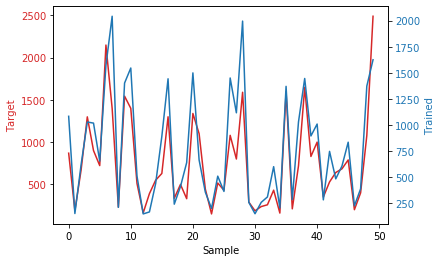

In [22]:
plot_twin(y_min_test[-50:], y_min_tested[-50:], y1_label="Target", y2_label="Trained")

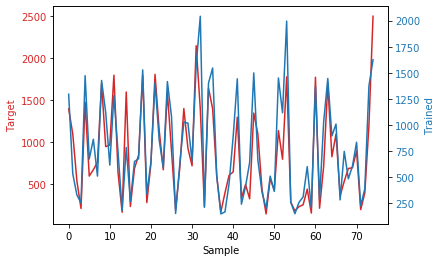

In [23]:
plot_twin(y_max_test[-75:], y_max_tested[-75:], y1_label="Target", y2_label="Trained")

# Determine interval at once

In [24]:
modeltest_int = keras.Sequential([
    keras.layers.Dense(13, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2)
])
modeltest_int.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["mse"])

In [25]:
history = modeltest_int.fit(X_train, y_train.values, validation_split=0.1, epochs=3000)

Train on 367 samples, validate on 41 samples
Epoch 1/3000
367/367 [==============================] - 1s 2ms/sample - loss: 537.9152 - mse: 545385.1875 - val_loss: 329.6833 - val_mse: 201348.2188
Epoch 2/3000
367/367 [==============================] - 0s 109us/sample - loss: 344.8957 - mse: 212306.2188 - val_loss: 318.0820 - val_mse: 201207.8125
Epoch 3/3000
367/367 [==============================] - 0s 101us/sample - loss: 323.1939 - mse: 230744.5469 - val_loss: 301.6586 - val_mse: 186297.2344
Epoch 4/3000
367/367 [==============================] - 0s 87us/sample - loss: 308.2351 - mse: 196304.0625 - val_loss: 296.1661 - val_mse: 191627.6875
Epoch 5/3000
367/367 [==============================] - 0s 98us/sample - loss: 292.7635 - mse: 177827.7031 - val_loss: 283.1739 - val_mse: 164320.9688
Epoch 6/3000
367/367 [==============================] - 0s 112us/sample - loss: 280.2504 - mse: 177160.2344 - val_loss: 268.5117 - val_mse: 150270.0469
Epoch 7/3000
367/367 [=========================

367/367 [==============================] - 0s 95us/sample - loss: 223.6109 - mse: 110046.1562 - val_loss: 225.1174 - val_mse: 142615.7656
Epoch 55/3000
367/367 [==============================] - 0s 106us/sample - loss: 215.4821 - mse: 106357.1562 - val_loss: 223.1653 - val_mse: 140856.8125
Epoch 56/3000
367/367 [==============================] - 0s 87us/sample - loss: 222.4076 - mse: 111092.4922 - val_loss: 230.3484 - val_mse: 139402.6250
Epoch 57/3000
367/367 [==============================] - 0s 87us/sample - loss: 215.7998 - mse: 108279.8281 - val_loss: 223.1694 - val_mse: 146373.0625
Epoch 58/3000
367/367 [==============================] - 0s 87us/sample - loss: 233.6241 - mse: 119130.8672 - val_loss: 246.9286 - val_mse: 140128.1406
Epoch 59/3000
367/367 [==============================] - 0s 87us/sample - loss: 228.9913 - mse: 113903.7891 - val_loss: 246.8448 - val_mse: 137654.3281
Epoch 60/3000
367/367 [==============================] - 0s 109us/sample - loss: 220.1672 - mse: 1088

367/367 [==============================] - 0s 95us/sample - loss: 215.0292 - mse: 106661.8984 - val_loss: 252.6117 - val_mse: 138720.1250
Epoch 108/3000
367/367 [==============================] - 0s 106us/sample - loss: 214.1389 - mse: 105700.7188 - val_loss: 230.9594 - val_mse: 136665.4375
Epoch 109/3000
367/367 [==============================] - 0s 106us/sample - loss: 208.0022 - mse: 101455.6172 - val_loss: 226.8709 - val_mse: 136523.7188
Epoch 110/3000
367/367 [==============================] - 0s 115us/sample - loss: 212.4973 - mse: 104497.3281 - val_loss: 251.9018 - val_mse: 139603.3594
Epoch 111/3000
367/367 [==============================] - 0s 93us/sample - loss: 217.7804 - mse: 107602.9766 - val_loss: 254.0128 - val_mse: 140265.6406
Epoch 112/3000
367/367 [==============================] - 0s 98us/sample - loss: 215.2914 - mse: 104645.1875 - val_loss: 226.7385 - val_mse: 137105.2656
Epoch 113/3000
367/367 [==============================] - 0s 98us/sample - loss: 211.2093 - ms

367/367 [==============================] - 0s 120us/sample - loss: 211.5262 - mse: 110686.0625 - val_loss: 238.0082 - val_mse: 135324.8750
Epoch 161/3000
367/367 [==============================] - 0s 120us/sample - loss: 208.9317 - mse: 103706.1172 - val_loss: 229.0303 - val_mse: 134316.3438
Epoch 162/3000
367/367 [==============================] - 0s 98us/sample - loss: 206.1439 - mse: 100949.0234 - val_loss: 219.2076 - val_mse: 138235.2500
Epoch 163/3000
367/367 [==============================] - 0s 95us/sample - loss: 205.3809 - mse: 100288.5469 - val_loss: 218.7472 - val_mse: 139800.6719
Epoch 164/3000
367/367 [==============================] - 0s 101us/sample - loss: 215.2797 - mse: 109315.1406 - val_loss: 250.5708 - val_mse: 138567.5781
Epoch 165/3000
367/367 [==============================] - 0s 93us/sample - loss: 208.2212 - mse: 102049.8828 - val_loss: 221.1907 - val_mse: 139036.7500
Epoch 166/3000
367/367 [==============================] - 0s 98us/sample - loss: 204.2435 - ms

Epoch 214/3000
367/367 [==============================] - 0s 90us/sample - loss: 202.6845 - mse: 102494.6484 - val_loss: 238.2661 - val_mse: 135820.9531
Epoch 215/3000
367/367 [==============================] - 0s 98us/sample - loss: 202.0194 - mse: 99437.5234 - val_loss: 230.0469 - val_mse: 136314.7969
Epoch 216/3000
367/367 [==============================] - 0s 109us/sample - loss: 201.2857 - mse: 97974.4531 - val_loss: 220.2982 - val_mse: 137743.4375
Epoch 217/3000
367/367 [==============================] - 0s 123us/sample - loss: 203.7668 - mse: 100285.9375 - val_loss: 222.4989 - val_mse: 137063.0000
Epoch 218/3000
367/367 [==============================] - 0s 134us/sample - loss: 203.6482 - mse: 102621.0156 - val_loss: 237.6921 - val_mse: 135930.4219
Epoch 219/3000
367/367 [==============================] - 0s 90us/sample - loss: 201.9758 - mse: 100456.6875 - val_loss: 221.9935 - val_mse: 135929.9844
Epoch 220/3000
367/367 [==============================] - 0s 95us/sample - loss: 

367/367 [==============================] - 0s 106us/sample - loss: 197.9142 - mse: 96048.1172 - val_loss: 219.5141 - val_mse: 138846.1719
Epoch 268/3000
367/367 [==============================] - 0s 90us/sample - loss: 200.7630 - mse: 96380.2266 - val_loss: 218.4123 - val_mse: 138953.6094
Epoch 269/3000
367/367 [==============================] - 0s 93us/sample - loss: 198.9138 - mse: 97286.1250 - val_loss: 222.2491 - val_mse: 135778.4062
Epoch 270/3000
367/367 [==============================] - 0s 93us/sample - loss: 200.3129 - mse: 98991.0000 - val_loss: 221.0183 - val_mse: 135834.0469
Epoch 271/3000
367/367 [==============================] - 0s 90us/sample - loss: 197.4624 - mse: 94764.1953 - val_loss: 231.8774 - val_mse: 135181.1406
Epoch 272/3000
367/367 [==============================] - 0s 93us/sample - loss: 202.9116 - mse: 98515.1250 - val_loss: 238.8869 - val_mse: 136113.9688
Epoch 273/3000
367/367 [==============================] - 0s 90us/sample - loss: 201.9418 - mse: 99564

Epoch 321/3000
367/367 [==============================] - 0s 90us/sample - loss: 197.2891 - mse: 93485.1016 - val_loss: 216.5127 - val_mse: 143291.6406
Epoch 322/3000
367/367 [==============================] - 0s 109us/sample - loss: 194.5159 - mse: 93295.2812 - val_loss: 231.9186 - val_mse: 135409.3906
Epoch 323/3000
367/367 [==============================] - 0s 93us/sample - loss: 196.2722 - mse: 93998.8906 - val_loss: 225.2795 - val_mse: 135371.9531
Epoch 324/3000
367/367 [==============================] - 0s 109us/sample - loss: 194.1882 - mse: 93484.5234 - val_loss: 214.3630 - val_mse: 141980.0625
Epoch 325/3000
367/367 [==============================] - 0s 98us/sample - loss: 199.8715 - mse: 95083.9531 - val_loss: 216.6907 - val_mse: 141389.3125
Epoch 326/3000
367/367 [==============================] - 0s 93us/sample - loss: 197.6230 - mse: 96202.5938 - val_loss: 229.3128 - val_mse: 134531.7344
Epoch 327/3000
367/367 [==============================] - 0s 104us/sample - loss: 196.

Epoch 375/3000
367/367 [==============================] - 0s 90us/sample - loss: 191.3812 - mse: 92668.0625 - val_loss: 216.5240 - val_mse: 136751.3125
Epoch 376/3000
367/367 [==============================] - 0s 90us/sample - loss: 191.8760 - mse: 91830.7109 - val_loss: 222.6143 - val_mse: 134705.5625
Epoch 377/3000
367/367 [==============================] - 0s 93us/sample - loss: 199.6727 - mse: 92225.8203 - val_loss: 234.5166 - val_mse: 134044.4688
Epoch 378/3000
367/367 [==============================] - 0s 90us/sample - loss: 193.8349 - mse: 93911.9141 - val_loss: 233.9764 - val_mse: 133157.0781
Epoch 379/3000
367/367 [==============================] - 0s 93us/sample - loss: 194.7031 - mse: 94053.2734 - val_loss: 225.0325 - val_mse: 133622.2500
Epoch 380/3000
367/367 [==============================] - 0s 101us/sample - loss: 193.0411 - mse: 90995.5078 - val_loss: 222.1462 - val_mse: 134837.4688
Epoch 381/3000
367/367 [==============================] - 0s 101us/sample - loss: 193.6

Epoch 429/3000
367/367 [==============================] - 0s 95us/sample - loss: 189.9037 - mse: 89771.2188 - val_loss: 216.3086 - val_mse: 134625.8594
Epoch 430/3000
367/367 [==============================] - 0s 93us/sample - loss: 192.5590 - mse: 93470.7344 - val_loss: 228.6800 - val_mse: 133442.7344
Epoch 431/3000
367/367 [==============================] - 0s 87us/sample - loss: 192.9116 - mse: 93577.7578 - val_loss: 219.2337 - val_mse: 130977.4375
Epoch 432/3000
367/367 [==============================] - 0s 93us/sample - loss: 188.7314 - mse: 88451.4609 - val_loss: 227.1660 - val_mse: 133040.4219
Epoch 433/3000
367/367 [==============================] - 0s 90us/sample - loss: 193.5876 - mse: 95165.5234 - val_loss: 224.4634 - val_mse: 132754.5781
Epoch 434/3000
367/367 [==============================] - 0s 101us/sample - loss: 192.9892 - mse: 90908.6328 - val_loss: 231.9522 - val_mse: 131622.8125
Epoch 435/3000
367/367 [==============================] - 0s 104us/sample - loss: 193.3

Epoch 483/3000
367/367 [==============================] - 0s 90us/sample - loss: 184.0399 - mse: 86344.0469 - val_loss: 212.3994 - val_mse: 128348.0938
Epoch 484/3000
367/367 [==============================] - 0s 87us/sample - loss: 184.2940 - mse: 83544.2656 - val_loss: 201.3904 - val_mse: 128838.1719
Epoch 485/3000
367/367 [==============================] - 0s 101us/sample - loss: 187.8406 - mse: 88010.2266 - val_loss: 209.4405 - val_mse: 123917.1328
Epoch 486/3000
367/367 [==============================] - 0s 115us/sample - loss: 185.3814 - mse: 85069.6953 - val_loss: 201.7588 - val_mse: 131843.1406
Epoch 487/3000
367/367 [==============================] - 0s 95us/sample - loss: 184.2299 - mse: 86564.0703 - val_loss: 218.4616 - val_mse: 124648.3438
Epoch 488/3000
367/367 [==============================] - 0s 93us/sample - loss: 185.3279 - mse: 86161.9531 - val_loss: 204.2748 - val_mse: 130308.3438
Epoch 489/3000
367/367 [==============================] - 0s 93us/sample - loss: 185.4

Epoch 537/3000
367/367 [==============================] - 0s 90us/sample - loss: 187.1373 - mse: 87918.4609 - val_loss: 223.2510 - val_mse: 126031.9297
Epoch 538/3000
367/367 [==============================] - 0s 87us/sample - loss: 184.4702 - mse: 89269.0000 - val_loss: 203.4069 - val_mse: 122617.8750
Epoch 539/3000
367/367 [==============================] - 0s 98us/sample - loss: 182.7663 - mse: 85219.3281 - val_loss: 212.1631 - val_mse: 120527.0938
Epoch 540/3000
367/367 [==============================] - 0s 95us/sample - loss: 183.2664 - mse: 82847.1562 - val_loss: 195.9365 - val_mse: 130022.6797
Epoch 541/3000
367/367 [==============================] - 0s 90us/sample - loss: 186.2594 - mse: 85347.1953 - val_loss: 210.9225 - val_mse: 122167.9766
Epoch 542/3000
367/367 [==============================] - 0s 93us/sample - loss: 181.1264 - mse: 82548.2109 - val_loss: 218.5269 - val_mse: 129554.1328
Epoch 543/3000
367/367 [==============================] - 0s 93us/sample - loss: 178.501

Epoch 591/3000
367/367 [==============================] - 0s 90us/sample - loss: 175.8515 - mse: 78686.3359 - val_loss: 191.0230 - val_mse: 124048.4375
Epoch 592/3000
367/367 [==============================] - 0s 90us/sample - loss: 180.5721 - mse: 79749.4297 - val_loss: 195.1651 - val_mse: 112813.6250
Epoch 593/3000
367/367 [==============================] - 0s 87us/sample - loss: 177.7845 - mse: 77860.4453 - val_loss: 199.4740 - val_mse: 116618.5703
Epoch 594/3000
367/367 [==============================] - 0s 90us/sample - loss: 175.7095 - mse: 79618.2578 - val_loss: 204.9705 - val_mse: 116808.1094
Epoch 595/3000
367/367 [==============================] - 0s 90us/sample - loss: 174.3078 - mse: 76438.5703 - val_loss: 198.5083 - val_mse: 112892.4844
Epoch 596/3000
367/367 [==============================] - 0s 93us/sample - loss: 178.9697 - mse: 79855.7734 - val_loss: 204.2887 - val_mse: 115860.4844
Epoch 597/3000
367/367 [==============================] - 0s 90us/sample - loss: 172.139

367/367 [==============================] - 0s 90us/sample - loss: 178.5000 - mse: 82209.6719 - val_loss: 217.2169 - val_mse: 119876.7109
Epoch 645/3000
367/367 [==============================] - 0s 95us/sample - loss: 173.4483 - mse: 76046.4766 - val_loss: 202.9896 - val_mse: 115537.6797
Epoch 646/3000
367/367 [==============================] - 0s 98us/sample - loss: 173.1620 - mse: 75595.5312 - val_loss: 192.7209 - val_mse: 113519.2891
Epoch 647/3000
367/367 [==============================] - 0s 90us/sample - loss: 186.3896 - mse: 81260.2188 - val_loss: 193.9587 - val_mse: 113590.8047
Epoch 648/3000
367/367 [==============================] - 0s 101us/sample - loss: 181.5871 - mse: 83152.6250 - val_loss: 224.2604 - val_mse: 122814.6250
Epoch 649/3000
367/367 [==============================] - 0s 98us/sample - loss: 178.6212 - mse: 77485.8984 - val_loss: 206.5112 - val_mse: 114117.0469
Epoch 650/3000
367/367 [==============================] - 0s 93us/sample - loss: 170.6117 - mse: 76187

Epoch 698/3000
367/367 [==============================] - 0s 95us/sample - loss: 169.5941 - mse: 73716.2969 - val_loss: 200.5292 - val_mse: 118139.6094
Epoch 699/3000
367/367 [==============================] - 0s 93us/sample - loss: 167.6670 - mse: 72443.7422 - val_loss: 196.8660 - val_mse: 124158.0703
Epoch 700/3000
367/367 [==============================] - 0s 85us/sample - loss: 176.0410 - mse: 74771.6484 - val_loss: 186.8512 - val_mse: 116458.8047
Epoch 701/3000
367/367 [==============================] - 0s 90us/sample - loss: 182.4798 - mse: 81739.5156 - val_loss: 184.8757 - val_mse: 113365.0469
Epoch 702/3000
367/367 [==============================] - 0s 90us/sample - loss: 169.2384 - mse: 68866.3828 - val_loss: 235.2912 - val_mse: 127839.2188
Epoch 703/3000
367/367 [==============================] - 0s 90us/sample - loss: 169.0632 - mse: 74077.0156 - val_loss: 194.7065 - val_mse: 110212.9531
Epoch 704/3000
367/367 [==============================] - 0s 87us/sample - loss: 165.866

367/367 [==============================] - 0s 93us/sample - loss: 169.0319 - mse: 74051.6250 - val_loss: 180.1834 - val_mse: 106494.2578
Epoch 752/3000
367/367 [==============================] - 0s 95us/sample - loss: 171.1082 - mse: 72972.9453 - val_loss: 182.8239 - val_mse: 113806.9531
Epoch 753/3000
367/367 [==============================] - 0s 93us/sample - loss: 172.8245 - mse: 73863.1406 - val_loss: 190.7997 - val_mse: 118255.3516
Epoch 754/3000
367/367 [==============================] - 0s 90us/sample - loss: 169.0957 - mse: 73823.2734 - val_loss: 190.7713 - val_mse: 107428.0703
Epoch 755/3000
367/367 [==============================] - 0s 98us/sample - loss: 172.9717 - mse: 80433.9453 - val_loss: 236.1973 - val_mse: 127022.6562
Epoch 756/3000
367/367 [==============================] - 0s 93us/sample - loss: 168.6164 - mse: 73786.9531 - val_loss: 198.0936 - val_mse: 108026.1953
Epoch 757/3000
367/367 [==============================] - 0s 90us/sample - loss: 166.8985 - mse: 70677.

Epoch 805/3000
367/367 [==============================] - 0s 90us/sample - loss: 167.2523 - mse: 71952.6562 - val_loss: 191.1735 - val_mse: 108001.2344
Epoch 806/3000
367/367 [==============================] - 0s 87us/sample - loss: 165.6320 - mse: 72504.7891 - val_loss: 187.5436 - val_mse: 107102.9062
Epoch 807/3000
367/367 [==============================] - 0s 93us/sample - loss: 164.7668 - mse: 72579.4609 - val_loss: 205.2609 - val_mse: 110697.5859
Epoch 808/3000
367/367 [==============================] - 0s 90us/sample - loss: 168.1827 - mse: 71829.8672 - val_loss: 185.6318 - val_mse: 106554.2656
Epoch 809/3000
367/367 [==============================] - 0s 87us/sample - loss: 167.7487 - mse: 76812.8750 - val_loss: 198.2263 - val_mse: 106525.3516
Epoch 810/3000
367/367 [==============================] - 0s 90us/sample - loss: 163.0294 - mse: 71316.2734 - val_loss: 188.6777 - val_mse: 105916.3203
Epoch 811/3000
367/367 [==============================] - 0s 93us/sample - loss: 165.082

Epoch 859/3000
367/367 [==============================] - 0s 93us/sample - loss: 178.7122 - mse: 83293.6641 - val_loss: 204.1774 - val_mse: 112954.1719
Epoch 860/3000
367/367 [==============================] - 0s 93us/sample - loss: 171.0923 - mse: 71090.8594 - val_loss: 192.7033 - val_mse: 119031.4531
Epoch 861/3000
367/367 [==============================] - 0s 90us/sample - loss: 182.9180 - mse: 82064.9922 - val_loss: 210.4368 - val_mse: 112812.6953
Epoch 862/3000
367/367 [==============================] - 0s 90us/sample - loss: 171.7087 - mse: 70683.0703 - val_loss: 227.5565 - val_mse: 120073.5703
Epoch 863/3000
367/367 [==============================] - 0s 90us/sample - loss: 174.9217 - mse: 74770.2266 - val_loss: 191.7649 - val_mse: 108741.9609
Epoch 864/3000
367/367 [==============================] - 0s 95us/sample - loss: 168.9751 - mse: 70846.9844 - val_loss: 192.8460 - val_mse: 107654.8750
Epoch 865/3000
367/367 [==============================] - 0s 93us/sample - loss: 165.244

Epoch 913/3000
367/367 [==============================] - 0s 90us/sample - loss: 164.9383 - mse: 67864.6641 - val_loss: 176.1619 - val_mse: 104647.2109
Epoch 914/3000
367/367 [==============================] - 0s 93us/sample - loss: 162.2267 - mse: 69989.5234 - val_loss: 195.5839 - val_mse: 107558.5391
Epoch 915/3000
367/367 [==============================] - 0s 101us/sample - loss: 163.1430 - mse: 70539.7891 - val_loss: 193.9884 - val_mse: 107943.5156
Epoch 916/3000
367/367 [==============================] - 0s 117us/sample - loss: 159.3234 - mse: 66926.6016 - val_loss: 185.9137 - val_mse: 102788.2812
Epoch 917/3000
367/367 [==============================] - 0s 123us/sample - loss: 159.5976 - mse: 68454.0625 - val_loss: 185.8832 - val_mse: 103028.9531
Epoch 918/3000
367/367 [==============================] - 0s 98us/sample - loss: 160.6171 - mse: 68406.9062 - val_loss: 195.1834 - val_mse: 108088.0000
Epoch 919/3000
367/367 [==============================] - 0s 93us/sample - loss: 159.

Epoch 967/3000
367/367 [==============================] - 0s 115us/sample - loss: 162.8998 - mse: 69820.4609 - val_loss: 198.7815 - val_mse: 107604.8281
Epoch 968/3000
367/367 [==============================] - 0s 95us/sample - loss: 168.2801 - mse: 70128.0469 - val_loss: 190.8916 - val_mse: 106472.0859
Epoch 969/3000
367/367 [==============================] - 0s 123us/sample - loss: 161.5463 - mse: 70259.6641 - val_loss: 202.0824 - val_mse: 107850.9297
Epoch 970/3000
367/367 [==============================] - 0s 90us/sample - loss: 162.0030 - mse: 72292.4766 - val_loss: 201.0876 - val_mse: 109070.8438
Epoch 971/3000
367/367 [==============================] - 0s 95us/sample - loss: 167.9746 - mse: 70956.9609 - val_loss: 198.8929 - val_mse: 110863.6484
Epoch 972/3000
367/367 [==============================] - 0s 90us/sample - loss: 169.0736 - mse: 70792.1172 - val_loss: 195.9031 - val_mse: 110757.2656
Epoch 973/3000
367/367 [==============================] - 0s 93us/sample - loss: 160.0

Epoch 1021/3000
367/367 [==============================] - 0s 109us/sample - loss: 157.4750 - mse: 65583.6953 - val_loss: 202.3211 - val_mse: 106130.3281
Epoch 1022/3000
367/367 [==============================] - 0s 98us/sample - loss: 161.7242 - mse: 69025.6094 - val_loss: 201.8298 - val_mse: 107451.9062
Epoch 1023/3000
367/367 [==============================] - 0s 95us/sample - loss: 167.5540 - mse: 70289.0391 - val_loss: 184.3190 - val_mse: 107844.3906
Epoch 1024/3000
367/367 [==============================] - 0s 93us/sample - loss: 165.4354 - mse: 72683.4844 - val_loss: 190.2652 - val_mse: 105899.2422
Epoch 1025/3000
367/367 [==============================] - 0s 93us/sample - loss: 160.6273 - mse: 66083.0703 - val_loss: 186.8071 - val_mse: 107003.4297
Epoch 1026/3000
367/367 [==============================] - 0s 90us/sample - loss: 163.2814 - mse: 69666.1250 - val_loss: 180.9305 - val_mse: 104742.2578
Epoch 1027/3000
367/367 [==============================] - 0s 95us/sample - loss:

367/367 [==============================] - 0s 93us/sample - loss: 157.7920 - mse: 69424.8984 - val_loss: 208.1595 - val_mse: 112802.4141
Epoch 1075/3000
367/367 [==============================] - 0s 95us/sample - loss: 161.3568 - mse: 68297.1328 - val_loss: 190.0520 - val_mse: 103074.6328
Epoch 1076/3000
367/367 [==============================] - 0s 93us/sample - loss: 159.6919 - mse: 68102.6953 - val_loss: 196.3166 - val_mse: 108890.1797
Epoch 1077/3000
367/367 [==============================] - 0s 95us/sample - loss: 159.1204 - mse: 70882.3672 - val_loss: 201.1891 - val_mse: 108756.7188
Epoch 1078/3000
367/367 [==============================] - 0s 93us/sample - loss: 165.8973 - mse: 71290.9688 - val_loss: 195.8124 - val_mse: 103209.9609
Epoch 1079/3000
367/367 [==============================] - 0s 93us/sample - loss: 157.8185 - mse: 64720.4961 - val_loss: 186.2672 - val_mse: 107864.3516
Epoch 1080/3000
367/367 [==============================] - 0s 93us/sample - loss: 163.3482 - mse: 

367/367 [==============================] - 0s 93us/sample - loss: 163.0636 - mse: 69120.9062 - val_loss: 186.6156 - val_mse: 106148.9375
Epoch 1128/3000
367/367 [==============================] - 0s 90us/sample - loss: 158.0725 - mse: 66554.4531 - val_loss: 178.1282 - val_mse: 98130.5859
Epoch 1129/3000
367/367 [==============================] - 0s 90us/sample - loss: 157.4861 - mse: 64309.5586 - val_loss: 184.2489 - val_mse: 100980.0000
Epoch 1130/3000
367/367 [==============================] - 0s 101us/sample - loss: 157.9210 - mse: 66230.7656 - val_loss: 178.6720 - val_mse: 99178.3750
Epoch 1131/3000
367/367 [==============================] - 0s 95us/sample - loss: 158.3815 - mse: 68273.7812 - val_loss: 186.5633 - val_mse: 98406.7578
Epoch 1132/3000
367/367 [==============================] - 0s 93us/sample - loss: 157.4599 - mse: 67064.1172 - val_loss: 189.0220 - val_mse: 100036.7656
Epoch 1133/3000
367/367 [==============================] - 0s 95us/sample - loss: 158.6822 - mse: 65

Epoch 1181/3000
367/367 [==============================] - 0s 90us/sample - loss: 156.7697 - mse: 63383.6094 - val_loss: 188.7106 - val_mse: 98598.4297
Epoch 1182/3000
367/367 [==============================] - 0s 93us/sample - loss: 155.2033 - mse: 65999.3906 - val_loss: 183.8632 - val_mse: 99429.8750
Epoch 1183/3000
367/367 [==============================] - 0s 93us/sample - loss: 155.0293 - mse: 64493.5000 - val_loss: 185.5805 - val_mse: 99493.4531
Epoch 1184/3000
367/367 [==============================] - 0s 90us/sample - loss: 155.3626 - mse: 65072.5195 - val_loss: 181.3444 - val_mse: 100316.1484
Epoch 1185/3000
367/367 [==============================] - 0s 90us/sample - loss: 173.2208 - mse: 72256.2422 - val_loss: 194.8930 - val_mse: 101615.0781
Epoch 1186/3000
367/367 [==============================] - 0s 93us/sample - loss: 156.0665 - mse: 66310.6719 - val_loss: 193.6911 - val_mse: 102243.5234
Epoch 1187/3000
367/367 [==============================] - 0s 93us/sample - loss: 157

Epoch 1235/3000
367/367 [==============================] - 0s 98us/sample - loss: 162.1189 - mse: 68673.1719 - val_loss: 178.3810 - val_mse: 99358.1797
Epoch 1236/3000
367/367 [==============================] - 0s 95us/sample - loss: 161.0125 - mse: 65887.0938 - val_loss: 188.3571 - val_mse: 99125.5156
Epoch 1237/3000
367/367 [==============================] - 0s 98us/sample - loss: 158.2794 - mse: 64532.5664 - val_loss: 184.3601 - val_mse: 105299.7578
Epoch 1238/3000
367/367 [==============================] - 0s 93us/sample - loss: 157.3894 - mse: 63454.8516 - val_loss: 186.9529 - val_mse: 106981.8438
Epoch 1239/3000
367/367 [==============================] - 0s 109us/sample - loss: 155.7613 - mse: 64818.3047 - val_loss: 174.2952 - val_mse: 93817.4062
Epoch 1240/3000
367/367 [==============================] - 0s 150us/sample - loss: 158.0348 - mse: 65246.0391 - val_loss: 185.1455 - val_mse: 101222.1953
Epoch 1241/3000
367/367 [==============================] - 0s 169us/sample - loss: 

367/367 [==============================] - 0s 175us/sample - loss: 154.6649 - mse: 64706.9961 - val_loss: 176.9967 - val_mse: 94819.9688
Epoch 1289/3000
367/367 [==============================] - 0s 164us/sample - loss: 151.5791 - mse: 63163.0352 - val_loss: 187.3215 - val_mse: 97015.8359
Epoch 1290/3000
367/367 [==============================] - 0s 172us/sample - loss: 153.9186 - mse: 63271.3555 - val_loss: 181.5290 - val_mse: 99999.6562
Epoch 1291/3000
367/367 [==============================] - 0s 155us/sample - loss: 162.4727 - mse: 67052.2344 - val_loss: 179.0712 - val_mse: 99644.1328
Epoch 1292/3000
367/367 [==============================] - 0s 169us/sample - loss: 158.4012 - mse: 66740.6016 - val_loss: 193.5375 - val_mse: 98284.4297
Epoch 1293/3000
367/367 [==============================] - 0s 161us/sample - loss: 156.1072 - mse: 63544.8516 - val_loss: 181.5181 - val_mse: 101616.6875
Epoch 1294/3000
367/367 [==============================] - 0s 164us/sample - loss: 157.2192 - mse

367/367 [==============================] - 0s 169us/sample - loss: 153.1603 - mse: 61379.2852 - val_loss: 177.7628 - val_mse: 93855.3750
Epoch 1342/3000
367/367 [==============================] - 0s 185us/sample - loss: 154.4678 - mse: 63374.0430 - val_loss: 191.9675 - val_mse: 96215.5781
Epoch 1343/3000
367/367 [==============================] - 0s 194us/sample - loss: 152.3756 - mse: 60597.3906 - val_loss: 195.2316 - val_mse: 98587.3047
Epoch 1344/3000
367/367 [==============================] - 0s 155us/sample - loss: 154.9193 - mse: 65172.6602 - val_loss: 185.8377 - val_mse: 97526.4844
Epoch 1345/3000
367/367 [==============================] - 0s 169us/sample - loss: 157.0964 - mse: 63442.7344 - val_loss: 192.5771 - val_mse: 99375.2734
Epoch 1346/3000
367/367 [==============================] - 0s 150us/sample - loss: 152.6768 - mse: 58777.0312 - val_loss: 176.6852 - val_mse: 97237.5703
Epoch 1347/3000
367/367 [==============================] - 0s 153us/sample - loss: 156.7430 - mse:

Epoch 1395/3000
367/367 [==============================] - 0s 155us/sample - loss: 157.0036 - mse: 62995.1172 - val_loss: 202.6075 - val_mse: 102976.0156
Epoch 1396/3000
367/367 [==============================] - 0s 142us/sample - loss: 151.8924 - mse: 63773.4023 - val_loss: 187.0299 - val_mse: 92695.6328
Epoch 1397/3000
367/367 [==============================] - 0s 139us/sample - loss: 148.7982 - mse: 59283.4648 - val_loss: 187.5244 - val_mse: 98231.5703
Epoch 1398/3000
367/367 [==============================] - 0s 139us/sample - loss: 151.2861 - mse: 61543.8438 - val_loss: 189.2168 - val_mse: 95621.9297
Epoch 1399/3000
367/367 [==============================] - 0s 145us/sample - loss: 155.8456 - mse: 65834.2188 - val_loss: 200.9238 - val_mse: 118574.4766
Epoch 1400/3000
367/367 [==============================] - 0s 139us/sample - loss: 158.4042 - mse: 66647.1172 - val_loss: 179.8448 - val_mse: 99331.3906
Epoch 1401/3000
367/367 [==============================] - 0s 153us/sample - los

367/367 [==============================] - 0s 98us/sample - loss: 159.1572 - mse: 67850.2812 - val_loss: 225.7990 - val_mse: 102372.2188
Epoch 1449/3000
367/367 [==============================] - 0s 93us/sample - loss: 165.2595 - mse: 62427.5312 - val_loss: 177.3748 - val_mse: 98325.3047
Epoch 1450/3000
367/367 [==============================] - 0s 95us/sample - loss: 156.5663 - mse: 63401.4609 - val_loss: 190.1789 - val_mse: 103582.6562
Epoch 1451/3000
367/367 [==============================] - 0s 95us/sample - loss: 157.4627 - mse: 62749.9023 - val_loss: 175.6876 - val_mse: 89032.1094
Epoch 1452/3000
367/367 [==============================] - 0s 117us/sample - loss: 154.3183 - mse: 64436.0234 - val_loss: 200.6932 - val_mse: 113565.0859
Epoch 1453/3000
367/367 [==============================] - 0s 101us/sample - loss: 153.3616 - mse: 60605.0039 - val_loss: 183.1143 - val_mse: 89160.5234
Epoch 1454/3000
367/367 [==============================] - 0s 95us/sample - loss: 147.9038 - mse: 5

367/367 [==============================] - 0s 95us/sample - loss: 153.1941 - mse: 61403.9414 - val_loss: 182.6703 - val_mse: 102905.7891
Epoch 1502/3000
367/367 [==============================] - 0s 117us/sample - loss: 151.9743 - mse: 61077.1055 - val_loss: 186.5199 - val_mse: 91093.0234
Epoch 1503/3000
367/367 [==============================] - 0s 95us/sample - loss: 148.6961 - mse: 58694.0508 - val_loss: 184.7533 - val_mse: 89854.8203
Epoch 1504/3000
367/367 [==============================] - 0s 98us/sample - loss: 151.3563 - mse: 60114.7539 - val_loss: 194.5821 - val_mse: 100987.9609
Epoch 1505/3000
367/367 [==============================] - 0s 95us/sample - loss: 150.9395 - mse: 59706.8516 - val_loss: 176.1191 - val_mse: 89248.1562
Epoch 1506/3000
367/367 [==============================] - 0s 115us/sample - loss: 149.9353 - mse: 59264.4688 - val_loss: 177.9158 - val_mse: 91925.2344
Epoch 1507/3000
367/367 [==============================] - 0s 120us/sample - loss: 149.5124 - mse: 6

367/367 [==============================] - 0s 131us/sample - loss: 155.4504 - mse: 61956.4570 - val_loss: 179.9517 - val_mse: 94633.4766
Epoch 1555/3000
367/367 [==============================] - 0s 123us/sample - loss: 151.6412 - mse: 59530.7734 - val_loss: 189.6473 - val_mse: 92210.8438
Epoch 1556/3000
367/367 [==============================] - 0s 120us/sample - loss: 145.8096 - mse: 57051.4922 - val_loss: 200.0217 - val_mse: 93999.5000
Epoch 1557/3000
367/367 [==============================] - 0s 98us/sample - loss: 146.8625 - mse: 57581.9961 - val_loss: 186.1453 - val_mse: 89531.5156
Epoch 1558/3000
367/367 [==============================] - 0s 117us/sample - loss: 147.5324 - mse: 62618.2344 - val_loss: 198.4188 - val_mse: 105295.6484
Epoch 1559/3000
367/367 [==============================] - 0s 104us/sample - loss: 149.1981 - mse: 58178.6211 - val_loss: 197.0366 - val_mse: 91742.2891
Epoch 1560/3000
367/367 [==============================] - 0s 115us/sample - loss: 147.4467 - mse:

Epoch 1608/3000
367/367 [==============================] - 0s 93us/sample - loss: 145.8235 - mse: 56014.1680 - val_loss: 181.3952 - val_mse: 89556.7812
Epoch 1609/3000
367/367 [==============================] - 0s 93us/sample - loss: 148.4086 - mse: 56843.8359 - val_loss: 191.1057 - val_mse: 89760.6250
Epoch 1610/3000
367/367 [==============================] - 0s 95us/sample - loss: 144.6213 - mse: 56460.5898 - val_loss: 185.8269 - val_mse: 92313.5703
Epoch 1611/3000
367/367 [==============================] - 0s 95us/sample - loss: 147.2122 - mse: 60981.3008 - val_loss: 217.0913 - val_mse: 103406.0625
Epoch 1612/3000
367/367 [==============================] - 0s 93us/sample - loss: 156.3916 - mse: 63501.6836 - val_loss: 187.9788 - val_mse: 88489.7891
Epoch 1613/3000
367/367 [==============================] - 0s 93us/sample - loss: 150.4465 - mse: 58156.8945 - val_loss: 187.4984 - val_mse: 104153.0938
Epoch 1614/3000
367/367 [==============================] - 0s 93us/sample - loss: 145.

Epoch 1662/3000
367/367 [==============================] - 0s 98us/sample - loss: 152.0224 - mse: 57294.2070 - val_loss: 213.9960 - val_mse: 101076.7188
Epoch 1663/3000
367/367 [==============================] - 0s 95us/sample - loss: 151.1009 - mse: 62325.6680 - val_loss: 223.5875 - val_mse: 107553.4844
Epoch 1664/3000
367/367 [==============================] - 0s 95us/sample - loss: 154.0232 - mse: 65674.3672 - val_loss: 189.3352 - val_mse: 98517.0938
Epoch 1665/3000
367/367 [==============================] - 0s 93us/sample - loss: 145.5234 - mse: 55886.0312 - val_loss: 179.1730 - val_mse: 84465.2344
Epoch 1666/3000
367/367 [==============================] - 0s 95us/sample - loss: 146.4981 - mse: 57431.4648 - val_loss: 176.5861 - val_mse: 87361.2578
Epoch 1667/3000
367/367 [==============================] - 0s 98us/sample - loss: 147.4095 - mse: 56808.7539 - val_loss: 177.8298 - val_mse: 84100.7109
Epoch 1668/3000
367/367 [==============================] - 0s 115us/sample - loss: 148

Epoch 1716/3000
367/367 [==============================] - 0s 109us/sample - loss: 141.4242 - mse: 53058.1953 - val_loss: 186.4846 - val_mse: 95011.4297
Epoch 1717/3000
367/367 [==============================] - 0s 109us/sample - loss: 148.0115 - mse: 58807.4531 - val_loss: 199.8822 - val_mse: 92754.6328
Epoch 1718/3000
367/367 [==============================] - 0s 112us/sample - loss: 146.1080 - mse: 57870.0781 - val_loss: 191.9081 - val_mse: 88417.7812
Epoch 1719/3000
367/367 [==============================] - 0s 115us/sample - loss: 148.4405 - mse: 57985.5195 - val_loss: 185.3713 - val_mse: 83784.4609
Epoch 1720/3000
367/367 [==============================] - 0s 117us/sample - loss: 153.9218 - mse: 65293.9766 - val_loss: 189.3445 - val_mse: 89681.1250
Epoch 1721/3000
367/367 [==============================] - 0s 125us/sample - loss: 153.0662 - mse: 58549.8633 - val_loss: 174.4022 - val_mse: 91551.5234
Epoch 1722/3000
367/367 [==============================] - 0s 112us/sample - loss:

367/367 [==============================] - 0s 131us/sample - loss: 143.7780 - mse: 58749.0039 - val_loss: 171.0468 - val_mse: 76622.6094
Epoch 1770/3000
367/367 [==============================] - 0s 98us/sample - loss: 140.7401 - mse: 53183.2227 - val_loss: 180.1900 - val_mse: 87087.2031
Epoch 1771/3000
367/367 [==============================] - 0s 93us/sample - loss: 150.2449 - mse: 58286.3281 - val_loss: 177.4741 - val_mse: 83505.5078
Epoch 1772/3000
367/367 [==============================] - 0s 145us/sample - loss: 152.9668 - mse: 60615.6406 - val_loss: 188.3245 - val_mse: 86556.9062
Epoch 1773/3000
367/367 [==============================] - 0s 95us/sample - loss: 148.2538 - mse: 56115.2656 - val_loss: 197.9550 - val_mse: 86428.3203
Epoch 1774/3000
367/367 [==============================] - 0s 93us/sample - loss: 149.9357 - mse: 59541.1719 - val_loss: 220.1680 - val_mse: 101793.2109
Epoch 1775/3000
367/367 [==============================] - 0s 95us/sample - loss: 156.9954 - mse: 633

Epoch 1823/3000
367/367 [==============================] - 0s 95us/sample - loss: 149.6198 - mse: 58677.0117 - val_loss: 177.3514 - val_mse: 85983.2500
Epoch 1824/3000
367/367 [==============================] - 0s 93us/sample - loss: 153.0769 - mse: 58191.1133 - val_loss: 178.0245 - val_mse: 82941.2188
Epoch 1825/3000
367/367 [==============================] - 0s 95us/sample - loss: 150.3162 - mse: 59440.1914 - val_loss: 206.5600 - val_mse: 97262.8516
Epoch 1826/3000
367/367 [==============================] - 0s 95us/sample - loss: 149.3851 - mse: 56766.1641 - val_loss: 190.5005 - val_mse: 90642.1562
Epoch 1827/3000
367/367 [==============================] - 0s 95us/sample - loss: 145.5809 - mse: 56447.5195 - val_loss: 178.8979 - val_mse: 84478.7422
Epoch 1828/3000
367/367 [==============================] - 0s 90us/sample - loss: 143.0883 - mse: 56376.4414 - val_loss: 188.5206 - val_mse: 87744.2188
Epoch 1829/3000
367/367 [==============================] - 0s 93us/sample - loss: 147.37

Epoch 1877/3000
367/367 [==============================] - 0s 95us/sample - loss: 141.5436 - mse: 57639.7656 - val_loss: 202.5289 - val_mse: 92596.2266
Epoch 1878/3000
367/367 [==============================] - 0s 98us/sample - loss: 149.4101 - mse: 61135.7344 - val_loss: 187.4851 - val_mse: 92089.0000
Epoch 1879/3000
367/367 [==============================] - 0s 95us/sample - loss: 149.0308 - mse: 57641.3359 - val_loss: 183.3553 - val_mse: 86111.1016
Epoch 1880/3000
367/367 [==============================] - 0s 93us/sample - loss: 148.5694 - mse: 59906.6367 - val_loss: 181.7078 - val_mse: 88523.8750
Epoch 1881/3000
367/367 [==============================] - 0s 95us/sample - loss: 147.5884 - mse: 54440.1797 - val_loss: 172.5306 - val_mse: 82196.4297
Epoch 1882/3000
367/367 [==============================] - 0s 93us/sample - loss: 142.6104 - mse: 56552.6445 - val_loss: 195.0660 - val_mse: 88527.0469
Epoch 1883/3000
367/367 [==============================] - 0s 93us/sample - loss: 144.69

Epoch 1931/3000
367/367 [==============================] - 0s 101us/sample - loss: 144.3195 - mse: 56547.3633 - val_loss: 189.8568 - val_mse: 92110.1562
Epoch 1932/3000
367/367 [==============================] - 0s 95us/sample - loss: 141.3214 - mse: 54748.6445 - val_loss: 175.6197 - val_mse: 84791.5391
Epoch 1933/3000
367/367 [==============================] - 0s 95us/sample - loss: 137.3256 - mse: 51283.5273 - val_loss: 192.4050 - val_mse: 88638.3047
Epoch 1934/3000
367/367 [==============================] - 0s 93us/sample - loss: 142.8676 - mse: 55330.6875 - val_loss: 183.7139 - val_mse: 87869.3203
Epoch 1935/3000
367/367 [==============================] - 0s 98us/sample - loss: 142.6673 - mse: 55909.8242 - val_loss: 176.6012 - val_mse: 88331.6406
Epoch 1936/3000
367/367 [==============================] - 0s 98us/sample - loss: 149.5999 - mse: 57459.6719 - val_loss: 175.9300 - val_mse: 87909.9688
Epoch 1937/3000
367/367 [==============================] - 0s 95us/sample - loss: 141.5

367/367 [==============================] - 0s 139us/sample - loss: 143.7654 - mse: 53508.4570 - val_loss: 179.0873 - val_mse: 83662.7812
Epoch 1985/3000
367/367 [==============================] - 0s 117us/sample - loss: 137.7102 - mse: 51788.3984 - val_loss: 190.9130 - val_mse: 83973.9297
Epoch 1986/3000
367/367 [==============================] - 0s 98us/sample - loss: 136.3071 - mse: 51736.6992 - val_loss: 199.1644 - val_mse: 87952.5234
Epoch 1987/3000
367/367 [==============================] - 0s 98us/sample - loss: 137.5591 - mse: 51434.1562 - val_loss: 177.0257 - val_mse: 80948.5156
Epoch 1988/3000
367/367 [==============================] - 0s 95us/sample - loss: 139.1901 - mse: 53416.1758 - val_loss: 184.3194 - val_mse: 81049.5234
Epoch 1989/3000
367/367 [==============================] - 0s 93us/sample - loss: 139.2887 - mse: 51447.5977 - val_loss: 180.4873 - val_mse: 79653.9688
Epoch 1990/3000
367/367 [==============================] - 0s 95us/sample - loss: 134.7881 - mse: 5072

Epoch 2038/3000
367/367 [==============================] - 0s 101us/sample - loss: 139.4964 - mse: 53091.9336 - val_loss: 192.8230 - val_mse: 84564.8906
Epoch 2039/3000
367/367 [==============================] - 0s 93us/sample - loss: 143.3437 - mse: 58034.5508 - val_loss: 180.5079 - val_mse: 83759.4922
Epoch 2040/3000
367/367 [==============================] - 0s 95us/sample - loss: 139.6778 - mse: 55034.5000 - val_loss: 193.5388 - val_mse: 87119.9766
Epoch 2041/3000
367/367 [==============================] - 0s 109us/sample - loss: 138.4857 - mse: 51819.3906 - val_loss: 189.7722 - val_mse: 86810.5391
Epoch 2042/3000
367/367 [==============================] - 0s 98us/sample - loss: 141.0382 - mse: 56960.9922 - val_loss: 181.4842 - val_mse: 85652.4922
Epoch 2043/3000
367/367 [==============================] - 0s 98us/sample - loss: 140.4206 - mse: 53486.5078 - val_loss: 200.8752 - val_mse: 89546.6328
Epoch 2044/3000
367/367 [==============================] - 0s 95us/sample - loss: 139.

Epoch 2092/3000
367/367 [==============================] - 0s 95us/sample - loss: 136.6542 - mse: 50806.2461 - val_loss: 179.5708 - val_mse: 79024.0391
Epoch 2093/3000
367/367 [==============================] - 0s 95us/sample - loss: 137.2639 - mse: 51047.7109 - val_loss: 185.2081 - val_mse: 92694.4219
Epoch 2094/3000
367/367 [==============================] - 0s 95us/sample - loss: 139.8968 - mse: 54909.2969 - val_loss: 186.3908 - val_mse: 87271.2422
Epoch 2095/3000
367/367 [==============================] - 0s 93us/sample - loss: 137.2257 - mse: 51985.0039 - val_loss: 191.0564 - val_mse: 89376.8672
Epoch 2096/3000
367/367 [==============================] - 0s 93us/sample - loss: 134.7038 - mse: 49952.8438 - val_loss: 178.4173 - val_mse: 85507.0859
Epoch 2097/3000
367/367 [==============================] - 0s 104us/sample - loss: 139.0393 - mse: 53513.2227 - val_loss: 205.8986 - val_mse: 97473.8359
Epoch 2098/3000
367/367 [==============================] - 0s 98us/sample - loss: 144.1

Epoch 2146/3000
367/367 [==============================] - 0s 98us/sample - loss: 142.0012 - mse: 54021.9336 - val_loss: 200.7991 - val_mse: 93726.5703
Epoch 2147/3000
367/367 [==============================] - 0s 93us/sample - loss: 136.7239 - mse: 52486.8281 - val_loss: 189.3559 - val_mse: 88232.2578
Epoch 2148/3000
367/367 [==============================] - 0s 93us/sample - loss: 140.9475 - mse: 52738.7852 - val_loss: 205.9220 - val_mse: 94966.5469
Epoch 2149/3000
367/367 [==============================] - 0s 93us/sample - loss: 139.8266 - mse: 52231.9062 - val_loss: 176.1040 - val_mse: 96222.6484
Epoch 2150/3000
367/367 [==============================] - 0s 95us/sample - loss: 142.8350 - mse: 59237.4883 - val_loss: 203.9536 - val_mse: 92000.5391
Epoch 2151/3000
367/367 [==============================] - 0s 93us/sample - loss: 147.3472 - mse: 56999.8242 - val_loss: 194.3901 - val_mse: 88123.3750
Epoch 2152/3000
367/367 [==============================] - 0s 95us/sample - loss: 137.73

Epoch 2200/3000
367/367 [==============================] - 0s 93us/sample - loss: 141.6248 - mse: 52785.4922 - val_loss: 194.5188 - val_mse: 90639.6328
Epoch 2201/3000
367/367 [==============================] - 0s 98us/sample - loss: 135.5329 - mse: 50490.4805 - val_loss: 207.7297 - val_mse: 94996.2109
Epoch 2202/3000
367/367 [==============================] - 0s 93us/sample - loss: 136.3523 - mse: 50106.7891 - val_loss: 187.3553 - val_mse: 84939.1719
Epoch 2203/3000
367/367 [==============================] - 0s 93us/sample - loss: 140.2283 - mse: 52440.4844 - val_loss: 187.1677 - val_mse: 99427.4844
Epoch 2204/3000
367/367 [==============================] - 0s 93us/sample - loss: 148.6427 - mse: 59576.7617 - val_loss: 202.8220 - val_mse: 97517.2109
Epoch 2205/3000
367/367 [==============================] - 0s 95us/sample - loss: 142.3112 - mse: 55760.2773 - val_loss: 179.6164 - val_mse: 80649.3438
Epoch 2206/3000
367/367 [==============================] - 0s 95us/sample - loss: 134.08

Epoch 2254/3000
367/367 [==============================] - 0s 109us/sample - loss: 140.7448 - mse: 52713.7695 - val_loss: 178.1073 - val_mse: 90291.5938
Epoch 2255/3000
367/367 [==============================] - 0s 95us/sample - loss: 139.3434 - mse: 51262.3711 - val_loss: 204.8918 - val_mse: 93569.3906
Epoch 2256/3000
367/367 [==============================] - 0s 98us/sample - loss: 142.0924 - mse: 54028.8555 - val_loss: 240.8931 - val_mse: 122343.3672
Epoch 2257/3000
367/367 [==============================] - 0s 95us/sample - loss: 143.6805 - mse: 54303.0078 - val_loss: 191.3611 - val_mse: 93767.7109
Epoch 2258/3000
367/367 [==============================] - 0s 98us/sample - loss: 134.0648 - mse: 50216.8438 - val_loss: 192.7748 - val_mse: 89868.8125
Epoch 2259/3000
367/367 [==============================] - 0s 87us/sample - loss: 137.3464 - mse: 51059.2578 - val_loss: 191.4282 - val_mse: 90210.5938
Epoch 2260/3000
367/367 [==============================] - 0s 95us/sample - loss: 135.

Epoch 2308/3000
367/367 [==============================] - 0s 93us/sample - loss: 145.9305 - mse: 55002.2773 - val_loss: 180.3539 - val_mse: 92729.1797
Epoch 2309/3000
367/367 [==============================] - 0s 93us/sample - loss: 141.6653 - mse: 54903.4023 - val_loss: 185.5158 - val_mse: 85805.0859
Epoch 2310/3000
367/367 [==============================] - 0s 95us/sample - loss: 143.3375 - mse: 53685.7422 - val_loss: 233.8556 - val_mse: 111274.1719
Epoch 2311/3000
367/367 [==============================] - 0s 109us/sample - loss: 148.6774 - mse: 57283.0469 - val_loss: 196.4624 - val_mse: 109549.4141
Epoch 2312/3000
367/367 [==============================] - 0s 95us/sample - loss: 150.4428 - mse: 55290.2305 - val_loss: 211.1471 - val_mse: 104237.1484
Epoch 2313/3000
367/367 [==============================] - 0s 93us/sample - loss: 140.2972 - mse: 51421.2109 - val_loss: 182.6683 - val_mse: 90634.2188
Epoch 2314/3000
367/367 [==============================] - 0s 95us/sample - loss: 13

367/367 [==============================] - 0s 95us/sample - loss: 137.2408 - mse: 49227.9727 - val_loss: 215.7367 - val_mse: 96410.0859
Epoch 2362/3000
367/367 [==============================] - 0s 93us/sample - loss: 132.6644 - mse: 50105.6797 - val_loss: 192.5119 - val_mse: 96067.6094
Epoch 2363/3000
367/367 [==============================] - 0s 95us/sample - loss: 132.0595 - mse: 47743.1016 - val_loss: 177.6103 - val_mse: 83979.4844
Epoch 2364/3000
367/367 [==============================] - 0s 98us/sample - loss: 136.6179 - mse: 50422.2031 - val_loss: 181.4233 - val_mse: 82616.8984
Epoch 2365/3000
367/367 [==============================] - 0s 95us/sample - loss: 139.3863 - mse: 50491.5195 - val_loss: 208.3569 - val_mse: 98823.8359
Epoch 2366/3000
367/367 [==============================] - 0s 98us/sample - loss: 137.6326 - mse: 51993.6797 - val_loss: 218.0703 - val_mse: 99979.3438
Epoch 2367/3000
367/367 [==============================] - 0s 112us/sample - loss: 132.3497 - mse: 47882

Epoch 2415/3000
367/367 [==============================] - 0s 95us/sample - loss: 137.5657 - mse: 52697.7500 - val_loss: 172.3978 - val_mse: 83565.4062
Epoch 2416/3000
367/367 [==============================] - 0s 95us/sample - loss: 138.9628 - mse: 51259.9023 - val_loss: 203.6896 - val_mse: 91049.1797
Epoch 2417/3000
367/367 [==============================] - ETA: 0s - loss: 119.1329 - mse: 35118.332 - 0s 95us/sample - loss: 135.0755 - mse: 48054.4141 - val_loss: 199.8969 - val_mse: 91481.0938
Epoch 2418/3000
367/367 [==============================] - 0s 95us/sample - loss: 134.0647 - mse: 49016.8320 - val_loss: 186.1949 - val_mse: 83389.6562
Epoch 2419/3000
367/367 [==============================] - 0s 95us/sample - loss: 130.8123 - mse: 48623.0781 - val_loss: 195.2939 - val_mse: 88507.4062
Epoch 2420/3000
367/367 [==============================] - 0s 101us/sample - loss: 130.4587 - mse: 48014.0977 - val_loss: 199.7335 - val_mse: 92491.3516
Epoch 2421/3000
367/367 [==================

367/367 [==============================] - 0s 185us/sample - loss: 130.5035 - mse: 47848.6250 - val_loss: 207.1618 - val_mse: 93791.7188
Epoch 2469/3000
367/367 [==============================] - 0s 90us/sample - loss: 136.0414 - mse: 50987.6953 - val_loss: 192.1197 - val_mse: 97266.8906
Epoch 2470/3000
367/367 [==============================] - 0s 98us/sample - loss: 128.3806 - mse: 47381.1562 - val_loss: 188.7223 - val_mse: 86987.3750
Epoch 2471/3000
367/367 [==============================] - 0s 95us/sample - loss: 130.1667 - mse: 46342.5195 - val_loss: 192.4053 - val_mse: 91318.0234
Epoch 2472/3000
367/367 [==============================] - 0s 101us/sample - loss: 132.6241 - mse: 45178.9492 - val_loss: 181.3477 - val_mse: 83099.1250
Epoch 2473/3000
367/367 [==============================] - 0s 95us/sample - loss: 133.9424 - mse: 48712.9805 - val_loss: 200.5640 - val_mse: 95220.0391
Epoch 2474/3000
367/367 [==============================] - 0s 95us/sample - loss: 131.3185 - mse: 4649

Epoch 2522/3000
367/367 [==============================] - 0s 95us/sample - loss: 140.9799 - mse: 53037.8750 - val_loss: 202.1868 - val_mse: 91014.5234
Epoch 2523/3000
367/367 [==============================] - 0s 109us/sample - loss: 137.6117 - mse: 53333.2031 - val_loss: 230.5414 - val_mse: 114427.2578
Epoch 2524/3000
367/367 [==============================] - 0s 98us/sample - loss: 137.6155 - mse: 49574.9336 - val_loss: 185.1343 - val_mse: 90081.6875
Epoch 2525/3000
367/367 [==============================] - 0s 98us/sample - loss: 134.6051 - mse: 48678.1484 - val_loss: 188.3808 - val_mse: 91419.0625
Epoch 2526/3000
367/367 [==============================] - 0s 93us/sample - loss: 130.4149 - mse: 48680.0234 - val_loss: 190.2347 - val_mse: 95950.2812
Epoch 2527/3000
367/367 [==============================] - 0s 98us/sample - loss: 132.4616 - mse: 48255.8789 - val_loss: 191.6840 - val_mse: 89349.6484
Epoch 2528/3000
367/367 [==============================] - 0s 93us/sample - loss: 130.

Epoch 2576/3000
367/367 [==============================] - 0s 101us/sample - loss: 139.4399 - mse: 52277.8438 - val_loss: 216.1854 - val_mse: 103392.0234
Epoch 2577/3000
367/367 [==============================] - 0s 95us/sample - loss: 140.6600 - mse: 52416.3633 - val_loss: 210.3457 - val_mse: 93907.8047
Epoch 2578/3000
367/367 [==============================] - 0s 104us/sample - loss: 130.4548 - mse: 46495.7500 - val_loss: 188.9625 - val_mse: 89312.4766
Epoch 2579/3000
367/367 [==============================] - 0s 95us/sample - loss: 127.2518 - mse: 47627.1602 - val_loss: 182.8653 - val_mse: 82583.8359
Epoch 2580/3000
367/367 [==============================] - 0s 104us/sample - loss: 126.6551 - mse: 45417.5898 - val_loss: 214.6914 - val_mse: 94960.0000
Epoch 2581/3000
367/367 [==============================] - 0s 117us/sample - loss: 128.1132 - mse: 45101.8320 - val_loss: 183.7112 - val_mse: 88294.0859
Epoch 2582/3000
367/367 [==============================] - 0s 112us/sample - loss: 

Epoch 2630/3000
367/367 [==============================] - 0s 95us/sample - loss: 127.7900 - mse: 45365.3008 - val_loss: 213.5557 - val_mse: 100299.6406
Epoch 2631/3000
367/367 [==============================] - 0s 98us/sample - loss: 131.6067 - mse: 48206.5664 - val_loss: 192.3102 - val_mse: 93568.5469
Epoch 2632/3000
367/367 [==============================] - 0s 131us/sample - loss: 127.1565 - mse: 46801.8203 - val_loss: 207.9858 - val_mse: 91518.1250
Epoch 2633/3000
367/367 [==============================] - 0s 93us/sample - loss: 128.4391 - mse: 47331.4219 - val_loss: 208.7056 - val_mse: 93797.0234
Epoch 2634/3000
367/367 [==============================] - 0s 101us/sample - loss: 127.5895 - mse: 48898.3594 - val_loss: 196.6562 - val_mse: 91556.7422
Epoch 2635/3000
367/367 [==============================] - 0s 93us/sample - loss: 133.8842 - mse: 51756.9609 - val_loss: 178.7726 - val_mse: 85804.4609
Epoch 2636/3000
367/367 [==============================] - 0s 93us/sample - loss: 130

367/367 [==============================] - 0s 95us/sample - loss: 133.9599 - mse: 48759.1602 - val_loss: 205.9673 - val_mse: 90022.9297
Epoch 2684/3000
367/367 [==============================] - 0s 115us/sample - loss: 130.3707 - mse: 47922.1914 - val_loss: 202.5444 - val_mse: 93303.0000
Epoch 2685/3000
367/367 [==============================] - 0s 98us/sample - loss: 133.6918 - mse: 47104.9141 - val_loss: 196.0078 - val_mse: 91325.7812
Epoch 2686/3000
367/367 [==============================] - 0s 93us/sample - loss: 127.6368 - mse: 46480.3477 - val_loss: 199.9061 - val_mse: 91767.6953
Epoch 2687/3000
367/367 [==============================] - 0s 95us/sample - loss: 129.5400 - mse: 47360.0273 - val_loss: 198.7599 - val_mse: 92525.0312
Epoch 2688/3000
367/367 [==============================] - 0s 93us/sample - loss: 131.3454 - mse: 46694.6172 - val_loss: 182.7820 - val_mse: 86675.1172
Epoch 2689/3000
367/367 [==============================] - 0s 106us/sample - loss: 128.3970 - mse: 4427

Epoch 2737/3000
367/367 [==============================] - 0s 106us/sample - loss: 126.5986 - mse: 44918.2500 - val_loss: 195.6724 - val_mse: 92252.3594
Epoch 2738/3000
367/367 [==============================] - 0s 109us/sample - loss: 128.7233 - mse: 44604.7031 - val_loss: 203.4830 - val_mse: 92369.3984
Epoch 2739/3000
367/367 [==============================] - 0s 106us/sample - loss: 127.8263 - mse: 47673.9766 - val_loss: 182.8565 - val_mse: 88041.0156
Epoch 2740/3000
367/367 [==============================] - 0s 120us/sample - loss: 128.1938 - mse: 47051.5742 - val_loss: 208.7847 - val_mse: 98868.0859
Epoch 2741/3000
367/367 [==============================] - 0s 106us/sample - loss: 130.3501 - mse: 46618.2852 - val_loss: 206.7212 - val_mse: 94318.1328
Epoch 2742/3000
367/367 [==============================] - 0s 112us/sample - loss: 125.8325 - mse: 46567.3477 - val_loss: 208.7964 - val_mse: 99570.5625
Epoch 2743/3000
367/367 [==============================] - 0s 106us/sample - loss:

Epoch 2791/3000
367/367 [==============================] - 0s 98us/sample - loss: 131.8217 - mse: 48308.3359 - val_loss: 236.5782 - val_mse: 114723.6328
Epoch 2792/3000
367/367 [==============================] - 0s 95us/sample - loss: 133.5626 - mse: 48486.6250 - val_loss: 182.7183 - val_mse: 81327.5938
Epoch 2793/3000
367/367 [==============================] - 0s 93us/sample - loss: 126.0444 - mse: 43657.1211 - val_loss: 210.0935 - val_mse: 93848.1797
Epoch 2794/3000
367/367 [==============================] - 0s 93us/sample - loss: 126.7638 - mse: 46223.0586 - val_loss: 195.3733 - val_mse: 93857.4062
Epoch 2795/3000
367/367 [==============================] - 0s 117us/sample - loss: 125.1270 - mse: 47126.8594 - val_loss: 203.1307 - val_mse: 93579.1797
Epoch 2796/3000
367/367 [==============================] - 0s 101us/sample - loss: 128.5478 - mse: 44262.1797 - val_loss: 196.0635 - val_mse: 89244.7188
Epoch 2797/3000
367/367 [==============================] - 0s 93us/sample - loss: 128

Epoch 2845/3000
367/367 [==============================] - 0s 93us/sample - loss: 130.0712 - mse: 48340.1484 - val_loss: 198.8069 - val_mse: 105799.2812
Epoch 2846/3000
367/367 [==============================] - 0s 95us/sample - loss: 125.6155 - mse: 44699.8047 - val_loss: 192.5703 - val_mse: 93948.3984
Epoch 2847/3000
367/367 [==============================] - 0s 93us/sample - loss: 132.3451 - mse: 47584.1641 - val_loss: 212.1105 - val_mse: 106147.0938
Epoch 2848/3000
367/367 [==============================] - 0s 95us/sample - loss: 129.2505 - mse: 46140.7305 - val_loss: 188.8115 - val_mse: 93972.8203
Epoch 2849/3000
367/367 [==============================] - 0s 93us/sample - loss: 129.7353 - mse: 48624.3125 - val_loss: 214.5810 - val_mse: 102910.9375
Epoch 2850/3000
367/367 [==============================] - 0s 95us/sample - loss: 136.5097 - mse: 48571.6133 - val_loss: 187.0350 - val_mse: 90485.2578
Epoch 2851/3000
367/367 [==============================] - 0s 109us/sample - loss: 13

Epoch 2899/3000
367/367 [==============================] - 0s 93us/sample - loss: 126.0556 - mse: 46195.2695 - val_loss: 222.2612 - val_mse: 99538.4531
Epoch 2900/3000
367/367 [==============================] - 0s 95us/sample - loss: 133.8429 - mse: 47993.9688 - val_loss: 187.8512 - val_mse: 91748.0938
Epoch 2901/3000
367/367 [==============================] - 0s 93us/sample - loss: 132.2592 - mse: 46788.3281 - val_loss: 189.9917 - val_mse: 91470.0703
Epoch 2902/3000
367/367 [==============================] - 0s 95us/sample - loss: 123.7968 - mse: 43784.0742 - val_loss: 197.2119 - val_mse: 93522.0234
Epoch 2903/3000
367/367 [==============================] - 0s 93us/sample - loss: 123.4686 - mse: 42727.5000 - val_loss: 198.9519 - val_mse: 96806.2656
Epoch 2904/3000
367/367 [==============================] - 0s 98us/sample - loss: 123.4572 - mse: 43763.8711 - val_loss: 204.7358 - val_mse: 93870.3281
Epoch 2905/3000
367/367 [==============================] - 0s 93us/sample - loss: 123.82

Epoch 2953/3000
367/367 [==============================] - 0s 93us/sample - loss: 125.2525 - mse: 44077.4102 - val_loss: 196.5110 - val_mse: 84377.1719
Epoch 2954/3000
367/367 [==============================] - 0s 93us/sample - loss: 126.0262 - mse: 45565.8477 - val_loss: 208.3400 - val_mse: 98065.7109
Epoch 2955/3000
367/367 [==============================] - 0s 95us/sample - loss: 123.9131 - mse: 46698.5508 - val_loss: 208.2467 - val_mse: 96490.9531
Epoch 2956/3000
367/367 [==============================] - 0s 87us/sample - loss: 122.6965 - mse: 43078.5820 - val_loss: 221.1934 - val_mse: 101093.4844
Epoch 2957/3000
367/367 [==============================] - 0s 98us/sample - loss: 122.9901 - mse: 43431.3906 - val_loss: 203.1765 - val_mse: 95137.8516
Epoch 2958/3000
367/367 [==============================] - 0s 98us/sample - loss: 121.6785 - mse: 44567.2734 - val_loss: 195.7023 - val_mse: 87799.1484
Epoch 2959/3000
367/367 [==============================] - 0s 98us/sample - loss: 121.5

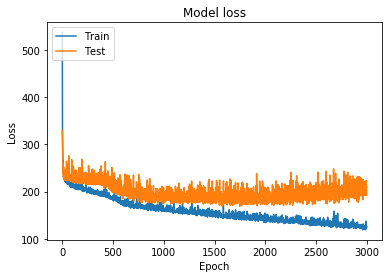

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
y_trained = modeltest_int.predict(X_train)
Train_error = mean_absolute_error(y_train, y_trained)
print('Error on train set:', Train_error)

y_tested = modeltest_int.predict(X_test)
Test_error = mean_absolute_error(y_test, y_tested)
print('Error on test set:', Test_error)

Error on train set: 132.28768657534727
Error on test set: 201.49114507637773


# Set min < max

In [28]:
y_trained = modeltest_int.predict(X_train)
y_trained = pd.DataFrame({'MIN': y_trained[:, 0], 'MAX': y_trained[:, 1]})
y_trained['MIN'] = y_trained['MIN'].where(y_trained['MIN'] <= y_trained['MAX'], y_trained['MAX'])
y_trained = y_trained.round(decimals = 2)
y_trained.head()

,MIN,MAX
0,539.020020,584.119995
1,1498.089966,1540.170044
2,400.980011,437.040009
3,710.270020,743.450012
4,199.369995,199.369995


In [29]:
y_tested = modeltest_int.predict(X_test)
y_tested = pd.DataFrame({'MIN': y_tested[:, 0], 'MAX': y_tested[:, 1]})
y_tested['MIN'] = y_tested['MIN'].where(y_tested['MIN'] <= y_tested['MAX'], y_tested['MAX'])
y_tested = y_tested.round(decimals = 2)
y_tested.head()

,MIN,MAX
0,962.080017,1011.299988
1,262.559998,262.559998
2,1161.160034,1210.229980
3,1413.369995,1458.390015
4,375.600006,406.320007


In [30]:
Train_error = mean_absolute_error(y_train, y_trained.values)
print('Error on train set:', Train_error)

Test_error = mean_absolute_error(y_test, y_tested.values)
print('Error on test set:', Test_error)

Error on train set: 132.25481664171406
Error on test set: 201.0244577325559


# Full training data

In [31]:
train_data_path = path.join(path.pardir, 'train.csv')
train_data = pd.read_csv(train_data_path)
train_data_enigneered = engineer_features(train_data)

X_train, y_train = split_features_targets(train_data_enigneered)

X_train_numerical = X_train[numerical_features]
imputer = KNNImputer(n_neighbors=2)
X_train_numerical = imputer.fit_transform(X_train_numerical)

X_train_boolean = X_train[boolean_features]
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_train_boolean = imputer.fit_transform(X_train_boolean)

X_train = np.hstack((X_train_numerical,X_train_boolean))

In [32]:
modeltest_int = keras.Sequential([
    keras.layers.Dense(13, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2)
])
modeltest_int.compile(optimizer="adam", loss=tf.keras.losses.MeanAbsoluteError(), metrics=["mse"])

In [33]:
history = modeltest_int.fit(X_train, y_train.values, validation_split=0.1, epochs=3000)

Train on 459 samples, validate on 51 samples
Epoch 1/3000
459/459 [==============================] - 1s 2ms/sample - loss: 492.6772 - mse: 454968.1250 - val_loss: 379.0267 - val_mse: 255621.7656
Epoch 2/3000
459/459 [==============================] - 0s 107us/sample - loss: 343.7229 - mse: 212667.5312 - val_loss: 343.8675 - val_mse: 280427.6875
Epoch 3/3000
459/459 [==============================] - 0s 129us/sample - loss: 316.0586 - mse: 211912.1875 - val_loss: 324.3579 - val_mse: 249905.6094
Epoch 4/3000
459/459 [==============================] - 0s 100us/sample - loss: 303.4100 - mse: 195631.1094 - val_loss: 309.5616 - val_mse: 220904.4688
Epoch 5/3000
459/459 [==============================] - 0s 102us/sample - loss: 289.0096 - mse: 175929.8281 - val_loss: 292.0306 - val_mse: 199598.9062
Epoch 6/3000
459/459 [==============================] - 0s 109us/sample - loss: 272.6413 - mse: 161989.6719 - val_loss: 290.9965 - val_mse: 170864.4688
Epoch 7/3000
459/459 [=======================

459/459 [==============================] - 0s 109us/sample - loss: 214.7666 - mse: 112046.3203 - val_loss: 237.1567 - val_mse: 139163.4688
Epoch 55/3000
459/459 [==============================] - 0s 150us/sample - loss: 215.7269 - mse: 114558.4062 - val_loss: 248.3421 - val_mse: 158652.7969
Epoch 56/3000
459/459 [==============================] - 0s 87us/sample - loss: 217.2359 - mse: 115671.6484 - val_loss: 233.9722 - val_mse: 130007.3359
Epoch 57/3000
459/459 [==============================] - 0s 89us/sample - loss: 214.6548 - mse: 113117.4062 - val_loss: 233.6496 - val_mse: 125666.0469
Epoch 58/3000
459/459 [==============================] - 0s 87us/sample - loss: 215.8601 - mse: 115461.1875 - val_loss: 232.5786 - val_mse: 126049.9375
Epoch 59/3000
459/459 [==============================] - 0s 113us/sample - loss: 217.4025 - mse: 114801.6484 - val_loss: 239.8300 - val_mse: 146830.8594
Epoch 60/3000
459/459 [==============================] - 0s 94us/sample - loss: 220.5828 - mse: 112

Epoch 108/3000
459/459 [==============================] - 0s 87us/sample - loss: 216.9692 - mse: 114004.6016 - val_loss: 230.1468 - val_mse: 129544.6875
Epoch 109/3000
459/459 [==============================] - 0s 94us/sample - loss: 216.7372 - mse: 112638.1406 - val_loss: 231.5921 - val_mse: 137614.4844
Epoch 110/3000
459/459 [==============================] - 0s 87us/sample - loss: 218.3907 - mse: 117703.5781 - val_loss: 227.3670 - val_mse: 125615.5859
Epoch 111/3000
459/459 [==============================] - 0s 85us/sample - loss: 210.0529 - mse: 109057.9375 - val_loss: 227.9625 - val_mse: 128098.4141
Epoch 112/3000
459/459 [==============================] - 0s 89us/sample - loss: 208.8156 - mse: 109183.8984 - val_loss: 229.5625 - val_mse: 130849.5625
Epoch 113/3000
459/459 [==============================] - 0s 87us/sample - loss: 207.5205 - mse: 107928.0938 - val_loss: 229.2603 - val_mse: 131154.4531
Epoch 114/3000
459/459 [==============================] - 0s 87us/sample - loss: 2

459/459 [==============================] - 0s 96us/sample - loss: 205.9421 - mse: 105670.2969 - val_loss: 226.0960 - val_mse: 127320.5859
Epoch 162/3000
459/459 [==============================] - 0s 109us/sample - loss: 203.9491 - mse: 107583.4922 - val_loss: 221.7786 - val_mse: 120229.4297
Epoch 163/3000
459/459 [==============================] - 0s 89us/sample - loss: 207.6652 - mse: 108718.8203 - val_loss: 225.4709 - val_mse: 123526.7188
Epoch 164/3000
459/459 [==============================] - 0s 87us/sample - loss: 206.2492 - mse: 105282.6328 - val_loss: 221.5873 - val_mse: 124783.6094
Epoch 165/3000
459/459 [==============================] - 0s 92us/sample - loss: 205.3723 - mse: 105524.4219 - val_loss: 221.0656 - val_mse: 125266.2344
Epoch 166/3000
459/459 [==============================] - 0s 94us/sample - loss: 204.8989 - mse: 107496.6953 - val_loss: 223.6445 - val_mse: 129248.2422
Epoch 167/3000
459/459 [==============================] - 0s 105us/sample - loss: 207.8623 - mse

459/459 [==============================] - 0s 109us/sample - loss: 202.0700 - mse: 104796.3906 - val_loss: 235.6675 - val_mse: 144757.6406
Epoch 215/3000
459/459 [==============================] - 0s 92us/sample - loss: 212.5246 - mse: 110545.1250 - val_loss: 221.3294 - val_mse: 127810.7031
Epoch 216/3000
459/459 [==============================] - 0s 92us/sample - loss: 204.3894 - mse: 105122.5391 - val_loss: 218.3417 - val_mse: 120144.6641
Epoch 217/3000
459/459 [==============================] - 0s 92us/sample - loss: 202.7595 - mse: 105282.5000 - val_loss: 216.8640 - val_mse: 117949.0625
Epoch 218/3000
459/459 [==============================] - 0s 92us/sample - loss: 204.5653 - mse: 106614.8359 - val_loss: 226.4876 - val_mse: 134418.4688
Epoch 219/3000
459/459 [==============================] - 0s 87us/sample - loss: 208.7770 - mse: 107909.7344 - val_loss: 227.2476 - val_mse: 136230.4062
Epoch 220/3000
459/459 [==============================] - 0s 113us/sample - loss: 206.0757 - mse

459/459 [==============================] - 0s 85us/sample - loss: 203.2267 - mse: 106459.7734 - val_loss: 218.3942 - val_mse: 122899.0312
Epoch 268/3000
459/459 [==============================] - 0s 87us/sample - loss: 204.4665 - mse: 103761.0859 - val_loss: 221.2962 - val_mse: 129754.1562
Epoch 269/3000
459/459 [==============================] - 0s 87us/sample - loss: 207.3032 - mse: 107111.7109 - val_loss: 226.4988 - val_mse: 135622.4688
Epoch 270/3000
459/459 [==============================] - 0s 85us/sample - loss: 202.1433 - mse: 106441.6328 - val_loss: 208.1041 - val_mse: 114124.9922
Epoch 271/3000
459/459 [==============================] - 0s 92us/sample - loss: 202.0014 - mse: 104922.9141 - val_loss: 220.0882 - val_mse: 119687.2266
Epoch 272/3000
459/459 [==============================] - 0s 100us/sample - loss: 202.9233 - mse: 106232.6484 - val_loss: 217.6956 - val_mse: 124557.9766
Epoch 273/3000
459/459 [==============================] - 0s 87us/sample - loss: 202.7817 - mse:

459/459 [==============================] - 0s 102us/sample - loss: 200.5677 - mse: 102433.7344 - val_loss: 232.0834 - val_mse: 138063.3594
Epoch 321/3000
459/459 [==============================] - 0s 92us/sample - loss: 205.7143 - mse: 104143.2188 - val_loss: 237.3478 - val_mse: 150396.3906
Epoch 322/3000
459/459 [==============================] - 0s 92us/sample - loss: 207.0219 - mse: 110135.8203 - val_loss: 216.6047 - val_mse: 127641.6484
Epoch 323/3000
459/459 [==============================] - 0s 87us/sample - loss: 206.7238 - mse: 110772.2344 - val_loss: 208.8994 - val_mse: 112733.1797
Epoch 324/3000
459/459 [==============================] - 0s 87us/sample - loss: 200.4318 - mse: 102283.7422 - val_loss: 215.2202 - val_mse: 114687.1016
Epoch 325/3000
459/459 [==============================] - 0s 89us/sample - loss: 200.4712 - mse: 102548.6172 - val_loss: 210.5997 - val_mse: 118527.2031
Epoch 326/3000
459/459 [==============================] - 0s 120us/sample - loss: 206.0425 - mse

459/459 [==============================] - 0s 116us/sample - loss: 197.6832 - mse: 100159.5625 - val_loss: 211.6395 - val_mse: 118360.7031
Epoch 374/3000
459/459 [==============================] - 0s 94us/sample - loss: 198.2184 - mse: 101166.7266 - val_loss: 209.0492 - val_mse: 114850.7266
Epoch 375/3000
459/459 [==============================] - 0s 92us/sample - loss: 195.4798 - mse: 98367.6797 - val_loss: 211.6008 - val_mse: 110045.8047
Epoch 376/3000
459/459 [==============================] - 0s 100us/sample - loss: 199.1433 - mse: 104156.6875 - val_loss: 210.0889 - val_mse: 114941.1406
Epoch 377/3000
459/459 [==============================] - 0s 94us/sample - loss: 196.2470 - mse: 100581.2969 - val_loss: 206.4196 - val_mse: 110333.9375
Epoch 378/3000
459/459 [==============================] - 0s 92us/sample - loss: 196.4158 - mse: 99892.5547 - val_loss: 209.7402 - val_mse: 115449.3906
Epoch 379/3000
459/459 [==============================] - 0s 89us/sample - loss: 197.1222 - mse: 

Epoch 427/3000
459/459 [==============================] - 0s 135us/sample - loss: 192.6597 - mse: 98552.7500 - val_loss: 202.7709 - val_mse: 109694.4688
Epoch 428/3000
459/459 [==============================] - 0s 89us/sample - loss: 198.5729 - mse: 101814.9219 - val_loss: 202.1658 - val_mse: 107495.2188
Epoch 429/3000
459/459 [==============================] - 0s 92us/sample - loss: 193.6523 - mse: 95746.4375 - val_loss: 201.0350 - val_mse: 108317.1953
Epoch 430/3000
459/459 [==============================] - 0s 92us/sample - loss: 193.9209 - mse: 97323.5234 - val_loss: 203.5563 - val_mse: 109958.8828
Epoch 431/3000
459/459 [==============================] - 0s 118us/sample - loss: 196.0797 - mse: 100051.6250 - val_loss: 199.3729 - val_mse: 109007.3906
Epoch 432/3000
459/459 [==============================] - 0s 94us/sample - loss: 192.4303 - mse: 96570.8672 - val_loss: 202.4170 - val_mse: 107946.6094
Epoch 433/3000
459/459 [==============================] - 0s 96us/sample - loss: 194

Epoch 481/3000
459/459 [==============================] - 0s 111us/sample - loss: 194.3707 - mse: 97579.8516 - val_loss: 198.7433 - val_mse: 105000.7969
Epoch 482/3000
459/459 [==============================] - 0s 111us/sample - loss: 195.7693 - mse: 95630.5547 - val_loss: 200.9847 - val_mse: 110089.2812
Epoch 483/3000
459/459 [==============================] - 0s 89us/sample - loss: 192.4816 - mse: 96875.4922 - val_loss: 196.1361 - val_mse: 104691.4141
Epoch 484/3000
459/459 [==============================] - 0s 94us/sample - loss: 193.5994 - mse: 95663.5156 - val_loss: 196.7019 - val_mse: 104813.0781
Epoch 485/3000
459/459 [==============================] - 0s 87us/sample - loss: 192.4308 - mse: 95369.1016 - val_loss: 207.4128 - val_mse: 115600.1641
Epoch 486/3000
459/459 [==============================] - 0s 92us/sample - loss: 197.2641 - mse: 97603.0078 - val_loss: 211.7793 - val_mse: 118348.6172
Epoch 487/3000
459/459 [==============================] - 0s 87us/sample - loss: 197.9

459/459 [==============================] - 0s 105us/sample - loss: 189.5583 - mse: 93305.1797 - val_loss: 193.0699 - val_mse: 101348.8594
Epoch 535/3000
459/459 [==============================] - 0s 89us/sample - loss: 188.4191 - mse: 93242.9922 - val_loss: 185.9845 - val_mse: 94912.6250
Epoch 536/3000
459/459 [==============================] - 0s 89us/sample - loss: 189.6932 - mse: 94175.6406 - val_loss: 193.6717 - val_mse: 102364.2578
Epoch 537/3000
459/459 [==============================] - 0s 87us/sample - loss: 186.5541 - mse: 91941.1641 - val_loss: 183.0497 - val_mse: 94272.8828
Epoch 538/3000
459/459 [==============================] - 0s 94us/sample - loss: 187.8568 - mse: 90655.0312 - val_loss: 194.4012 - val_mse: 107297.5312
Epoch 539/3000
459/459 [==============================] - 0s 87us/sample - loss: 191.4105 - mse: 94631.2031 - val_loss: 193.4058 - val_mse: 102407.0391
Epoch 540/3000
459/459 [==============================] - 0s 87us/sample - loss: 185.6283 - mse: 90126.6

459/459 [==============================] - 0s 85us/sample - loss: 187.3094 - mse: 89911.1250 - val_loss: 183.5886 - val_mse: 92208.7031
Epoch 589/3000
459/459 [==============================] - 0s 87us/sample - loss: 186.3567 - mse: 89337.2734 - val_loss: 187.2344 - val_mse: 95016.3516
Epoch 590/3000
459/459 [==============================] - 0s 105us/sample - loss: 189.0954 - mse: 89688.9219 - val_loss: 194.1911 - val_mse: 105797.6641
Epoch 591/3000
459/459 [==============================] - 0s 92us/sample - loss: 196.6245 - mse: 93878.6094 - val_loss: 201.0087 - val_mse: 118054.1406
Epoch 592/3000
459/459 [==============================] - 0s 85us/sample - loss: 191.0458 - mse: 91512.1953 - val_loss: 182.0779 - val_mse: 91073.3516
Epoch 593/3000
459/459 [==============================] - 0s 92us/sample - loss: 188.8270 - mse: 92352.4375 - val_loss: 206.4735 - val_mse: 94206.8203
Epoch 594/3000
459/459 [==============================] - 0s 92us/sample - loss: 185.3570 - mse: 87084.539

459/459 [==============================] - 0s 109us/sample - loss: 182.2991 - mse: 86290.3359 - val_loss: 177.9382 - val_mse: 79987.7891
Epoch 643/3000
459/459 [==============================] - 0s 87us/sample - loss: 181.2690 - mse: 85774.1719 - val_loss: 176.0470 - val_mse: 82419.3516
Epoch 644/3000
459/459 [==============================] - 0s 92us/sample - loss: 180.7987 - mse: 84082.5625 - val_loss: 176.0130 - val_mse: 87630.7344
Epoch 645/3000
459/459 [==============================] - 0s 89us/sample - loss: 182.1124 - mse: 84998.6562 - val_loss: 188.5302 - val_mse: 105414.4219
Epoch 646/3000
459/459 [==============================] - 0s 92us/sample - loss: 189.4410 - mse: 93580.5781 - val_loss: 175.0010 - val_mse: 93563.7266
Epoch 647/3000
459/459 [==============================] - 0s 92us/sample - loss: 183.8715 - mse: 84385.0469 - val_loss: 179.3453 - val_mse: 86042.7266
Epoch 648/3000
459/459 [==============================] - 0s 96us/sample - loss: 182.9222 - mse: 87229.2109

Epoch 696/3000
459/459 [==============================] - 0s 111us/sample - loss: 186.7954 - mse: 86231.4219 - val_loss: 171.6074 - val_mse: 88661.8828
Epoch 697/3000
459/459 [==============================] - 0s 92us/sample - loss: 177.7651 - mse: 82474.4688 - val_loss: 181.2906 - val_mse: 78157.0938
Epoch 698/3000
459/459 [==============================] - 0s 102us/sample - loss: 179.4557 - mse: 83789.2578 - val_loss: 172.6846 - val_mse: 76967.0234
Epoch 699/3000
459/459 [==============================] - 0s 111us/sample - loss: 180.0716 - mse: 82902.7656 - val_loss: 172.1408 - val_mse: 84821.3906
Epoch 700/3000
459/459 [==============================] - 0s 96us/sample - loss: 182.6295 - mse: 83689.3828 - val_loss: 170.0179 - val_mse: 90134.1797
Epoch 701/3000
459/459 [==============================] - 0s 92us/sample - loss: 179.5714 - mse: 81528.8203 - val_loss: 172.7026 - val_mse: 91039.8359
Epoch 702/3000
459/459 [==============================] - 0s 87us/sample - loss: 185.4222 -

459/459 [==============================] - 0s 105us/sample - loss: 175.9000 - mse: 84497.4062 - val_loss: 166.5028 - val_mse: 73433.6641
Epoch 751/3000
459/459 [==============================] - 0s 98us/sample - loss: 177.7613 - mse: 81809.7188 - val_loss: 170.0873 - val_mse: 83876.8828
Epoch 752/3000
459/459 [==============================] - 0s 94us/sample - loss: 181.4528 - mse: 82188.4297 - val_loss: 170.8468 - val_mse: 93277.8359
Epoch 753/3000
459/459 [==============================] - 0s 92us/sample - loss: 175.4189 - mse: 81297.8672 - val_loss: 171.8479 - val_mse: 76494.6562
Epoch 754/3000
459/459 [==============================] - ETA: 0s - loss: 162.6380 - mse: 63175.714 - 0s 89us/sample - loss: 177.6092 - mse: 84032.2344 - val_loss: 169.5722 - val_mse: 83934.3438
Epoch 755/3000
459/459 [==============================] - 0s 92us/sample - loss: 175.2495 - mse: 78701.0547 - val_loss: 171.6434 - val_mse: 89513.2344
Epoch 756/3000
459/459 [==============================] - 0s 96u

Epoch 804/3000
459/459 [==============================] - 0s 96us/sample - loss: 173.7798 - mse: 81440.7344 - val_loss: 169.7414 - val_mse: 73836.0000
Epoch 805/3000
459/459 [==============================] - 0s 92us/sample - loss: 172.7661 - mse: 77727.7422 - val_loss: 175.3418 - val_mse: 72672.7891
Epoch 806/3000
459/459 [==============================] - 0s 96us/sample - loss: 173.6847 - mse: 80496.9922 - val_loss: 175.4474 - val_mse: 73600.4531
Epoch 807/3000
459/459 [==============================] - 0s 94us/sample - loss: 182.5603 - mse: 87896.4844 - val_loss: 207.2223 - val_mse: 82874.3516
Epoch 808/3000
459/459 [==============================] - 0s 107us/sample - loss: 182.4867 - mse: 85397.5625 - val_loss: 178.2008 - val_mse: 75063.1875
Epoch 809/3000
459/459 [==============================] - 0s 94us/sample - loss: 174.5658 - mse: 80868.5938 - val_loss: 168.2567 - val_mse: 77845.0312
Epoch 810/3000
459/459 [==============================] - 0s 100us/sample - loss: 172.4699 - 

Epoch 858/3000
459/459 [==============================] - 0s 94us/sample - loss: 172.0347 - mse: 77934.4922 - val_loss: 169.3638 - val_mse: 73549.4844
Epoch 859/3000
459/459 [==============================] - 0s 89us/sample - loss: 173.0642 - mse: 77876.2734 - val_loss: 162.6769 - val_mse: 78459.7812
Epoch 860/3000
459/459 [==============================] - 0s 89us/sample - loss: 175.4857 - mse: 80703.5312 - val_loss: 164.5555 - val_mse: 79357.0156
Epoch 861/3000
459/459 [==============================] - 0s 107us/sample - loss: 170.9586 - mse: 79676.7109 - val_loss: 180.8406 - val_mse: 72371.7578
Epoch 862/3000
459/459 [==============================] - 0s 100us/sample - loss: 172.7639 - mse: 77928.8516 - val_loss: 164.1537 - val_mse: 67370.6250
Epoch 863/3000
459/459 [==============================] - 0s 96us/sample - loss: 176.2557 - mse: 79640.1562 - val_loss: 164.5317 - val_mse: 81130.5312
Epoch 864/3000
459/459 [==============================] - 0s 94us/sample - loss: 172.7518 - 

459/459 [==============================] - 0s 94us/sample - loss: 172.8717 - mse: 75729.2500 - val_loss: 164.1266 - val_mse: 79207.0469
Epoch 913/3000
459/459 [==============================] - 0s 153us/sample - loss: 170.5056 - mse: 77217.5625 - val_loss: 164.2109 - val_mse: 76621.5234
Epoch 914/3000
459/459 [==============================] - 0s 111us/sample - loss: 171.2907 - mse: 77357.3750 - val_loss: 162.9070 - val_mse: 82194.4297
Epoch 915/3000
459/459 [==============================] - 0s 118us/sample - loss: 172.5654 - mse: 79827.0312 - val_loss: 169.8347 - val_mse: 70878.1016
Epoch 916/3000
459/459 [==============================] - 0s 94us/sample - loss: 178.9665 - mse: 79189.7422 - val_loss: 165.4376 - val_mse: 73349.6016
Epoch 917/3000
459/459 [==============================] - 0s 87us/sample - loss: 172.7193 - mse: 81974.5547 - val_loss: 164.5191 - val_mse: 88607.9609
Epoch 918/3000
459/459 [==============================] - 0s 92us/sample - loss: 171.8087 - mse: 78378.671

459/459 [==============================] - 0s 142us/sample - loss: 169.1718 - mse: 75633.8438 - val_loss: 164.1408 - val_mse: 78160.2734
Epoch 967/3000
459/459 [==============================] - 0s 142us/sample - loss: 167.7407 - mse: 77114.1719 - val_loss: 161.5569 - val_mse: 71937.2422
Epoch 968/3000
459/459 [==============================] - 0s 168us/sample - loss: 169.8051 - mse: 79085.6797 - val_loss: 170.8651 - val_mse: 66856.4844
Epoch 969/3000
459/459 [==============================] - 0s 133us/sample - loss: 169.2002 - mse: 75771.8516 - val_loss: 168.5592 - val_mse: 75768.9453
Epoch 970/3000
459/459 [==============================] - 0s 107us/sample - loss: 169.0852 - mse: 76385.9609 - val_loss: 170.3166 - val_mse: 76058.8828
Epoch 971/3000
459/459 [==============================] - 0s 120us/sample - loss: 176.7035 - mse: 84560.2344 - val_loss: 173.6116 - val_mse: 72619.2188
Epoch 972/3000
459/459 [==============================] - 0s 129us/sample - loss: 177.8724 - mse: 85183

459/459 [==============================] - 0s 89us/sample - loss: 174.3511 - mse: 80555.7188 - val_loss: 160.8018 - val_mse: 77730.5625
Epoch 1021/3000
459/459 [==============================] - 0s 87us/sample - loss: 169.2112 - mse: 78609.5078 - val_loss: 171.8338 - val_mse: 73793.4688
Epoch 1022/3000
459/459 [==============================] - 0s 92us/sample - loss: 167.5686 - mse: 74249.6641 - val_loss: 160.5402 - val_mse: 68292.4297
Epoch 1023/3000
459/459 [==============================] - 0s 100us/sample - loss: 164.3646 - mse: 73800.0703 - val_loss: 166.0820 - val_mse: 73493.7344
Epoch 1024/3000
459/459 [==============================] - 0s 105us/sample - loss: 169.2169 - mse: 78192.0859 - val_loss: 168.8653 - val_mse: 67216.6250
Epoch 1025/3000
459/459 [==============================] - 0s 113us/sample - loss: 169.4347 - mse: 76884.1016 - val_loss: 162.1569 - val_mse: 68953.9297
Epoch 1026/3000
459/459 [==============================] - 0s 116us/sample - loss: 165.2124 - mse: 74

Epoch 1074/3000
459/459 [==============================] - 0s 96us/sample - loss: 165.5173 - mse: 75611.0703 - val_loss: 163.3697 - val_mse: 69644.1328
Epoch 1075/3000
459/459 [==============================] - 0s 96us/sample - loss: 164.8052 - mse: 72378.9688 - val_loss: 163.0780 - val_mse: 67171.5625
Epoch 1076/3000
459/459 [==============================] - 0s 87us/sample - loss: 165.2167 - mse: 75011.9922 - val_loss: 157.7758 - val_mse: 76596.8594
Epoch 1077/3000
459/459 [==============================] - 0s 89us/sample - loss: 164.4599 - mse: 74254.2422 - val_loss: 155.9819 - val_mse: 69336.3359
Epoch 1078/3000
459/459 [==============================] - 0s 96us/sample - loss: 166.0158 - mse: 75121.2734 - val_loss: 169.6834 - val_mse: 75359.9297
Epoch 1079/3000
459/459 [==============================] - 0s 96us/sample - loss: 166.5884 - mse: 75840.4297 - val_loss: 173.0022 - val_mse: 76951.3125
Epoch 1080/3000
459/459 [==============================] - 0s 92us/sample - loss: 171.92

459/459 [==============================] - 0s 96us/sample - loss: 173.2304 - mse: 78461.4766 - val_loss: 174.2274 - val_mse: 71037.7812
Epoch 1128/3000
459/459 [==============================] - 0s 92us/sample - loss: 163.2032 - mse: 72058.7891 - val_loss: 156.6610 - val_mse: 72772.1328
Epoch 1129/3000
459/459 [==============================] - 0s 96us/sample - loss: 163.9264 - mse: 71936.5859 - val_loss: 178.2883 - val_mse: 65316.1719
Epoch 1130/3000
459/459 [==============================] - 0s 116us/sample - loss: 168.8540 - mse: 74268.7578 - val_loss: 160.0742 - val_mse: 72618.9297
Epoch 1131/3000
459/459 [==============================] - 0s 92us/sample - loss: 165.7720 - mse: 74477.1562 - val_loss: 169.2549 - val_mse: 71296.3594
Epoch 1132/3000
459/459 [==============================] - 0s 96us/sample - loss: 167.0888 - mse: 74526.9688 - val_loss: 156.9247 - val_mse: 80911.0703
Epoch 1133/3000
459/459 [==============================] - 0s 92us/sample - loss: 167.1486 - mse: 75228

Epoch 1181/3000
459/459 [==============================] - 0s 92us/sample - loss: 162.7313 - mse: 69807.1875 - val_loss: 160.0233 - val_mse: 70579.9062
Epoch 1182/3000
459/459 [==============================] - 0s 89us/sample - loss: 162.5991 - mse: 72327.7891 - val_loss: 163.0484 - val_mse: 72438.4375
Epoch 1183/3000
459/459 [==============================] - 0s 94us/sample - loss: 171.3091 - mse: 77966.0547 - val_loss: 171.2726 - val_mse: 69588.2031
Epoch 1184/3000
459/459 [==============================] - 0s 92us/sample - loss: 162.6636 - mse: 70525.9688 - val_loss: 165.6555 - val_mse: 75399.5312
Epoch 1185/3000
459/459 [==============================] - 0s 94us/sample - loss: 160.2595 - mse: 71636.6406 - val_loss: 159.3012 - val_mse: 68264.2188
Epoch 1186/3000
459/459 [==============================] - 0s 89us/sample - loss: 158.4462 - mse: 69425.4844 - val_loss: 153.5801 - val_mse: 80556.8438
Epoch 1187/3000
459/459 [==============================] - 0s 94us/sample - loss: 165.74

Epoch 1235/3000
459/459 [==============================] - 0s 105us/sample - loss: 159.9161 - mse: 68873.3672 - val_loss: 162.7984 - val_mse: 74190.9688
Epoch 1236/3000
459/459 [==============================] - 0s 92us/sample - loss: 158.1078 - mse: 70020.3984 - val_loss: 163.3766 - val_mse: 81554.5078
Epoch 1237/3000
459/459 [==============================] - 0s 89us/sample - loss: 160.3121 - mse: 68491.1562 - val_loss: 168.6608 - val_mse: 66855.3906
Epoch 1238/3000
459/459 [==============================] - 0s 98us/sample - loss: 163.4632 - mse: 72940.3828 - val_loss: 157.3759 - val_mse: 65821.8125
Epoch 1239/3000
459/459 [==============================] - 0s 89us/sample - loss: 162.0569 - mse: 68470.1484 - val_loss: 171.2453 - val_mse: 71255.7812
Epoch 1240/3000
459/459 [==============================] - 0s 92us/sample - loss: 158.4921 - mse: 72119.8359 - val_loss: 185.4945 - val_mse: 75838.9453
Epoch 1241/3000
459/459 [==============================] - 0s 89us/sample - loss: 165.9

Epoch 1289/3000
459/459 [==============================] - 0s 98us/sample - loss: 162.8720 - mse: 71751.2656 - val_loss: 164.0871 - val_mse: 75048.6719
Epoch 1290/3000
459/459 [==============================] - 0s 87us/sample - loss: 160.7783 - mse: 69520.1562 - val_loss: 163.1153 - val_mse: 69052.0625
Epoch 1291/3000
459/459 [==============================] - 0s 94us/sample - loss: 159.9939 - mse: 69252.5391 - val_loss: 156.4413 - val_mse: 72637.0078
Epoch 1292/3000
459/459 [==============================] - 0s 92us/sample - loss: 160.0263 - mse: 68743.2891 - val_loss: 160.8301 - val_mse: 78134.1250
Epoch 1293/3000
459/459 [==============================] - 0s 94us/sample - loss: 162.8566 - mse: 72044.0234 - val_loss: 165.9116 - val_mse: 70958.0703
Epoch 1294/3000
459/459 [==============================] - 0s 105us/sample - loss: 165.9610 - mse: 71939.7656 - val_loss: 177.3890 - val_mse: 67275.2344
Epoch 1295/3000
459/459 [==============================] - 0s 94us/sample - loss: 161.5

Epoch 1343/3000
459/459 [==============================] - 0s 135us/sample - loss: 158.9104 - mse: 68055.7344 - val_loss: 153.9191 - val_mse: 70885.0859
Epoch 1344/3000
459/459 [==============================] - 0s 148us/sample - loss: 161.4414 - mse: 68981.9375 - val_loss: 156.7706 - val_mse: 77356.2969
Epoch 1345/3000
459/459 [==============================] - 0s 102us/sample - loss: 164.7872 - mse: 71484.0938 - val_loss: 169.7942 - val_mse: 74725.6797
Epoch 1346/3000
459/459 [==============================] - 0s 92us/sample - loss: 155.1895 - mse: 64668.1172 - val_loss: 166.5265 - val_mse: 62185.2188
Epoch 1347/3000
459/459 [==============================] - 0s 92us/sample - loss: 160.8484 - mse: 67114.3438 - val_loss: 163.4157 - val_mse: 68572.5391
Epoch 1348/3000
459/459 [==============================] - 0s 89us/sample - loss: 157.5361 - mse: 66158.7422 - val_loss: 155.6416 - val_mse: 70897.6641
Epoch 1349/3000
459/459 [==============================] - 0s 89us/sample - loss: 157

Epoch 1397/3000
459/459 [==============================] - 0s 102us/sample - loss: 164.1364 - mse: 71097.0625 - val_loss: 165.2472 - val_mse: 77887.5859
Epoch 1398/3000
459/459 [==============================] - 0s 102us/sample - loss: 163.4040 - mse: 70333.4609 - val_loss: 167.7338 - val_mse: 77003.9062
Epoch 1399/3000
459/459 [==============================] - 0s 102us/sample - loss: 158.6987 - mse: 66417.8594 - val_loss: 176.4941 - val_mse: 73668.8359
Epoch 1400/3000
459/459 [==============================] - 0s 113us/sample - loss: 156.7325 - mse: 65749.0078 - val_loss: 153.2393 - val_mse: 71761.6562
Epoch 1401/3000
459/459 [==============================] - 0s 98us/sample - loss: 157.0499 - mse: 66546.1719 - val_loss: 178.2415 - val_mse: 79898.5312
Epoch 1402/3000
459/459 [==============================] - 0s 105us/sample - loss: 163.6634 - mse: 72196.6094 - val_loss: 177.2665 - val_mse: 73407.2812
Epoch 1403/3000
459/459 [==============================] - 0s 105us/sample - loss: 

Epoch 1451/3000
459/459 [==============================] - 0s 89us/sample - loss: 151.7612 - mse: 62282.9844 - val_loss: 161.5798 - val_mse: 65319.3203
Epoch 1452/3000
459/459 [==============================] - 0s 100us/sample - loss: 154.8122 - mse: 65188.2891 - val_loss: 171.8256 - val_mse: 67920.6797
Epoch 1453/3000
459/459 [==============================] - 0s 89us/sample - loss: 155.1903 - mse: 62242.5156 - val_loss: 173.1425 - val_mse: 67998.8438
Epoch 1454/3000
459/459 [==============================] - 0s 94us/sample - loss: 157.7072 - mse: 65328.3320 - val_loss: 163.3546 - val_mse: 70075.3516
Epoch 1455/3000
459/459 [==============================] - 0s 92us/sample - loss: 157.1807 - mse: 66118.7812 - val_loss: 167.4576 - val_mse: 71504.4922
Epoch 1456/3000
459/459 [==============================] - 0s 87us/sample - loss: 152.4165 - mse: 62788.1562 - val_loss: 160.3456 - val_mse: 69348.3359
Epoch 1457/3000
459/459 [==============================] - 0s 89us/sample - loss: 153.9

459/459 [==============================] - 0s 94us/sample - loss: 155.0774 - mse: 62800.5664 - val_loss: 155.4283 - val_mse: 67819.4141
Epoch 1505/3000
459/459 [==============================] - 0s 89us/sample - loss: 152.3145 - mse: 62122.6484 - val_loss: 168.7183 - val_mse: 70972.4375
Epoch 1506/3000
459/459 [==============================] - 0s 92us/sample - loss: 151.5483 - mse: 63157.5898 - val_loss: 173.0177 - val_mse: 71660.6562
Epoch 1507/3000
459/459 [==============================] - 0s 98us/sample - loss: 153.1906 - mse: 62499.1094 - val_loss: 153.3217 - val_mse: 64247.3320
Epoch 1508/3000
459/459 [==============================] - 0s 89us/sample - loss: 152.7316 - mse: 62295.6562 - val_loss: 168.6146 - val_mse: 65433.2891
Epoch 1509/3000
459/459 [==============================] - 0s 89us/sample - loss: 152.6368 - mse: 60312.9531 - val_loss: 170.7567 - val_mse: 71097.1562
Epoch 1510/3000
459/459 [==============================] - 0s 87us/sample - loss: 153.9252 - mse: 64326.

Epoch 1558/3000
459/459 [==============================] - 0s 92us/sample - loss: 150.4016 - mse: 61982.3828 - val_loss: 178.1278 - val_mse: 68507.7031
Epoch 1559/3000
459/459 [==============================] - 0s 89us/sample - loss: 151.1945 - mse: 60337.8945 - val_loss: 172.6964 - val_mse: 66785.5859
Epoch 1560/3000
459/459 [==============================] - 0s 87us/sample - loss: 156.5311 - mse: 64146.2227 - val_loss: 158.9432 - val_mse: 59274.4023
Epoch 1561/3000
459/459 [==============================] - 0s 98us/sample - loss: 147.3093 - mse: 58700.0352 - val_loss: 163.0327 - val_mse: 85915.7031
Epoch 1562/3000
459/459 [==============================] - 0s 98us/sample - loss: 166.3119 - mse: 68097.6328 - val_loss: 152.5545 - val_mse: 63931.9102
Epoch 1563/3000
459/459 [==============================] - 0s 89us/sample - loss: 161.6099 - mse: 69201.7031 - val_loss: 164.6158 - val_mse: 69391.9453
Epoch 1564/3000
459/459 [==============================] - 0s 92us/sample - loss: 158.01

Epoch 1612/3000
459/459 [==============================] - 0s 87us/sample - loss: 169.6268 - mse: 70372.7344 - val_loss: 156.7742 - val_mse: 80760.5703
Epoch 1613/3000
459/459 [==============================] - 0s 92us/sample - loss: 155.2772 - mse: 64198.9492 - val_loss: 167.0642 - val_mse: 85530.1875
Epoch 1614/3000
459/459 [==============================] - 0s 89us/sample - loss: 151.2844 - mse: 62288.3789 - val_loss: 152.0406 - val_mse: 64735.3398
Epoch 1615/3000
459/459 [==============================] - 0s 89us/sample - loss: 148.4884 - mse: 60418.4648 - val_loss: 159.4828 - val_mse: 67444.0469
Epoch 1616/3000
459/459 [==============================] - 0s 87us/sample - loss: 150.1536 - mse: 60284.9688 - val_loss: 163.6992 - val_mse: 80135.8906
Epoch 1617/3000
459/459 [==============================] - 0s 89us/sample - loss: 151.8788 - mse: 63706.3164 - val_loss: 181.0026 - val_mse: 77345.4922
Epoch 1618/3000
459/459 [==============================] - 0s 89us/sample - loss: 149.44

Epoch 1666/3000
459/459 [==============================] - 0s 100us/sample - loss: 160.7967 - mse: 66503.9531 - val_loss: 188.7308 - val_mse: 73894.7344
Epoch 1667/3000
459/459 [==============================] - 0s 92us/sample - loss: 155.3369 - mse: 63414.9219 - val_loss: 175.7782 - val_mse: 73732.5703
Epoch 1668/3000
459/459 [==============================] - 0s 100us/sample - loss: 149.8434 - mse: 62021.7969 - val_loss: 173.4353 - val_mse: 76894.0312
Epoch 1669/3000
459/459 [==============================] - 0s 89us/sample - loss: 150.1323 - mse: 60511.8750 - val_loss: 172.3790 - val_mse: 69236.3359
Epoch 1670/3000
459/459 [==============================] - 0s 92us/sample - loss: 147.2620 - mse: 61693.4219 - val_loss: 178.6745 - val_mse: 77998.1016
Epoch 1671/3000
459/459 [==============================] - 0s 85us/sample - loss: 152.0561 - mse: 61346.4062 - val_loss: 159.0785 - val_mse: 70516.4766
Epoch 1672/3000
459/459 [==============================] - 0s 87us/sample - loss: 144.

Epoch 1720/3000
459/459 [==============================] - 0s 105us/sample - loss: 147.4362 - mse: 58597.0508 - val_loss: 155.4197 - val_mse: 65530.8125
Epoch 1721/3000
459/459 [==============================] - 0s 113us/sample - loss: 144.9890 - mse: 55996.4414 - val_loss: 165.0104 - val_mse: 71591.9922
Epoch 1722/3000
459/459 [==============================] - 0s 124us/sample - loss: 147.7231 - mse: 60854.5898 - val_loss: 161.1848 - val_mse: 73828.9062
Epoch 1723/3000
459/459 [==============================] - 0s 105us/sample - loss: 148.9845 - mse: 60739.4062 - val_loss: 159.9859 - val_mse: 69556.5859
Epoch 1724/3000
459/459 [==============================] - 0s 120us/sample - loss: 144.1568 - mse: 58047.3906 - val_loss: 157.0654 - val_mse: 65128.6680
Epoch 1725/3000
459/459 [==============================] - 0s 100us/sample - loss: 146.9304 - mse: 57689.8477 - val_loss: 153.4948 - val_mse: 67256.7422
Epoch 1726/3000
459/459 [==============================] - 0s 100us/sample - loss:

459/459 [==============================] - 0s 122us/sample - loss: 145.2664 - mse: 57580.4297 - val_loss: 170.9043 - val_mse: 71676.7969
Epoch 1774/3000
459/459 [==============================] - 0s 111us/sample - loss: 143.7001 - mse: 57814.7812 - val_loss: 169.1813 - val_mse: 70464.6484
Epoch 1775/3000
459/459 [==============================] - 0s 133us/sample - loss: 143.1791 - mse: 57494.9297 - val_loss: 176.1203 - val_mse: 70769.7734
Epoch 1776/3000
459/459 [==============================] - 0s 118us/sample - loss: 144.3680 - mse: 56680.9062 - val_loss: 160.8171 - val_mse: 80016.3594
Epoch 1777/3000
459/459 [==============================] - 0s 120us/sample - loss: 155.7494 - mse: 67082.0078 - val_loss: 228.3836 - val_mse: 110366.7656
Epoch 1778/3000
459/459 [==============================] - 0s 297us/sample - loss: 157.8090 - mse: 67451.7500 - val_loss: 189.9211 - val_mse: 69920.7578
Epoch 1779/3000
459/459 [==============================] - 0s 137us/sample - loss: 152.8924 - mse

Epoch 1827/3000
459/459 [==============================] - 0s 94us/sample - loss: 145.4748 - mse: 58106.2969 - val_loss: 156.4226 - val_mse: 74804.4297
Epoch 1828/3000
459/459 [==============================] - 0s 102us/sample - loss: 147.9738 - mse: 60380.8086 - val_loss: 142.5508 - val_mse: 66918.1250
Epoch 1829/3000
459/459 [==============================] - 0s 94us/sample - loss: 146.2510 - mse: 60024.9180 - val_loss: 177.5937 - val_mse: 71384.5859
Epoch 1830/3000
459/459 [==============================] - 0s 94us/sample - loss: 144.3972 - mse: 58676.8359 - val_loss: 164.3864 - val_mse: 67898.5312
Epoch 1831/3000
459/459 [==============================] - 0s 92us/sample - loss: 143.8466 - mse: 58795.4453 - val_loss: 162.6171 - val_mse: 64690.0625
Epoch 1832/3000
459/459 [==============================] - 0s 102us/sample - loss: 146.2957 - mse: 58672.5742 - val_loss: 177.5626 - val_mse: 71061.2500
Epoch 1833/3000
459/459 [==============================] - 0s 100us/sample - loss: 145

459/459 [==============================] - 0s 161us/sample - loss: 140.9348 - mse: 56920.9766 - val_loss: 166.9333 - val_mse: 71434.8125
Epoch 1881/3000
459/459 [==============================] - 0s 166us/sample - loss: 139.8479 - mse: 53889.0859 - val_loss: 161.3806 - val_mse: 77048.1250
Epoch 1882/3000
459/459 [==============================] - 0s 244us/sample - loss: 141.0833 - mse: 56496.8438 - val_loss: 156.7199 - val_mse: 61439.1367
Epoch 1883/3000
459/459 [==============================] - 0s 164us/sample - loss: 143.6434 - mse: 57131.0625 - val_loss: 172.3397 - val_mse: 71795.8203
Epoch 1884/3000
459/459 [==============================] - 0s 159us/sample - loss: 143.1415 - mse: 56630.5000 - val_loss: 152.6603 - val_mse: 63975.5508
Epoch 1885/3000
459/459 [==============================] - 0s 177us/sample - loss: 144.2972 - mse: 58013.7461 - val_loss: 166.4494 - val_mse: 67764.2422
Epoch 1886/3000
459/459 [==============================] - 0s 207us/sample - loss: 145.8720 - mse:

459/459 [==============================] - 0s 201us/sample - loss: 137.8921 - mse: 55251.4766 - val_loss: 164.0545 - val_mse: 78016.7734
Epoch 1934/3000
459/459 [==============================] - 0s 233us/sample - loss: 140.0435 - mse: 56173.2891 - val_loss: 146.9794 - val_mse: 66975.8906
Epoch 1935/3000
459/459 [==============================] - 0s 129us/sample - loss: 140.9848 - mse: 57207.7695 - val_loss: 150.1654 - val_mse: 60313.3125
Epoch 1936/3000
459/459 [==============================] - 0s 129us/sample - loss: 144.2442 - mse: 58866.3125 - val_loss: 152.7309 - val_mse: 64851.4570
Epoch 1937/3000
459/459 [==============================] - 0s 142us/sample - loss: 138.6919 - mse: 54756.1289 - val_loss: 156.5664 - val_mse: 67311.9688
Epoch 1938/3000
459/459 [==============================] - 0s 131us/sample - loss: 135.2845 - mse: 54899.6016 - val_loss: 155.2626 - val_mse: 63806.3516
Epoch 1939/3000
459/459 [==============================] - 0s 133us/sample - loss: 141.5152 - mse:

459/459 [==============================] - 0s 155us/sample - loss: 143.7851 - mse: 56798.5977 - val_loss: 174.4435 - val_mse: 68546.4688
Epoch 1987/3000
459/459 [==============================] - 0s 177us/sample - loss: 150.3489 - mse: 61297.4258 - val_loss: 211.5417 - val_mse: 91228.3516
Epoch 1988/3000
459/459 [==============================] - 0s 257us/sample - loss: 150.4319 - mse: 61126.7852 - val_loss: 167.8589 - val_mse: 70484.3359
Epoch 1989/3000
459/459 [==============================] - 0s 297us/sample - loss: 139.0369 - mse: 53959.8047 - val_loss: 163.8204 - val_mse: 67657.1172
Epoch 1990/3000
459/459 [==============================] - 0s 379us/sample - loss: 139.3986 - mse: 55119.0156 - val_loss: 145.0540 - val_mse: 63508.8047
Epoch 1991/3000
459/459 [==============================] - 0s 447us/sample - loss: 139.1912 - mse: 57179.4023 - val_loss: 171.4983 - val_mse: 75736.6719
Epoch 1992/3000
459/459 [==============================] - 0s 240us/sample - loss: 142.3409 - mse:

459/459 [==============================] - 0s 105us/sample - loss: 138.6223 - mse: 55825.1406 - val_loss: 177.9646 - val_mse: 75144.3438
Epoch 2040/3000
459/459 [==============================] - 0s 124us/sample - loss: 135.4483 - mse: 54318.8594 - val_loss: 168.6878 - val_mse: 72210.0938
Epoch 2041/3000
459/459 [==============================] - 0s 111us/sample - loss: 137.0767 - mse: 54466.7930 - val_loss: 168.0992 - val_mse: 75866.8203
Epoch 2042/3000
459/459 [==============================] - 0s 172us/sample - loss: 135.2472 - mse: 54337.4883 - val_loss: 159.5120 - val_mse: 64978.5039
Epoch 2043/3000
459/459 [==============================] - 0s 227us/sample - loss: 138.8326 - mse: 53460.3633 - val_loss: 175.4115 - val_mse: 79720.1641
Epoch 2044/3000
459/459 [==============================] - 0s 225us/sample - loss: 137.3242 - mse: 54345.3242 - val_loss: 169.1534 - val_mse: 68121.7422
Epoch 2045/3000
459/459 [==============================] - 0s 218us/sample - loss: 137.8028 - mse:

Epoch 2093/3000
459/459 [==============================] - 0s 211us/sample - loss: 144.2120 - mse: 59169.0312 - val_loss: 165.8694 - val_mse: 71429.4297
Epoch 2094/3000
459/459 [==============================] - 0s 142us/sample - loss: 140.1680 - mse: 55290.8828 - val_loss: 164.2396 - val_mse: 79455.9297
Epoch 2095/3000
459/459 [==============================] - 0s 113us/sample - loss: 141.6758 - mse: 57528.5000 - val_loss: 152.9880 - val_mse: 72563.9297
Epoch 2096/3000
459/459 [==============================] - 0s 140us/sample - loss: 139.4181 - mse: 53607.8047 - val_loss: 165.4013 - val_mse: 70819.5859
Epoch 2097/3000
459/459 [==============================] - 0s 98us/sample - loss: 137.9397 - mse: 53812.8555 - val_loss: 181.5011 - val_mse: 74662.7734
Epoch 2098/3000
459/459 [==============================] - 0s 205us/sample - loss: 136.4518 - mse: 53088.6055 - val_loss: 181.1419 - val_mse: 76583.0703
Epoch 2099/3000
459/459 [==============================] - 0s 231us/sample - loss: 

459/459 [==============================] - 0s 198us/sample - loss: 139.7256 - mse: 57240.1953 - val_loss: 180.0064 - val_mse: 70518.6562
Epoch 2147/3000
459/459 [==============================] - 0s 137us/sample - loss: 135.4310 - mse: 53064.6406 - val_loss: 173.0219 - val_mse: 74123.5469
Epoch 2148/3000
459/459 [==============================] - 0s 320us/sample - loss: 135.5092 - mse: 53168.7109 - val_loss: 157.7774 - val_mse: 68314.0703
Epoch 2149/3000
459/459 [==============================] - 0s 172us/sample - loss: 134.6164 - mse: 55548.1094 - val_loss: 185.8503 - val_mse: 86349.3047
Epoch 2150/3000
459/459 [==============================] - 0s 122us/sample - loss: 141.9281 - mse: 57003.7578 - val_loss: 170.5744 - val_mse: 74473.2891
Epoch 2151/3000
459/459 [==============================] - 0s 137us/sample - loss: 138.4111 - mse: 52452.9219 - val_loss: 171.9886 - val_mse: 75770.9375
Epoch 2152/3000
459/459 [==============================] - 0s 168us/sample - loss: 138.2172 - mse:

459/459 [==============================] - 0s 124us/sample - loss: 137.6912 - mse: 55400.9453 - val_loss: 162.3864 - val_mse: 69718.2422
Epoch 2200/3000
459/459 [==============================] - 0s 137us/sample - loss: 133.4108 - mse: 52861.8164 - val_loss: 155.4380 - val_mse: 68414.8125
Epoch 2201/3000
459/459 [==============================] - 0s 105us/sample - loss: 136.5883 - mse: 52869.5000 - val_loss: 183.0618 - val_mse: 83066.1406
Epoch 2202/3000
459/459 [==============================] - 0s 96us/sample - loss: 133.2549 - mse: 52677.2891 - val_loss: 188.6919 - val_mse: 85202.6250
Epoch 2203/3000
459/459 [==============================] - 0s 94us/sample - loss: 137.5035 - mse: 54673.9102 - val_loss: 171.4731 - val_mse: 69869.3828
Epoch 2204/3000
459/459 [==============================] - 0s 102us/sample - loss: 140.7129 - mse: 53855.1914 - val_loss: 157.3694 - val_mse: 79450.2422
Epoch 2205/3000
459/459 [==============================] - 0s 96us/sample - loss: 139.4067 - mse: 54

Epoch 2253/3000
459/459 [==============================] - 0s 133us/sample - loss: 137.5738 - mse: 53009.6094 - val_loss: 159.7942 - val_mse: 67873.1406
Epoch 2254/3000
459/459 [==============================] - 0s 122us/sample - loss: 137.5061 - mse: 52808.5430 - val_loss: 177.2007 - val_mse: 76834.3438
Epoch 2255/3000
459/459 [==============================] - 0s 111us/sample - loss: 130.7838 - mse: 49837.0625 - val_loss: 163.0197 - val_mse: 66886.3125
Epoch 2256/3000
459/459 [==============================] - 0s 142us/sample - loss: 141.7920 - mse: 56093.1094 - val_loss: 179.9493 - val_mse: 83231.5859
Epoch 2257/3000
459/459 [==============================] - 0s 109us/sample - loss: 144.5431 - mse: 56100.8906 - val_loss: 170.2483 - val_mse: 73713.6172
Epoch 2258/3000
459/459 [==============================] - 0s 148us/sample - loss: 150.5976 - mse: 59431.7305 - val_loss: 188.5201 - val_mse: 71781.4219
Epoch 2259/3000
459/459 [==============================] - 0s 185us/sample - loss:

459/459 [==============================] - 0s 129us/sample - loss: 135.0476 - mse: 52964.5898 - val_loss: 162.3039 - val_mse: 71808.4531
Epoch 2307/3000
459/459 [==============================] - 0s 120us/sample - loss: 132.6901 - mse: 51679.1602 - val_loss: 171.5747 - val_mse: 79022.1094
Epoch 2308/3000
459/459 [==============================] - 0s 122us/sample - loss: 131.7797 - mse: 51733.5156 - val_loss: 169.6432 - val_mse: 67726.8438
Epoch 2309/3000
459/459 [==============================] - 0s 148us/sample - loss: 134.8372 - mse: 54452.1914 - val_loss: 186.9242 - val_mse: 88643.9922
Epoch 2310/3000
459/459 [==============================] - 0s 142us/sample - loss: 131.7547 - mse: 51854.8828 - val_loss: 181.1596 - val_mse: 76731.1406
Epoch 2311/3000
459/459 [==============================] - 0s 131us/sample - loss: 139.7266 - mse: 57976.0078 - val_loss: 203.2901 - val_mse: 95796.9609
Epoch 2312/3000
459/459 [==============================] - 0s 164us/sample - loss: 139.7763 - mse:

Epoch 2360/3000
459/459 [==============================] - 0s 157us/sample - loss: 129.9943 - mse: 51713.8555 - val_loss: 178.5641 - val_mse: 79027.6484
Epoch 2361/3000
459/459 [==============================] - 0s 131us/sample - loss: 128.6188 - mse: 50328.2617 - val_loss: 171.8926 - val_mse: 73816.0859
Epoch 2362/3000
459/459 [==============================] - 0s 144us/sample - loss: 132.9524 - mse: 51888.2500 - val_loss: 162.5601 - val_mse: 75030.5469
Epoch 2363/3000
459/459 [==============================] - 0s 129us/sample - loss: 129.3149 - mse: 51270.5703 - val_loss: 157.3355 - val_mse: 63448.5938
Epoch 2364/3000
459/459 [==============================] - 0s 142us/sample - loss: 127.7468 - mse: 50521.3633 - val_loss: 179.8855 - val_mse: 82264.4141
Epoch 2365/3000
459/459 [==============================] - 0s 168us/sample - loss: 133.6903 - mse: 52847.7148 - val_loss: 174.9699 - val_mse: 82561.0078
Epoch 2366/3000
459/459 [==============================] - 0s 133us/sample - loss:

459/459 [==============================] - 0s 201us/sample - loss: 133.7224 - mse: 52628.4219 - val_loss: 158.2376 - val_mse: 72300.3047
Epoch 2414/3000
459/459 [==============================] - 0s 131us/sample - loss: 130.9921 - mse: 49661.1094 - val_loss: 180.1937 - val_mse: 83351.1172
Epoch 2415/3000
459/459 [==============================] - 0s 146us/sample - loss: 130.5845 - mse: 52282.9297 - val_loss: 167.3585 - val_mse: 73106.5625
Epoch 2416/3000
459/459 [==============================] - 0s 122us/sample - loss: 132.3287 - mse: 49247.2227 - val_loss: 176.6247 - val_mse: 75427.4375
Epoch 2417/3000
459/459 [==============================] - 0s 122us/sample - loss: 127.9324 - mse: 47999.3516 - val_loss: 178.2524 - val_mse: 75243.1406
Epoch 2418/3000
459/459 [==============================] - 0s 129us/sample - loss: 131.6554 - mse: 50225.2617 - val_loss: 168.7031 - val_mse: 77451.3359
Epoch 2419/3000
459/459 [==============================] - 0s 126us/sample - loss: 131.7505 - mse:

459/459 [==============================] - 0s 133us/sample - loss: 126.3980 - mse: 50513.0234 - val_loss: 173.7771 - val_mse: 77275.8203
Epoch 2467/3000
459/459 [==============================] - 0s 131us/sample - loss: 130.0054 - mse: 51502.6328 - val_loss: 180.3260 - val_mse: 82608.2969
Epoch 2468/3000
459/459 [==============================] - 0s 131us/sample - loss: 129.3963 - mse: 49188.3281 - val_loss: 185.0131 - val_mse: 85589.2422
Epoch 2469/3000
459/459 [==============================] - 0s 133us/sample - loss: 127.1937 - mse: 49508.1602 - val_loss: 161.0481 - val_mse: 69100.5781
Epoch 2470/3000
459/459 [==============================] - 0s 133us/sample - loss: 124.0984 - mse: 48231.3359 - val_loss: 181.1195 - val_mse: 77513.8750
Epoch 2471/3000
459/459 [==============================] - 0s 118us/sample - loss: 128.3653 - mse: 49141.6016 - val_loss: 169.1586 - val_mse: 80894.7812
Epoch 2472/3000
459/459 [==============================] - 0s 120us/sample - loss: 136.7264 - mse:

459/459 [==============================] - 0s 227us/sample - loss: 130.6274 - mse: 52385.6602 - val_loss: 179.3340 - val_mse: 84889.6641
Epoch 2520/3000
459/459 [==============================] - 0s 129us/sample - loss: 129.6807 - mse: 49099.3047 - val_loss: 169.1042 - val_mse: 78333.6797
Epoch 2521/3000
459/459 [==============================] - 0s 144us/sample - loss: 132.0126 - mse: 50384.5352 - val_loss: 172.9779 - val_mse: 82271.7031
Epoch 2522/3000
459/459 [==============================] - 0s 209us/sample - loss: 130.0565 - mse: 49308.1797 - val_loss: 156.3938 - val_mse: 68981.1406
Epoch 2523/3000
459/459 [==============================] - 0s 185us/sample - loss: 130.7221 - mse: 49550.3672 - val_loss: 171.8793 - val_mse: 80098.7031
Epoch 2524/3000
459/459 [==============================] - 0s 174us/sample - loss: 132.2173 - mse: 51951.2148 - val_loss: 171.9171 - val_mse: 77463.1250
Epoch 2525/3000
459/459 [==============================] - 0s 146us/sample - loss: 135.0101 - mse:

459/459 [==============================] - 0s 174us/sample - loss: 131.2022 - mse: 49167.4023 - val_loss: 172.2564 - val_mse: 67284.9688
Epoch 2573/3000
459/459 [==============================] - 0s 161us/sample - loss: 130.3843 - mse: 48632.5273 - val_loss: 169.7177 - val_mse: 77448.6953
Epoch 2574/3000
459/459 [==============================] - 0s 155us/sample - loss: 126.9055 - mse: 46652.1719 - val_loss: 163.9468 - val_mse: 63813.5898
Epoch 2575/3000
459/459 [==============================] - 0s 168us/sample - loss: 124.2822 - mse: 47828.2734 - val_loss: 175.0277 - val_mse: 80147.1406
Epoch 2576/3000
459/459 [==============================] - 0s 155us/sample - loss: 127.4543 - mse: 51746.1055 - val_loss: 178.8955 - val_mse: 77428.5859
Epoch 2577/3000
459/459 [==============================] - 0s 157us/sample - loss: 128.3411 - mse: 49438.1211 - val_loss: 178.6688 - val_mse: 80510.0234
Epoch 2578/3000
459/459 [==============================] - 0s 148us/sample - loss: 123.4316 - mse:

459/459 [==============================] - 0s 122us/sample - loss: 124.0589 - mse: 47842.8828 - val_loss: 193.8738 - val_mse: 97330.1172
Epoch 2626/3000
459/459 [==============================] - 0s 120us/sample - loss: 125.8643 - mse: 47784.6289 - val_loss: 183.6503 - val_mse: 82807.8203
Epoch 2627/3000
459/459 [==============================] - 0s 116us/sample - loss: 124.3118 - mse: 47277.4375 - val_loss: 172.1620 - val_mse: 73437.0859
Epoch 2628/3000
459/459 [==============================] - 0s 137us/sample - loss: 123.8398 - mse: 45600.2930 - val_loss: 186.6082 - val_mse: 86157.3203
Epoch 2629/3000
459/459 [==============================] - 0s 146us/sample - loss: 134.0633 - mse: 50226.5977 - val_loss: 173.7184 - val_mse: 74638.8828
Epoch 2630/3000
459/459 [==============================] - 0s 135us/sample - loss: 131.0927 - mse: 50064.8359 - val_loss: 173.9895 - val_mse: 86575.7031
Epoch 2631/3000
459/459 [==============================] - 0s 148us/sample - loss: 132.4014 - mse:

459/459 [==============================] - 0s 118us/sample - loss: 127.1876 - mse: 47886.0586 - val_loss: 173.4433 - val_mse: 69966.2734
Epoch 2679/3000
459/459 [==============================] - 0s 137us/sample - loss: 125.6938 - mse: 46727.4688 - val_loss: 170.8741 - val_mse: 72845.2812
Epoch 2680/3000
459/459 [==============================] - 0s 142us/sample - loss: 123.0587 - mse: 46297.7891 - val_loss: 173.0580 - val_mse: 77181.6406
Epoch 2681/3000
459/459 [==============================] - 0s 129us/sample - loss: 125.2078 - mse: 47017.5117 - val_loss: 178.1675 - val_mse: 86431.5469
Epoch 2682/3000
459/459 [==============================] - 0s 131us/sample - loss: 126.2404 - mse: 47616.6719 - val_loss: 172.0733 - val_mse: 72785.9375
Epoch 2683/3000
459/459 [==============================] - 0s 126us/sample - loss: 130.7296 - mse: 49744.8945 - val_loss: 174.1239 - val_mse: 82734.6641
Epoch 2684/3000
459/459 [==============================] - 0s 140us/sample - loss: 127.8344 - mse:

459/459 [==============================] - 0s 120us/sample - loss: 124.9895 - mse: 49400.5234 - val_loss: 175.2046 - val_mse: 77495.2812
Epoch 2732/3000
459/459 [==============================] - 0s 109us/sample - loss: 127.9817 - mse: 53900.0117 - val_loss: 180.1745 - val_mse: 76917.5859
Epoch 2733/3000
459/459 [==============================] - 0s 126us/sample - loss: 126.0960 - mse: 46608.4297 - val_loss: 189.8970 - val_mse: 85191.1172
Epoch 2734/3000
459/459 [==============================] - 0s 113us/sample - loss: 125.1775 - mse: 46525.9492 - val_loss: 174.2278 - val_mse: 75392.2266
Epoch 2735/3000
459/459 [==============================] - 0s 124us/sample - loss: 126.7194 - mse: 48537.3867 - val_loss: 173.9273 - val_mse: 71917.8047
Epoch 2736/3000
459/459 [==============================] - 0s 133us/sample - loss: 124.7056 - mse: 49145.8438 - val_loss: 188.3199 - val_mse: 84379.0312
Epoch 2737/3000
459/459 [==============================] - 0s 120us/sample - loss: 124.9117 - mse:

459/459 [==============================] - 0s 116us/sample - loss: 133.8975 - mse: 53036.0977 - val_loss: 182.5107 - val_mse: 90526.3516
Epoch 2785/3000
459/459 [==============================] - 0s 122us/sample - loss: 127.2950 - mse: 49381.7773 - val_loss: 181.8937 - val_mse: 78914.2344
Epoch 2786/3000
459/459 [==============================] - 0s 116us/sample - loss: 127.4781 - mse: 46779.9258 - val_loss: 170.8968 - val_mse: 74836.0078
Epoch 2787/3000
459/459 [==============================] - 0s 113us/sample - loss: 126.6395 - mse: 49973.8867 - val_loss: 177.8505 - val_mse: 83291.4375
Epoch 2788/3000
459/459 [==============================] - 0s 122us/sample - loss: 125.1257 - mse: 46365.5352 - val_loss: 173.1727 - val_mse: 79929.8125
Epoch 2789/3000
459/459 [==============================] - 0s 142us/sample - loss: 119.7906 - mse: 44998.5781 - val_loss: 175.6127 - val_mse: 77893.0156
Epoch 2790/3000
459/459 [==============================] - 0s 111us/sample - loss: 124.2630 - mse:

459/459 [==============================] - 0s 126us/sample - loss: 121.3471 - mse: 44773.0430 - val_loss: 184.4921 - val_mse: 79510.1406
Epoch 2838/3000
459/459 [==============================] - 0s 118us/sample - loss: 122.4431 - mse: 47155.3750 - val_loss: 188.6445 - val_mse: 88784.3359
Epoch 2839/3000
459/459 [==============================] - 0s 107us/sample - loss: 123.7924 - mse: 45049.6289 - val_loss: 179.8051 - val_mse: 81654.2578
Epoch 2840/3000
459/459 [==============================] - 0s 129us/sample - loss: 122.9067 - mse: 45087.4062 - val_loss: 188.0669 - val_mse: 86966.8984
Epoch 2841/3000
459/459 [==============================] - 0s 116us/sample - loss: 124.6669 - mse: 46726.1523 - val_loss: 179.9105 - val_mse: 83805.7969
Epoch 2842/3000
459/459 [==============================] - 0s 146us/sample - loss: 119.5955 - mse: 46061.6523 - val_loss: 178.8580 - val_mse: 83156.3750
Epoch 2843/3000
459/459 [==============================] - 0s 137us/sample - loss: 122.5643 - mse:

459/459 [==============================] - 0s 113us/sample - loss: 129.9231 - mse: 46501.4492 - val_loss: 167.9242 - val_mse: 74698.8984
Epoch 2891/3000
459/459 [==============================] - 0s 113us/sample - loss: 122.9181 - mse: 46542.9883 - val_loss: 173.2566 - val_mse: 77491.7500
Epoch 2892/3000
459/459 [==============================] - 0s 124us/sample - loss: 121.3606 - mse: 44195.3320 - val_loss: 176.7375 - val_mse: 83322.0781
Epoch 2893/3000
459/459 [==============================] - 0s 120us/sample - loss: 124.8329 - mse: 46566.7539 - val_loss: 164.0696 - val_mse: 75194.1953
Epoch 2894/3000
459/459 [==============================] - 0s 118us/sample - loss: 131.9381 - mse: 48919.2930 - val_loss: 167.9140 - val_mse: 72502.7734
Epoch 2895/3000
459/459 [==============================] - 0s 124us/sample - loss: 125.4219 - mse: 48215.1836 - val_loss: 183.9320 - val_mse: 81880.1953
Epoch 2896/3000
459/459 [==============================] - 0s 126us/sample - loss: 128.3888 - mse:

459/459 [==============================] - 0s 111us/sample - loss: 115.7293 - mse: 43616.8281 - val_loss: 179.4913 - val_mse: 83014.8750
Epoch 2944/3000
459/459 [==============================] - 0s 131us/sample - loss: 119.7108 - mse: 45032.6055 - val_loss: 181.1522 - val_mse: 86039.9375
Epoch 2945/3000
459/459 [==============================] - 0s 118us/sample - loss: 120.8599 - mse: 45212.5742 - val_loss: 184.4379 - val_mse: 84592.8047
Epoch 2946/3000
459/459 [==============================] - 0s 120us/sample - loss: 119.2464 - mse: 42815.0586 - val_loss: 189.6258 - val_mse: 90510.1172
Epoch 2947/3000
459/459 [==============================] - 0s 131us/sample - loss: 117.1501 - mse: 43643.7656 - val_loss: 162.2262 - val_mse: 72044.7812
Epoch 2948/3000
459/459 [==============================] - 0s 122us/sample - loss: 119.0660 - mse: 45959.9180 - val_loss: 188.8274 - val_mse: 84489.7266
Epoch 2949/3000
459/459 [==============================] - 0s 118us/sample - loss: 120.8174 - mse:

459/459 [==============================] - 0s 126us/sample - loss: 122.1063 - mse: 45661.7773 - val_loss: 181.0159 - val_mse: 82643.2188
Epoch 2997/3000
459/459 [==============================] - 0s 126us/sample - loss: 117.3123 - mse: 44679.8594 - val_loss: 193.8624 - val_mse: 93076.1016
Epoch 2998/3000
459/459 [==============================] - 0s 120us/sample - loss: 123.1030 - mse: 47310.0273 - val_loss: 174.6819 - val_mse: 73919.8359
Epoch 2999/3000
459/459 [==============================] - 0s 126us/sample - loss: 123.5192 - mse: 47653.3438 - val_loss: 181.1116 - val_mse: 79790.8906
Epoch 3000/3000
459/459 [==============================] - 0s 122us/sample - loss: 118.9809 - mse: 44479.8398 - val_loss: 187.4522 - val_mse: 94121.2969


In [34]:
y_trained = modeltest_int.predict(X_train)
Train_error = mean_absolute_error(y_train, y_trained)
print('Error on train set:', Train_error)

Error on train set: 122.9239322964537


In [35]:
y_trained = pd.DataFrame({'MIN': y_trained[:, 0], 'MAX': y_trained[:, 1]})
y_trained['MIN'] = y_trained['MIN'].where(y_trained['MIN'] <= y_trained['MAX'], y_trained['MAX'])
y_trained = y_trained.round(decimals = 2)
Train_error = mean_absolute_error(y_train, y_trained)
print('Error on train set:', Train_error)

Error on train set: 122.98842130952723


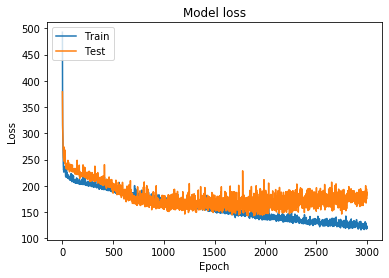

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [37]:
prediction_data_path = path.join(path.pardir, 'test.csv')
data_predict = pd.read_csv(prediction_data_path)
X_pred = engineer_features2(data_predict)

X_pred_numerical = X_pred[numerical_features]
imputer = KNNImputer(n_neighbors=2)
X_pred_numerical = imputer.fit_transform(X_pred_numerical)

X_pred_boolean = X_pred[boolean_features]
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_pred_boolean = imputer.fit_transform(X_pred_boolean)

X_pred = np.hstack((X_pred_numerical,X_pred_boolean))

In [38]:
y_pred = modeltest_int.predict(X_pred)
y_pred = pd.DataFrame({'MIN': y_pred[:, 0], 'MAX': y_pred[:, 1]})
y_pred.head()

,MIN,MAX
0,1113.966553,1143.959106
1,399.713104,408.921539
2,860.099487,879.030701
3,732.733398,780.014343
4,1171.438477,1552.544678


In [39]:
y_pred['MIN'] = y_pred['MIN'].where(y_pred['MIN'] <= y_pred['MAX'], y_pred['MAX'])
y_pred = y_pred.round(decimals = 2)
y_pred.head()

,MIN,MAX
0,1113.969971,1143.959961
1,399.709991,408.920013
2,860.099976,879.030029
3,732.729980,780.010010
4,1171.439941,1552.540039


In [40]:
y_pred['ID'] = data['id']
y_pred = y_pred[['ID', 'MIN', 'MAX']]
y_pred.head()

,ID,MIN,MAX
0,7774,1113.969971,1143.959961
1,25926,399.709991,408.920013
2,25267,860.099976,879.030029
3,22367,732.729980,780.010010
4,17471,1171.439941,1552.540039


In [41]:
y_pred.to_csv('predictionsNN.csv', index = False)